In [1]:
%%html
<h1 id="tocheading">Table of Contents</h1>
<br>
<div id="toc"></div>
<script>
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')
</script>
<style>
table {
    display: inline-block
}
</style>

# Setup
## Important sections
If you want a subset of a data (for example a certain species) change the code [here](#Query-specific-information)

**NB.** To run the whole notebook at once: Click on the >> symbol above in the application ribbon.

## Change the folder where all the data on your computer is, here:
For this notebook you need the following files, they need to be in that directory:
 * `gene.matched.tsv.smallarraycheck.csv` (Unpatched) OR `hits.tsv.header.cvs` (Patched; this is the default based on has_header == True)
 * `genome.types.csv`
 * `all_spacers.fna`
 * `spacers.info.csv`
 * `genome_meta.csv`
 * `phages.coords.csv`
 
For the Plot_on_genome notebook you additional need 
 * `contig_metadata_patric_genomes.csv`

In [2]:
# This is where you set the directory with all the data. 
data_folder = '/home/hielke/bep/res/'

## GLOBALS AND GENERAL UTILS
Here globally used imports are made and certain usefull variables and functions for plotting initialized.

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels as sm
# %matplotlib inline
pd.options.display.max_columns = None
def increase_figsize(N, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*N, plSize[1]*N))
def increase_size_by(N, fontsize, plt=plt):
    params = plt.gcf() if type(plt) is type(pd) else plt
    axes = params.get_axes()
    plSize = params.get_size_inches()
    params.set_size_inches((plSize[0]*N, plSize[1]*N))
    for ax in axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
            
# Setting some default params. 
cbf = ['#377eb8', '#ff7f00', '#4daf4a',
        '#f781bf', '#a65628', '#984ea3',
        '#999999', '#e41a1c', '#dede00']
cbf_map = mpl.colors.ListedColormap(cbf)
rc = {'axes.facecolor': 'white', 'axes.edgecolor': '.15', 'axes.axisbelow': True, 'figure.facecolor': 'white',
      'axes.labelcolor': '.15',  'text.color': '.25',
      'patch.force_edgecolor': True, 'patch.edgecolor': 'w',
      'xtick.bottom': True, 'ytick.left': True, 'xtick.color': '.15', 'ytick.color': '.15',
      'grid.linestyle': '-', 'axes.grid': False, 'grid.color': '.8', 
      'font.size': 30, 
      'xtick.labelsize': 15, 'ytick.labelsize': 15, 
      'axes.titlesize': 22,
      'axes.labelsize': 15,
      'legend.fontsize': 18, 'legend.title_fontsize': 30,
      }
sns.set(rc=rc)
sns.set_palette(cbf)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

Initialize functions and variables for saving figures.

In [4]:
# this can be added with the preprocessing file 'patches/remove_double_genomes.py' or 'patches/summary'
# already done for existing data.
has_header = True

# Variables that are used for the location and names for the saved figure.
first_order = 'A'
second_order = 0
title_mod = ""
fig_folder = '/home/hielke/bep/figs/FINAL2/'

save = True  # Change to True if you want save your figures in the `fig_folder`.

def save_fig(ax=None, save=save, plt=plt, title=None, format='png', fig_folder=fig_folder):
    if not save: 
        return 
    
    if not ax: 
        ax = plt.gca()
        
    title = title or (g.fig._suptitle._text 
                      if type(ax) is sns.axisgrid.FacetGrid 
                      else ax.get_title())
    title = title.replace('/', '|')
    
    global second_order
    second_order += 1
    
    dest = fig_folder + first_order + str(second_order) + "___" \
        + title.replace(" ", "_") + "." + format
    plt.savefig(dest, format=format, bbox_inches='tight')
    print("figure saved in " + dest)

Initialize usefull pandas functions and others

In [5]:
def percentage(x): 
    return x / x.sum()

from pandas.core.base import PandasObject

PandasObject.set_columns = lambda df, values: df.T.set_index(values).T

import re
def megasplit(pattern, string):
    """Split with zero length regex
    https://stackoverflow.com/questions/29988595/python-regex-splitting-on-pattern-match-that-is-an-empty-string
    """
    splits = list((m.start(), m.end()) for m in re.finditer(pattern, string))
    starts = [0] + [i[1] for i in splits]
    ends = [i[0] for i in splits] + [len(string)]
    return [string[start:end] for start, end in zip(starts, ends)]

# READ IN DATA
Data from files is read in the following cells.

`df` is the main frame with the most information.

`df` can be made from the default file, or the patched file, made with `patches/summary` script.

In [6]:
if has_header:
    df = pd.read_csv(data_folder + 'hits.tsv.header.csv', sep='\t', 
                    index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str, 'spacer_pos': int, 'spacer_size': int}
                    ).set_index('genome_id')
else:
    df = pd.read_csv(data_folder + 'gene.matched.tsv.smallarraycheck.csv', sep='\t', 
                 names=['genome_key', 'genome_id', 'contig_hit', 'c_1', 'c_2', 'spacer_id', 'hit_ident', 'spacer_size', 
                        'contig_size', '3_prime', '5_prime', 'array_id', 'array_size', 'array_confid', 'repeat_size', 'array_type', 'genome_type',
                        'PAM_confid', 'poss_PAM', 'PAM_side', 'phage_class', 'with_phage',  'gene_hit', 'gene_id', 'gene_class'],
                index_col=False, keep_default_na=False, 
                     dtype={'genome_id': str}).set_index('genome_id')
df.drop(['3_prime', '5_prime', 'genome_key',], axis=1, inplace=True)
df.head()

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,
1496.1168,AAAAAAAAAGATACATCTGTAACTAATTTTTATACT,36935,36900,FAKJ01000041,14,FAKJ01000002_1_14,94.44,36,37679,FAKJ01000002_1,14,6.23,29,CAS-TypeIB,CAS-TypeIB,3,TGGAGTTATT,3,NULL,0,RNA-,FAKJ01000041_27,"DNA breaking-rejoining enzyme, catalytic core",1.000000,tail
1049982.3,AAAAAAAAATGCCCTTACTTGCGTACGGTTATTACAA,37578,37542,AHOJ01000037,16,AHOJ01000080_1_16,100.00,37,49939,AHOJ01000080_1,25,3.26,36,NA,CAS-TypeIE,0,TCCGGCCTTT,3,NULL,0,RNA-,AHOJ01000037_36,UNCLASSIFIED,0.625000,middle
1357400.3,AAAAAAAAATGCGATTTTATCTATTTTTT,87181,87153,AZJI01000001,5,AZJI01000011_1_5,79.31,29,717268,AZJI01000011_1,8,3.26,36,NA,CAS,-1,NULL,NULL,NULL,0,INTERGENIC,NULL,NULL,0.571429,middle
1357400.3,AAAAAAAAATGCGATTTTATCTATTTTTT,241326,241298,AZJI01000007,5,AZJI01000011_1_5,79.31,29,315616,AZJI01000011_1,8,3.26,36,NA,CAS,-1,NULL,NULL,NULL,0,INTERGENIC,NULL,NULL,0.571429,middle
1357400.3,AAAAAAAAATGCGATTTTATCTATTTTTT,300807,300835,AZJI01000007,5,AZJI01000011_1_5,79.31,29,315616,AZJI01000011_1,8,3.26,36,NA,CAS,-1,NULL,NULL,NULL,0,INTERGENIC,NULL,NULL,0.571429,middle


Reading in all sequence data.

Information about each genome crispr type.

In [7]:
df_genome_class = pd.read_csv(data_folder + 'genome.types.csv', sep='\t', 
                              names=['genome_id', 'type', 'class', 'num_genes'], 
                              dtype={'genome_id': str, 'num_genes': int}).set_index('genome_id')
df_genome_class.head()

,type,class,num_genes
genome_id,,,
100053.4,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11
100053.5,CAS-TypeIE,SingleUnknownExtra,8
100053.6,CAS-TypeIE,SingleUnknownExtra,8
100053.7,CAS-TypeIE,SingleUnknownExtra,8
100053.8,CAS-TypeIE,AccompaniedSingleUnknown,8


Information about the crispr arrays.

In [8]:
df_crispr = pd.read_csv(data_folder + 'spacers.info.csv', sep='\t', 
                        names=['genome_id', 'contig', 'array_id', 'start', 'end', 'ori', 'size', 'type', 'conf', 'repeat',],
                        dtype={'genome_id': str}, keep_default_na=False).set_index('genome_id')
df_crispr.head()

,contig,array_id,start,end,ori,size,type,conf,repeat
genome_id,,,,,,,,,
1324264.3,JLXT01000011,JLXT01000011_1,0,684,Reverse,9,NA,3.18,GTCGTCAGACCCAAAACCCCGAGAGGGGACGGAAAC
1324264.3,JLXT01000009,JLXT01000009_1,947496,948851,Reverse,18,NA,3.24,GTCGTCAGACCCAAAACCCCGAGAGGGGACGGAAAC
1324264.3,JLXT01000010,JLXT01000010_1,56,1186,Reverse,15,NA,3.20,GTCGTCAGACCCAAAACCCCGAGAGGGGACGGAAAC
1603886.3,BDIS01000038,BDIS01000038_1,5412,6343,Forward,14,NA,3.24,CAAGCTTATCAAGAAGGGTGAATGCTAATTCCCAGC
1633637.3,CZVQ01000157,CZVQ01000157_1,2,778,Forward,9,NA,3.26,GTGAGCATCGAACCAGTGTGGAATTTAAAC


Meta information about each genome (ammount of contigs / total lenght / species name)

In [9]:
df_meta = pd.read_csv(data_folder + "genome_meta.csv", sep='\t', 
                     names=['genome_id', 'contigs', 'size', 'name'], 
                     dtype={'genome_id': str}).set_index('genome_id')
df_meta.head()

,contigs,size,name
genome_id,,,
100053.4,341,4040397,Leptospira alexanderi strain 56650
100053.5,335,4044353,Leptospira alexanderi strain 56643
100053.6,368,4062692,Leptospira alexanderi strain 56640
100053.7,337,4067564,Leptospira alexanderi strain 56159
100053.8,238,4060960,Leptospira alexanderi strain 56659


In [10]:
df_acr_aca = pd.read_csv(data_folder + "acr+aca.hits", sep='\t',
                    names=['genome_id', 'qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 
                           'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen'],
                     dtype={'genome_id': str}).set_index('genome_id')
df_acr_aca.head()

,qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,qlen,slen
genome_id,,,,,,,,,,,,,,
1030009.3,CP002816,WP_003722518.1,80.54,149,29,0,1265014,1264568,1,149,7.000000e-72,239.0,2976163,149
1030009.3,CP002816,WP_014930691.1,91.20,125,11,0,1265778,1265404,1,125,2.000000e-52,182.0,2976163,125
1030009.3,CP002816,WP_003723290.1,81.61,87,16,0,108715,108455,1,87,1.000000e-39,144.0,2976163,87
1069608.3,ALXM01000006,WP_042743678.1,91.15,113,10,0,50041,50379,1,113,2.000000e-66,219.0,117940,123
1069608.3,ALXM01000006,WP_042743676.1,92.86,112,8,0,49657,49992,5,116,6.000000e-64,211.0,117940,116


In [11]:
df_tn = pd.read_csv(data_folder + "transposon_list", sep='\t', 
                    names=['genome_id', 'gene_id', 'gene_name'],
                    dtype={'genome_id': str}).set_index('genome_id')
df_tn.head()

,gene_id,gene_name
genome_id,,
1873484.3,MKGR01000055_2,TniQ
658630.3,LHUY01000001_534,TniQ
550.474,JUNO01000018_67,TniQ
470.3363,MEDG01000032_2,"TnsA endonuclease, N-terminal"
42234.33,LYDV01000598_57,TniQ


In [12]:
df_phages = pd.read_csv(data_folder + 'phages.coords.csv', sep='\t',
                       names=['genome_id', 'contig', 'phage_group', 's', 'e', 'gene_start', 'gene_end'],
                       dtype={'genome_id': str}).set_index('genome_id')
df_phages.head()

,contig,phage_group,s,e,gene_start,gene_end
genome_id,,,,,,
319705.57,FSBC01000007,5,121280.0,137206.0,123.0,147.0
319705.57,FSBC01000002,6,668178.0,704876.0,652.0,693.0
1639.811,JOYB01000007,2,159.0,34964.0,2.0,57.0
1639.811,JOYB01000014,2,NaN,NaN,NaN,NaN
1639.811,JOYB01000005,3,2250.0,51967.0,2.0,58.0


# Enhanchements
Patches for data clean up and enhancements of the data.

Other patches that have been applied can be found in the patches folder. (The summary contains all (and more) in one file.) To apply just `bash ../patches/summary` in the data folder.

In [13]:
# total_genomes = 110334
total_genomes = len(set(df_meta.index))
no_type = total_genomes - len(df_genome_class)  # There is also NOCAS in all_genome_types which is basically the same.
no_cas_no_selfhits = total_genomes - len(set(df.index)) - no_type  # Because of the above, this number is not correct.

### Specify some additional information

In [14]:
df['array_ori'] = df['rel_spacer_pos'].apply(lambda x: {0: 'head', 1: 'tail'}.get(x) or 'mid')
df = df.join(df_meta, )
del df_meta

### Remove CRISPR flanking STSs
Remove a STS when it is flanked by the STS it originates from. This can happen when the repeat of this spacer is so degenerated that CRISPRDetect does not recognize it anymore. Removal happens for all spacers in the vicinity of the array if the distance distance is lower than 50. This will be done by patches outside notebook now. (To remove for all arrays.)

In [15]:
# df = df.join(
#     df_crispr.drop_duplicates().rename({'type': 'array_repeat_type'}, axis=1).reset_index(drop=True).set_index('array_id'), 
#     on='array_id', rsuffix='_crispr').pipe(
#     lambda df:
#     df
#     [
#     (
#         (np.maximum(np.maximum(df['start'], df['end']), np.maximum(df['c_1'], df['c_2']))) -
#         (np.minimum(np.minimum(df['start'], df['end']), np.minimum(df['c_1'], df['c_2'])))
#     )
#     - (np.abs(df['start'] - df['end']) + np.abs(df['c_1'] - df['c_2']))
#     > 50
#     ]
# )


# Top level plotting (Of STS in groups "No CAS genes", "Incomplete", "Mixed CRISPR System", "Complete CRISPR System")
Plots that make use of grouping of genomes in the large (top level) distinctions.

In [16]:
# Naming used for the groupings.

NOCAS = "No CAS genes"
Mixed = "Mixed CRISPR System"
Complete = "Complete CRISPR System"
Incomplete = "Incomplete CRISPR System"
other = 'Cas-TypeVC | CAS-TypeVIB2'  # 'other'  # Those that exist in all, but not anymore in the selfhit group.
# 'CAS-TypeVC': 1, 'CAS-TypeVIB2': 2

#### First we make a `new_type_group`

In [17]:
def new_type_group(row):
#     print(row)
    if row['num_genes'] == 0:
        return NOCAS
    if "Unclassified" in row['class']:
        return Incomplete
    if "MultipleConfirmed" in row['class']:
        # Confirmed Mixed: The CRISPR array associated confirms that the type is a mixed type.
        return Mixed  
    if "/" in row['type'] or row['type'] == "CAS": 
        return Mixed
    return row['type']
#     if "Confirmed" in row['class']:
#         return "Confirmed " + row['type']
#     if "Accompanied" in row['class']:
#         return "Accompanied " + row['type']
    
df_genome_class['new_type_group'] = df_genome_class.apply(new_type_group, axis=1)

In [18]:
df = df.join(df_genome_class)
df_genome_class[['new_type_group']].head()

,new_type_group
genome_id,
100053.4,CAS-TypeIE
100053.5,CAS-TypeIE
100053.6,CAS-TypeIE
100053.7,CAS-TypeIE
100053.8,CAS-TypeIE


## Renaming

In [19]:
df['genome_type'].where(df['genome_type'] != 'NOCAS', other=NOCAS, inplace=True)

#### Here the top level is actually set

In [20]:
assert 'Mixed' in Mixed, \
        "Mixed is one group, there is no distinction between the multiple mixed possibilities in there anymore."
df['top_level_group'] = df['new_type_group'].apply(lambda x: Mixed if 'Mixed' in x else 
                                                  {k: k for k in [NOCAS, Incomplete]}.get(x) or Complete)

## Query specific information
Here you can specify a subset of the data you want to view. Test on of the examples to comment it out. (Specify the cut-off identity in the next cell.)  

**NB.** You have to be carefull interpreting the results you get with this. Not all plots will automatically adjust themself with new data and can look odd with it. The scale can be off, or the plot doesn't work out very well far small amount of data, or data that is diversified. Also, some plots just don't make any sense anymore, since they compare all genomes with each other. Also the category 'other', which is now 'CAS-TypeVC | CAS-TypeVIB2' will change. 

Substring search (name is the species name).  
**NB.** Watch out with capitals,  
it is better to query with `[Tt]uberculosis` so that both Tuberculosis and tuberculosis is captured. (If the `[Tt]` look odd to you, look up regular expressions.)

In [21]:
# df = df[df['name'].str.contains('tuberculosis')]

Type search (use regex to make the distinction, substring won't distinct TypeI and TypeII)  
The `new_type_group` excludes all mixed types, otherwise use `type`  
If the latter is chosen be aware that all plots,  
make use of the custom grouping based on the `new_type_group` instaed,   
so decide if you want to change that as well  

In [22]:
# df = df[df['new_type_group'].str.contains('TypeI[^I]')]

PAM: The pam group 3 indicates that both the array repeat family as the crispr cas locus corresponds with the PAM. Also see [here](#PAM-analysis)

In [23]:
# df = df[df['PAM_confid'] == 3]

In [24]:
# df = df[df['spacer_pos'] <= 10]

In [25]:
# df = df[df['new_type_group'].str.contains('TypeIC')]

### Split in certain groups

In [26]:
# Identity with hit cut-off
# Group with unique spacer hits

# df : df with hit cut-off 
# df_all : all rows (so larger than the default 75 %)
# df_uni : Unique spacers for a genome (with the hit cut-off)
# df_uni_all : All unique spacers

# This is the hit cuff-off, change to include more or less STSs in the `df` data frame.
perc_ident = 90

df_uni = (
    df.reset_index()
    .groupby(['genome_id', 'seq']).first().reset_index()
    .set_index('genome_id')
)
df_all = df
df_uni_all = df_uni

df = df.query('hit_ident > @perc_ident')
df_uni = df_uni.query('hit_ident > @perc_ident')
perc_ident = '100%' if perc_ident == 100 else '>%d%%' % perc_ident

In [27]:
assert len(df_all) != 0, "The applied selection did not pass any STSs."
print(len(df_all))
len(df_all.index.unique())

174052


21538

# MAKE CRISPR GROUPING

## DEFAULT GROUPING
Every type is kept as it was originally described by the classifier.

In [28]:
df_single_type = df[~df['genome_type'].str.contains('/')]

In [29]:
def sort_groups(group_type):
    if group_type.startswith("Mixed"):
        return "U"
    if group_type == other:
        return 'MZ'
    if not group_type.startswith("CAS"):
        return "Z" + group_type
    return "-".join(megasplit(r'(?<=V|I)(?!V|I)', group_type))
def crispr_order(d):
    return d.reindex(index=sorted(d.index, key=sort_groups, reverse=True))

In [30]:
df_genome = df.groupby(df.index).first()
df_genome['selfhit_count'] = df.groupby(df.index)['contig_hit'].agg('count')
df_genome_type_count = df_genome['genome_type'].value_counts()
all_genome_type_count = df_genome_class['type'].value_counts()
all_genome_type_count = all_genome_type_count[df_genome_type_count.index]
all_genome_type_count[NOCAS] = no_type
all_genome_type_count[other] = total_genomes - sum(all_genome_type_count)
df_genome_type_count[other] = 0
df_genome_type_count = df_genome_type_count.reindex(index = sorted(df_genome_type_count.index))
all_genome_type_count = all_genome_type_count.reindex(index = sorted(all_genome_type_count.index))

## CUSTOM GROUPING
For this the `new_type_group` is used. This is the type without any split types. They are just "Mixed", allthough a distinction within the "Mixed" can be made, this is rather arbitrary, and therefore the custom grouping uses the simple case in which a mixed groups is *just* a mixed group.

In [31]:
alltypes_renamed_count = df_genome_class['new_type_group'].value_counts()
dftyped_renamed = df.groupby(by='genome_id').first()
dftyped_renamed['selfhit_count'] = df.groupby(by='genome_id')['contig_hit'].agg('count')
dftyped_renamed_count = dftyped_renamed['new_type_group'].value_counts()
print(alltypes_renamed_count)
alltypes_renamed_count[NOCAS] += no_type

# Setting other
# *can* include: {'CAS-TypeVC': 1, 'CAS-TypeVIB2': 2} (depending on cut-off value (currently 90 %))
# Other is all genomes types that occur in all, but not in the group of genomes with at least one STS.

alltypes_renamed_count_no_other = alltypes_renamed_count
alltypes_renamed_count = alltypes_renamed_count[dftyped_renamed_count.index]
alltypes_renamed_count[other] = total_genomes - sum(alltypes_renamed_count)

dftyped_renamed_count[other] = 0
dftyped_renamed_count = dftyped_renamed_count.reindex(index=sorted(dftyped_renamed_count.index, key=sort_groups))
alltypes_renamed_count = alltypes_renamed_count.reindex(index=sorted(alltypes_renamed_count.index, key=sort_groups))

CAS-TypeIE                  15342
CAS-TypeIIIA                10035
Incomplete CRISPR System     5627
CAS-TypeIF                   3390
No CAS genes                 3035
CAS-TypeIIC                  2983
CAS-TypeIIA                  2844
Mixed CRISPR System          2716
CAS-TypeIC                   2384
CAS-TypeIB                   2341
CAS-TypeIU                    262
CAS-TypeIIIB                  250
CAS-TypeIIB                   205
CAS-TypeIV                    189
CAS-TypeIIID                  155
CAS-TypeIA                    135
CAS-TypeID                    107
CAS-TypeVA                     71
CAS-TypeVIA                    53
CAS-TypeVIB1                   34
CAS-TypeVB                     15
CAS-TypeIIIC                   12
CAS-TypeVIB2                    2
CAS-TypeVC                      1
Name: new_type_group, dtype: int64


Insert zeros in certain places so that some graphs are more readable.

In [32]:
def insert_rows(df, idx, df_insert=None):
    if not df_insert: 
        df_insert = [0] * len(idx)
    df_insert = [pd.Series({"": i}) for i in df_insert]
    res = df.iloc[:idx[0], ]
    for i in range(len(idx) - 1):
        res = res.append(df_insert[i]).append(df.iloc[idx[i]:idx[i+1], ])
    res = res.append(df_insert[-1]).append(df.iloc[idx[-1]:, ])
    return res

# splits = [7, 10, 14, 15, 18, 21]
splits = [7, 10, 14, 15, 17, 19, 
#           22,
         ]
dftyped_renamed_count = insert_rows(dftyped_renamed_count, splits)
alltypes_renamed_count = insert_rows(alltypes_renamed_count, splits)

## Anti CRISPR analysis

In [33]:
acr = {l.strip() for l in open(data_folder + 'acr_ids')}
aca = {l.strip() for l in open(data_folder + 'aca_ids')}

Remove all hits that are just associated (aca) and not actual anti-crispr.

In [34]:
df_acr = df_acr_aca.query('sseqid in @acr')
df_acr = df_acr.groupby(by='genome_id').first()
df_aca = df_acr_aca.query('sseqid in @aca')
df_aca = df_aca.groupby(by='genome_id').first()

In [35]:
type_sts = df.groupby(by='genome_id').first() \
    .groupby(by='new_type_group') \
    .apply(len)
type_sts

new_type_group
CAS-TypeIA                    18
CAS-TypeIB                  1044
CAS-TypeIC                   691
CAS-TypeID                    16
CAS-TypeIE                  2012
CAS-TypeIF                  1513
CAS-TypeIIA                  734
CAS-TypeIIB                   11
CAS-TypeIIC                  575
CAS-TypeIIIA                  90
CAS-TypeIIIB                  25
CAS-TypeIIIC                   2
CAS-TypeIIID                  30
CAS-TypeIU                    46
CAS-TypeIV                     5
CAS-TypeVA                     9
CAS-TypeVB                     2
CAS-TypeVIA                    4
CAS-TypeVIB1                   1
Incomplete CRISPR System     179
Mixed CRISPR System          662
No CAS genes                 797
dtype: int64

In [36]:
all_type = df_genome_class.groupby(by='genome_id').first() \
    .groupby(by='new_type_group') \
    .apply(len)
all_type

new_type_group
CAS-TypeIA                    135
CAS-TypeIB                   2341
CAS-TypeIC                   2384
CAS-TypeID                    107
CAS-TypeIE                  15342
CAS-TypeIF                   3390
CAS-TypeIIA                  2844
CAS-TypeIIB                   205
CAS-TypeIIC                  2983
CAS-TypeIIIA                10035
CAS-TypeIIIB                  250
CAS-TypeIIIC                   12
CAS-TypeIIID                  155
CAS-TypeIU                    262
CAS-TypeIV                    189
CAS-TypeVA                     71
CAS-TypeVB                     15
CAS-TypeVC                      1
CAS-TypeVIA                    53
CAS-TypeVIB1                   34
CAS-TypeVIB2                    2
Incomplete CRISPR System     5627
Mixed CRISPR System          2716
No CAS genes                 3035
dtype: int64

In [37]:
# Appearance in group with selfhits.
acr_sts = df.groupby(by='genome_id').first() \
    .groupby(by='new_type_group') \
    .apply(lambda l: sum(l.index.isin(df_acr.index)))
acr_sts

new_type_group
CAS-TypeIA                    0
CAS-TypeIB                   83
CAS-TypeIC                    6
CAS-TypeID                    0
CAS-TypeIE                  106
CAS-TypeIF                  366
CAS-TypeIIA                 153
CAS-TypeIIB                   0
CAS-TypeIIC                   7
CAS-TypeIIIA                  0
CAS-TypeIIIB                  0
CAS-TypeIIIC                  0
CAS-TypeIIID                  0
CAS-TypeIU                    0
CAS-TypeIV                    4
CAS-TypeVA                    3
CAS-TypeVB                    0
CAS-TypeVIA                   2
CAS-TypeVIB1                  0
Incomplete CRISPR System      4
Mixed CRISPR System          25
No CAS genes                160
dtype: int64

In [38]:
# Appearance in all genomes
acr_all = df_genome_class.groupby(by='genome_id').first() \
    .groupby(by='new_type_group') \
    .apply(lambda l: sum(l.index.isin(df_acr.index)))
acr_all

new_type_group
CAS-TypeIA                    0
CAS-TypeIB                  100
CAS-TypeIC                   14
CAS-TypeID                    0
CAS-TypeIE                  116
CAS-TypeIF                  394
CAS-TypeIIA                 175
CAS-TypeIIB                   0
CAS-TypeIIC                   9
CAS-TypeIIIA                  1
CAS-TypeIIIB                  0
CAS-TypeIIIC                  0
CAS-TypeIIID                  0
CAS-TypeIU                    0
CAS-TypeIV                   26
CAS-TypeVA                    4
CAS-TypeVB                    0
CAS-TypeVC                    0
CAS-TypeVIA                   3
CAS-TypeVIB1                  1
CAS-TypeVIB2                  0
Incomplete CRISPR System     14
Mixed CRISPR System          27
No CAS genes                206
dtype: int64

In [39]:
acr

{'ABR13388.1',
 'ACD38920.1',
 'AFC22483.1',
 'AKG19228.1',
 'AKG19229.1',
 'AKG19230.1',
 'AKI27193.1',
 'ASD50988.1',
 'EGE18854.1',
 'KEK29119',
 'LR030269',
 'LR030270',
 'LR030271',
 'LR030272',
 'MH000604',
 'NP_938237',
 'NP_938238.1',
 'WP_002642161.1',
 'WP_003722517.1',
 'WP_003722518.1',
 'WP_003723290.1',
 'WP_014930691.1',
 'WP_016068584.1',
 'WP_031500045.1',
 'WP_034985946.1',
 'WP_038819808.1',
 'WP_042743676.1',
 'WP_042743678.1',
 'WP_043884810',
 'WP_046699156.1',
 'WP_046699157.1',
 'WP_046701302.1',
 'WP_049360089.1',
 'WP_049372635',
 'WP_064584002.1',
 'WP_074973300.1',
 'WP_087937214.1',
 'WP_087937215.1',
 'YP_007392342.1',
 'YP_007392439.1',
 'YP_007392440.1',
 'YP_007392738.1',
 'YP_007392740.1',
 'YP_009272954.1',
 'YP_950454.1'}

In [40]:
sts_genome_id = set(df.index)

In [41]:
summary_acr_aca = df_acr_aca.join(df_genome_class, how='left')
summary_acr_aca['Anti-CRISPR-type'] = summary_acr_aca['sseqid'].apply(lambda x: "ACR" if x in acr else "ACA")
summary_acr_aca['STS'] = summary_acr_aca.index.map(lambda x: "YES" if x in sts_genome_id else "NO")

In [42]:
# summary_acr_aca.to_csv('/home/hielke/bep/export_to_franklin/acr_complete.csv', sep='\t', index_label='genome_id')

## Transposon analysis

In [43]:
# Appearance in group with selfhits.
tn_sts = df.groupby(by='genome_id').first() \
    .groupby(by='new_type_group') \
    .apply(lambda l: sum(l.index.isin(df_tn.index)))
tn_sts

new_type_group
CAS-TypeIA                    0
CAS-TypeIB                   25
CAS-TypeIC                  110
CAS-TypeID                    3
CAS-TypeIE                  320
CAS-TypeIF                  261
CAS-TypeIIA                   0
CAS-TypeIIB                   0
CAS-TypeIIC                  13
CAS-TypeIIIA                  1
CAS-TypeIIIB                  4
CAS-TypeIIIC                  0
CAS-TypeIIID                  2
CAS-TypeIU                   12
CAS-TypeIV                    2
CAS-TypeVA                    1
CAS-TypeVB                    1
CAS-TypeVIA                   0
CAS-TypeVIB1                  0
Incomplete CRISPR System     26
Mixed CRISPR System          59
No CAS genes                181
dtype: int64

In [44]:
# Appearance in all genomes
tn_all = df_genome_class.groupby(by='genome_id').first() \
    .groupby(by='new_type_group') \
    .apply(lambda l: sum(l.index.isin(df_tn.index)))
tn_all

new_type_group
CAS-TypeIA                     0
CAS-TypeIB                    74
CAS-TypeIC                   211
CAS-TypeID                     8
CAS-TypeIE                  1049
CAS-TypeIF                   552
CAS-TypeIIA                    1
CAS-TypeIIB                    0
CAS-TypeIIC                   52
CAS-TypeIIIA                   8
CAS-TypeIIIB                  17
CAS-TypeIIIC                   0
CAS-TypeIIID                   6
CAS-TypeIU                    19
CAS-TypeIV                     4
CAS-TypeVA                     2
CAS-TypeVB                     1
CAS-TypeVC                     0
CAS-TypeVIA                    0
CAS-TypeVIB1                   0
CAS-TypeVIB2                   0
Incomplete CRISPR System      67
Mixed CRISPR System          158
No CAS genes                 327
dtype: int64

## DSM genomes

In [45]:
df.groupby(by='genome_id').first().index.isin(df_tn.index)

array([False, False, False, ..., False,  True, False])

In [46]:
# df_analysis = df_uni.pipe(
#     lambda df:
#     df.groupby(by='genome_id').agg('first')
#     .assign(
#         genome_count_hit=df.groupby(by='genome_id')['array_id'].agg('count'),
        
#     )
# )
df_analysis = df.pipe(
    lambda df:
    df.groupby(by='genome_id').pipe(
        lambda grouped:
        grouped.agg('first')
        .assign(
            genome_count_hit=grouped['array_id'].agg('count'),
            acr=grouped.first().index.isin(df_acr.index),
            tn=grouped.first().index.isin(df_tn.index)
        )
    )
)

df_analysis[df_analysis['name'].str.contains("aumanni") & (df_analysis['genome_count_hit'] > 1)][['genome_count_hit', 'name', 'new_type_group', 'acr', 'tn']]
# .to_csv('/home/hielke/work/print_transport/baumannii.csv', sep='\t')

,genome_count_hit,name,new_type_group,acr,tn
genome_id,,,,,
1217631.3,4,Acinetobacter baumannii NIPH 290,CAS-TypeIF,False,True
1217635.3,2,Acinetobacter baumannii NIPH 527,CAS-TypeIF,False,True
1217647.3,2,Acinetobacter baumannii NIPH 60,No CAS genes,False,False
1221246.3,3,Acinetobacter baumannii AB_1583-8,CAS-TypeIF,False,True
1221252.3,4,Acinetobacter baumannii AB_2007-09-110-01-7,CAS-TypeIF,False,True
1221273.3,2,Acinetobacter baumannii AB_TG19617,CAS-TypeIF,False,True
1221288.3,7,Acinetobacter baumannii AB_TG27343,CAS-TypeIF,False,True
1310619.3,28,Acinetobacter baumannii 1419130,CAS-TypeIF,False,True
1310621.3,3,Acinetobacter baumannii 869535,CAS-TypeIF,False,False


In [47]:
sts_acr_perc = df_analysis.groupby('new_type_group')['acr'].apply(lambda d: sum(d)/len(d)).rename("ACR in selfhit group")
sts_tn_perc = df_analysis.groupby('new_type_group')['tn'].apply(lambda d: sum(d)/len(d)).rename("Transposon in selfhit group")
exp_acr_perc = df_genome_class.groupby(by='new_type_group').apply(lambda l: sum(l.index.isin(df_acr.index)) / len(l)).rename("Expected percentage with ACR")
exp_tn_perc = df_genome_class.groupby(by='new_type_group').apply(lambda l: sum(l.index.isin(df_tn.index)) / len(l)).rename("Expected percentage with transposon")

In [48]:
prot_combi = pd.concat([sts_acr_perc, exp_acr_perc, sts_tn_perc, exp_tn_perc], axis=1, sort=True) \
    .dropna().pipe(lambda d: d[d.apply(sum, axis=1) != 0])
# Seaborn handles long form, so unpivot this.
kind = "Protein in genome with or without STS"
prot_combi = prot_combi.reset_index().rename({'index': 'genome_type'}, axis=1).melt('genome_type', var_name=kind, value_name='percentage')

In [134]:
df_genome_class.head()

,type,class,num_genes,new_type_group
genome_id,,,,
100053.4,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE
100053.5,CAS-TypeIE,SingleUnknownExtra,8,CAS-TypeIE
100053.6,CAS-TypeIE,SingleUnknownExtra,8,CAS-TypeIE
100053.7,CAS-TypeIE,SingleUnknownExtra,8,CAS-TypeIE
100053.8,CAS-TypeIE,AccompaniedSingleUnknown,8,CAS-TypeIE


In [136]:
len(df_tn.index)

5032

In [142]:
df_genome_class['new_type_group'].value_counts()

CAS-TypeIE                  15342
CAS-TypeIIIA                10035
Incomplete CRISPR System     5627
CAS-TypeIF                   3390
No CAS genes                 3035
CAS-TypeIIC                  2983
CAS-TypeIIA                  2844
Mixed CRISPR System          2716
CAS-TypeIC                   2384
CAS-TypeIB                   2341
CAS-TypeIU                    262
CAS-TypeIIIB                  250
CAS-TypeIIB                   205
CAS-TypeIV                    189
CAS-TypeIIID                  155
CAS-TypeIA                    135
CAS-TypeID                    107
CAS-TypeVA                     71
CAS-TypeVIA                    53
CAS-TypeVIB1                   34
CAS-TypeVB                     15
CAS-TypeIIIC                   12
CAS-TypeVIB2                    2
CAS-TypeVC                      1
Name: new_type_group, dtype: int64

In [152]:
prot_combi['percentage'] = prot_combi['percentage'].mul(100)

In [156]:
prot_combi.to_csv('/home/hielke/bep/export_to_franklin/transposon_value_list.csv', sep='\t')

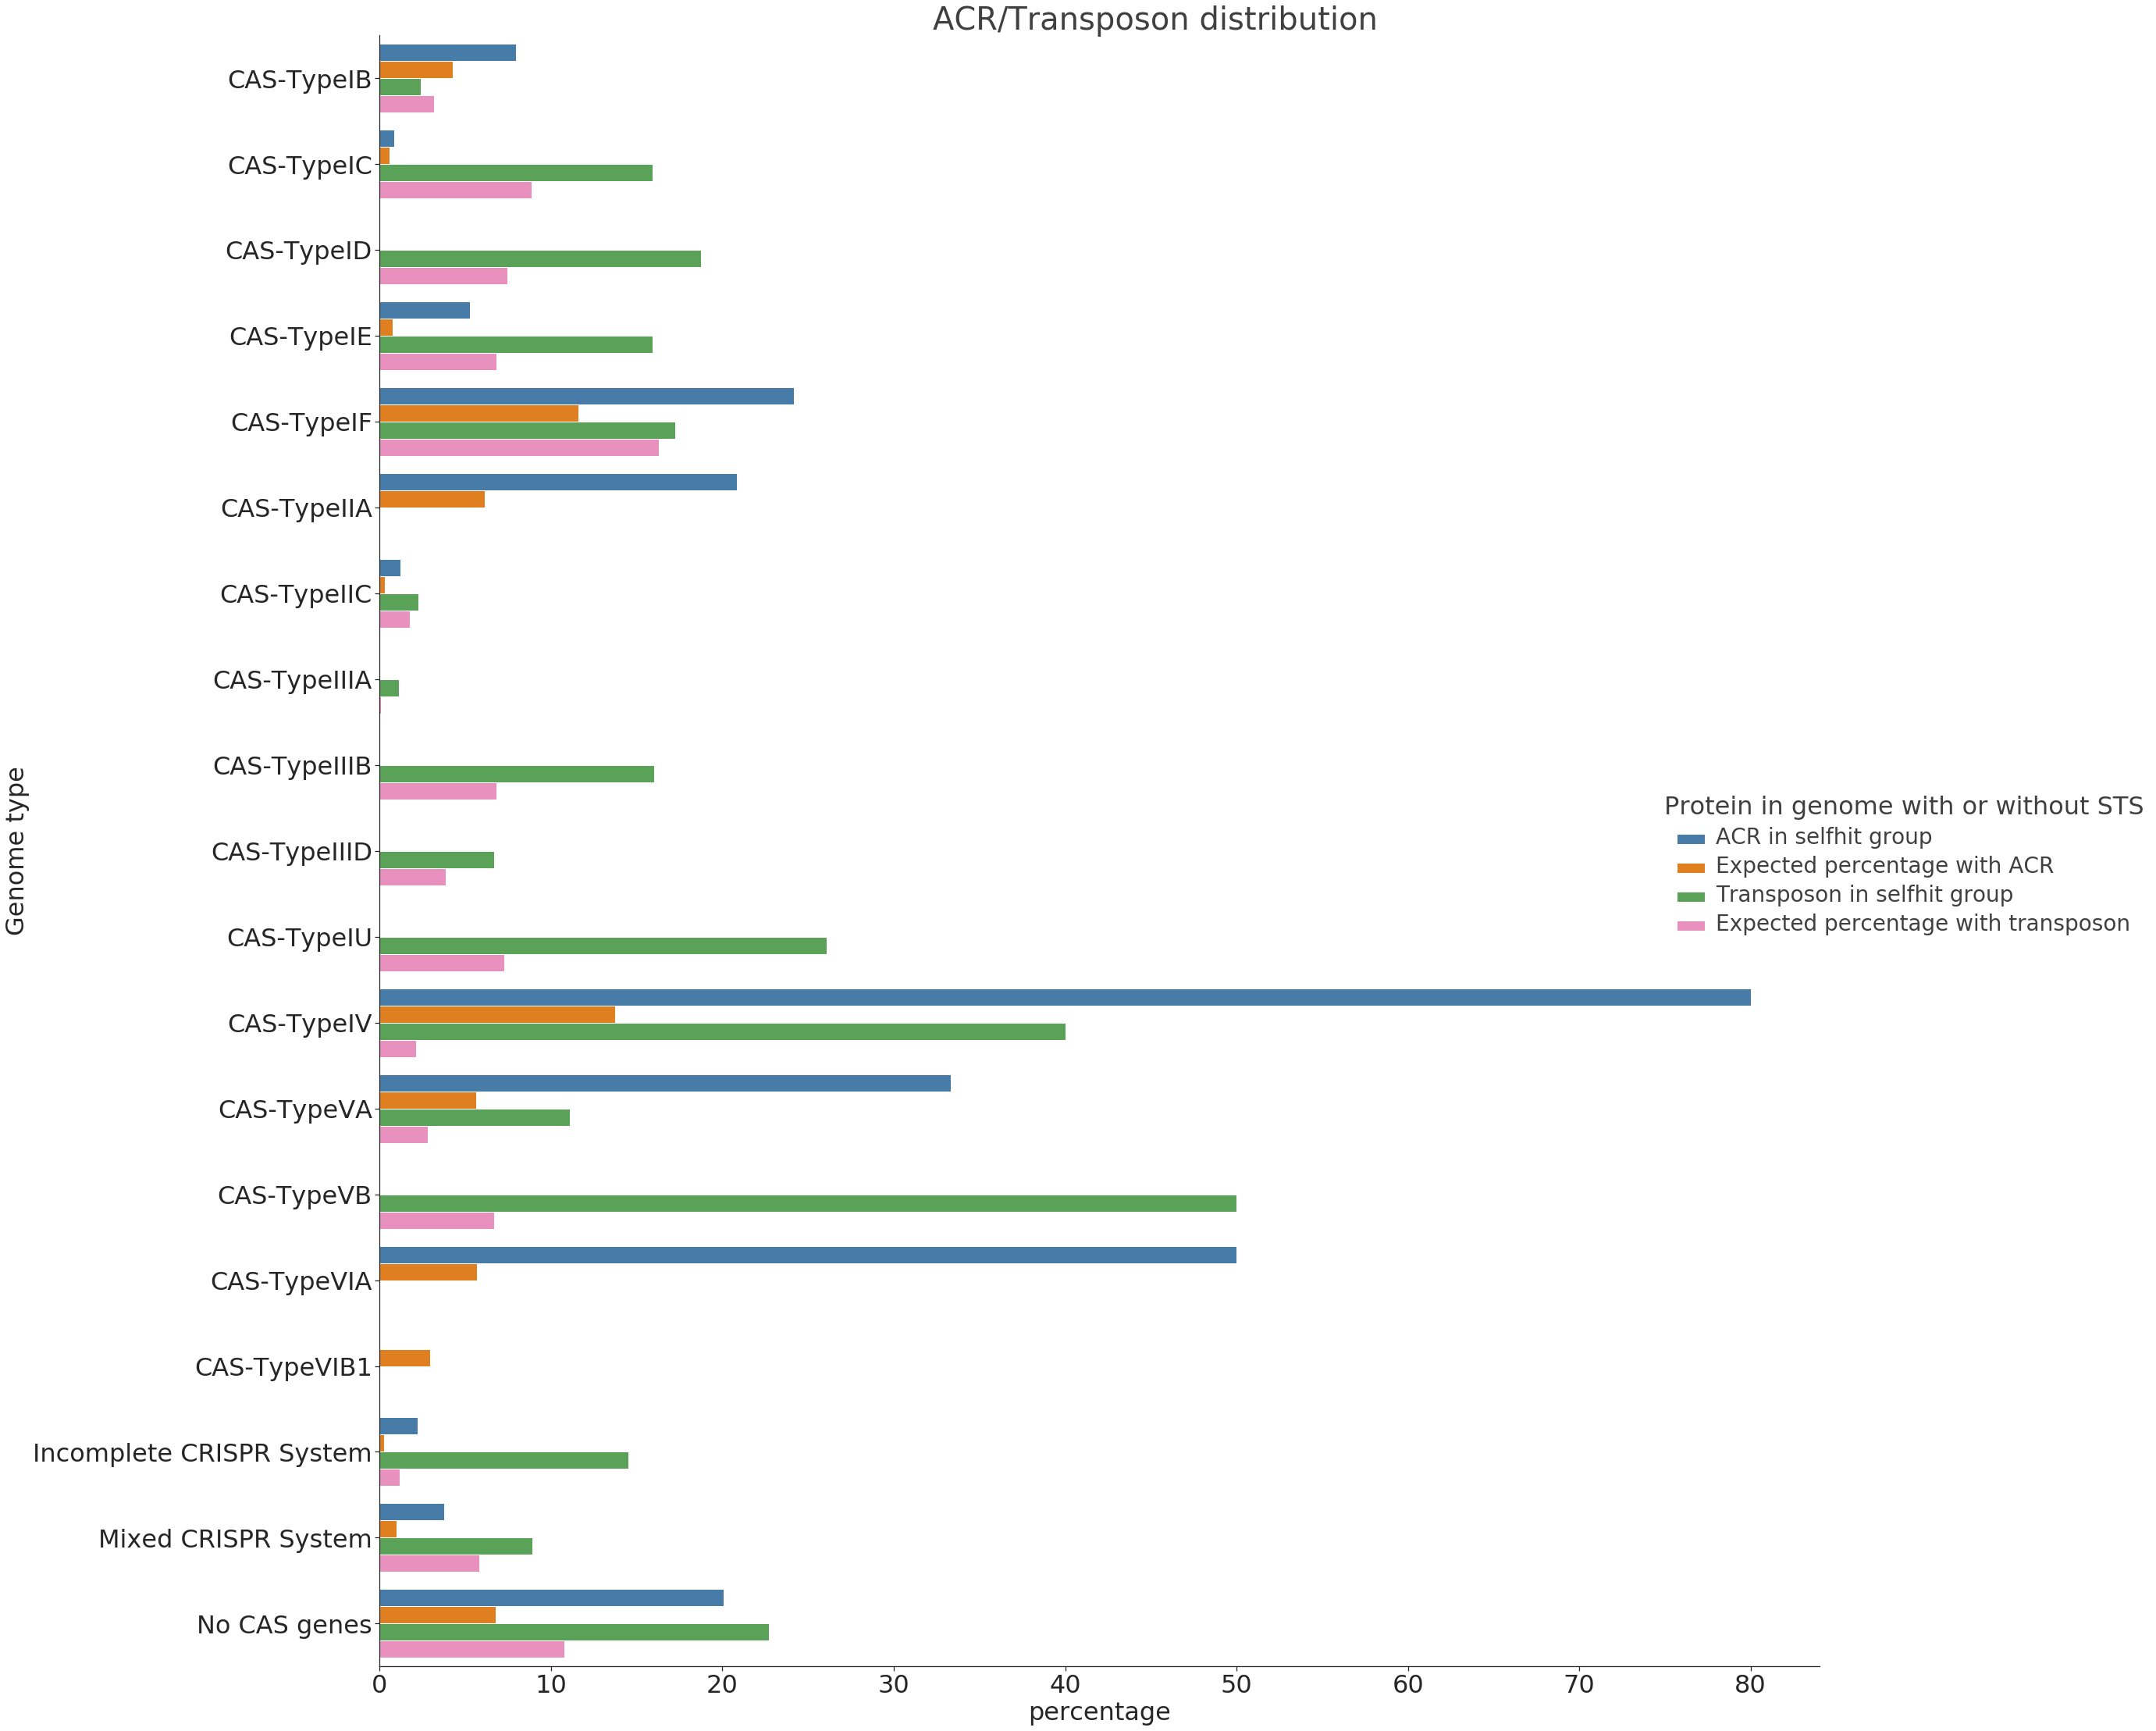

In [153]:
g = sns.catplot(data=prot_combi, y='genome_type', x='percentage', hue=kind, kind='bar', height=30, orient='h')
g.fig.suptitle("ACR/Transposon distribution", fontsize=40, y=1.01)
g.set_ylabels("Genome type")
plt.setp(g._legend.get_title(), fontsize=32)
plt.setp(g._legend.get_texts(), fontsize=28)

increase_size_by(1, fontsize=32)
# save_fig(g)

figure saved in /home/hielke/bep/figs/FINAL2/A54___ACR_distribution.png


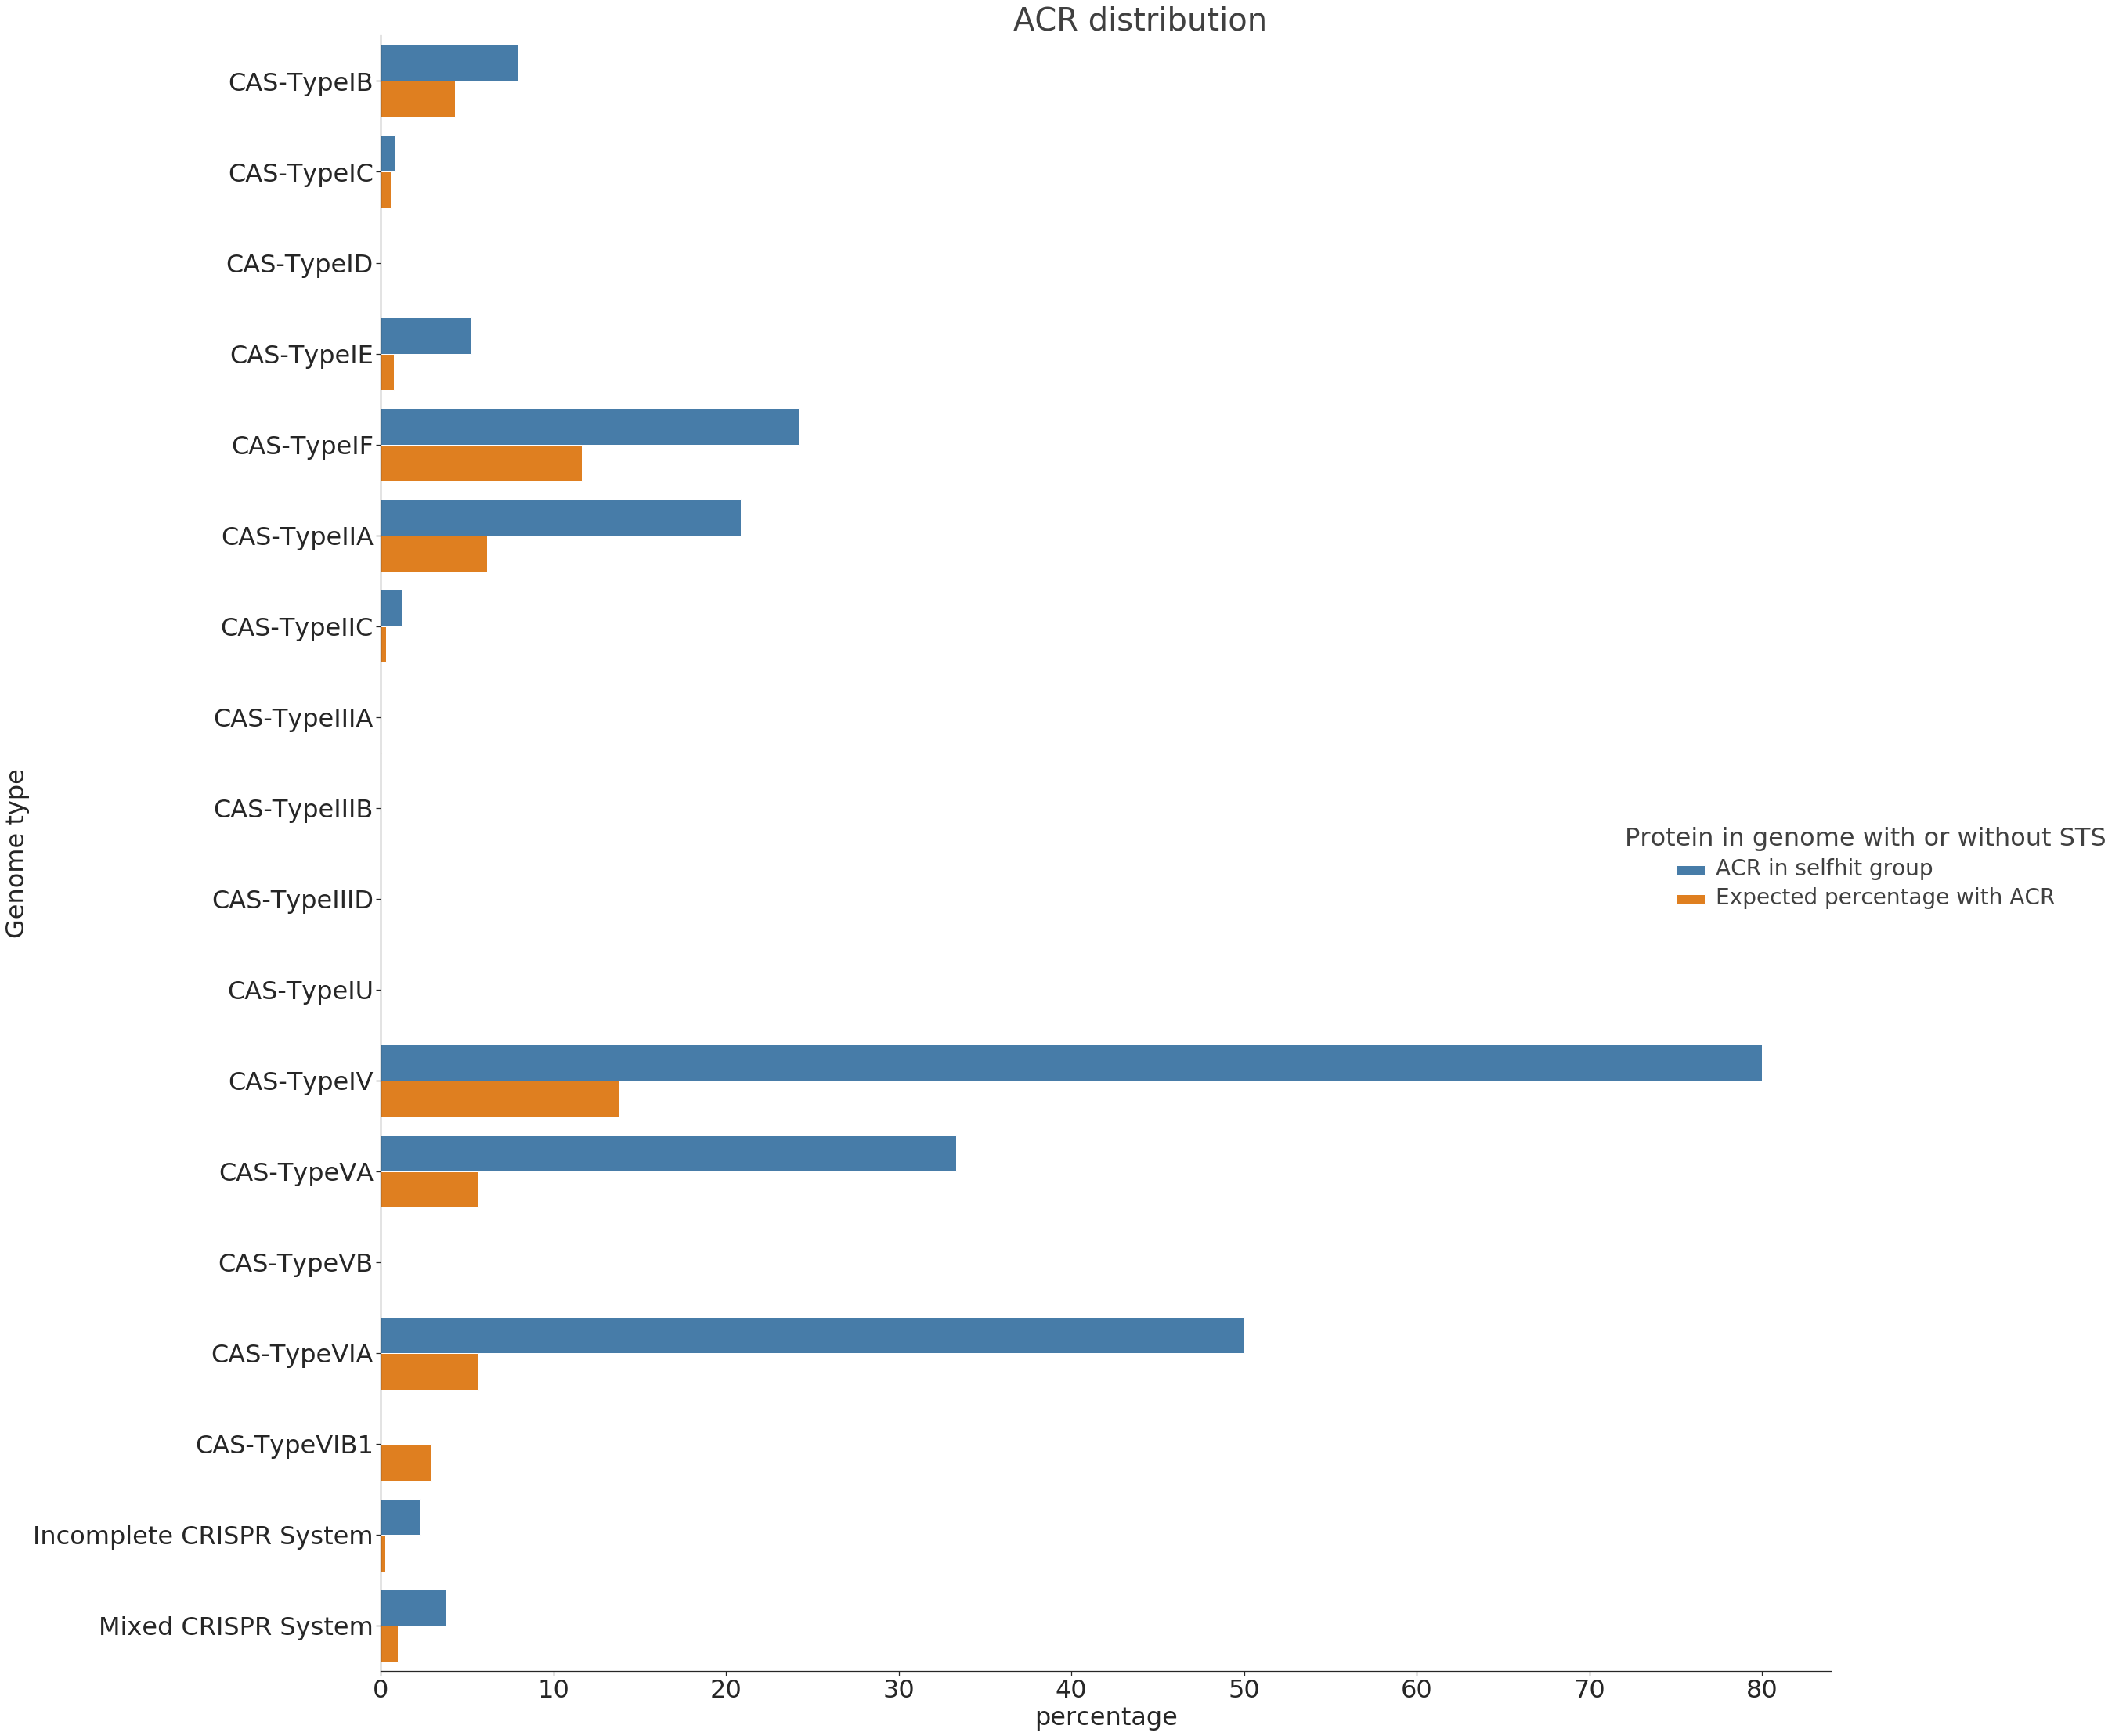

In [154]:
g = sns.catplot(
    data=prot_combi.query("~genome_type.str.contains('genes') and `Protein in genome with or without STS`.str.contains('ACR')"),
    y='genome_type', x='percentage', hue=kind, kind='bar', height=30, orient='h',
)
g.fig.suptitle("ACR distribution", fontsize=40, y=1.01)
g.set_ylabels("Genome type")
plt.setp(g._legend.get_title(), fontsize=32)
plt.setp(g._legend.get_texts(), fontsize=28)

increase_size_by(1, fontsize=32)
save_fig(g)

figure saved in /home/hielke/bep/figs/FINAL2/A55___Transposon_distribution.png


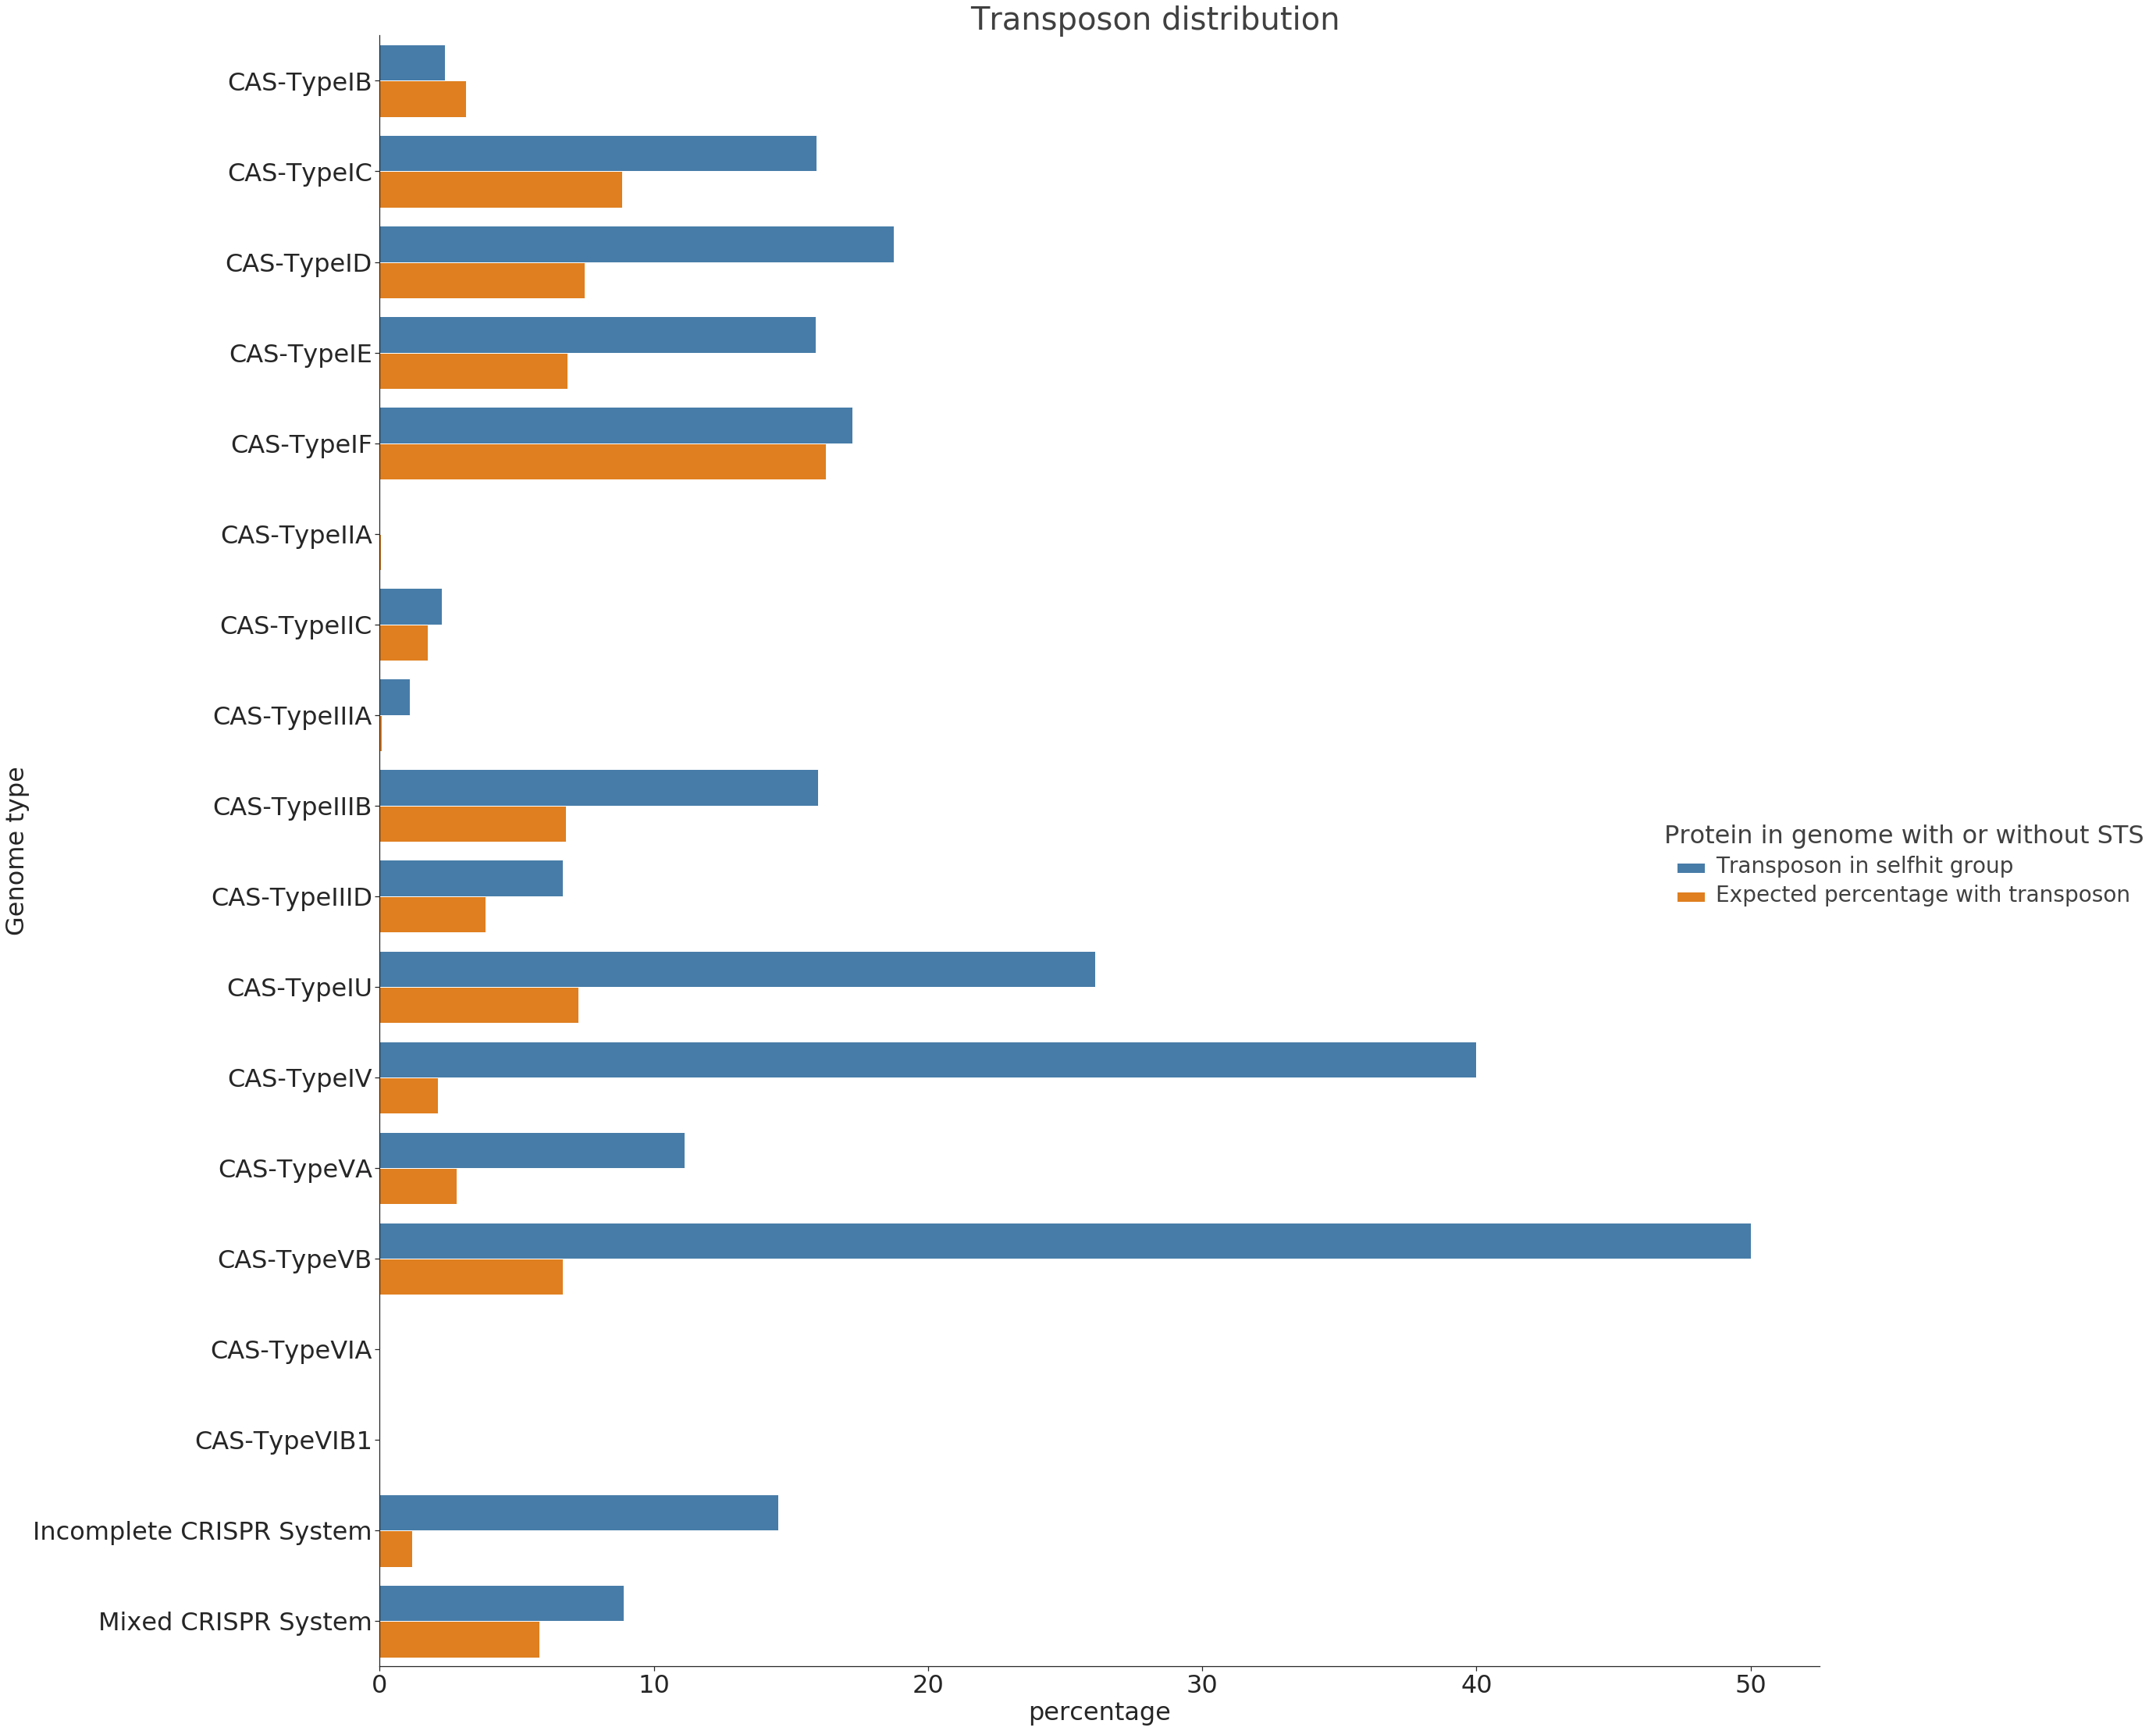

In [155]:
g = sns.catplot(
    data=prot_combi.query("~genome_type.str.contains('genes') and ~`Protein in genome with or without STS`.str.contains('ACR')"), 
    y='genome_type', x='percentage', hue=kind, kind='bar', height=30, orient='h',
)
g.fig.suptitle("Transposon distribution", fontsize=40, y=1.01)
g.set_ylabels("Genome type")
plt.setp(g._legend.get_title(), fontsize=32)
plt.setp(g._legend.get_texts(), fontsize=28)

increase_size_by(1, fontsize=32)
save_fig(g)

# PLOTTING

### Change what grouping to use for coming plots

In [51]:
custom = True
if custom:
    df_genome_type_count = dftyped_renamed_count
    all_genome_type_count = alltypes_renamed_count
all_genome_type_count

CAS-TypeIA                     135
CAS-TypeIB                    2341
CAS-TypeIC                    2384
CAS-TypeID                     107
CAS-TypeIE                   15342
CAS-TypeIF                    3390
CAS-TypeIU                     262
                                 0
CAS-TypeIIA                   2844
CAS-TypeIIB                    205
CAS-TypeIIC                   2983
                                 0
CAS-TypeIIIA                 10035
CAS-TypeIIIB                   250
CAS-TypeIIIC                    12
CAS-TypeIIID                   155
                                 0
CAS-TypeIV                     189
                                 0
CAS-TypeVA                      71
CAS-TypeVB                      15
                                 0
CAS-TypeVIA                     53
CAS-TypeVIB1                    34
                                 0
Cas-TypeVC | CAS-TypeVIB2        3
Mixed CRISPR System           2716
Incomplete CRISPR System      5627
No CAS genes        

Print some general info about the size of each group.

In [52]:
def print_info(df):
    for identity_hit in [75, 90, 100]:
        q = 'hit_ident == 100' if identity_hit == 100 else 'hit_ident > @identity_hit'
        print(
            "Total STS/genomes with STS (>%d): %d / %d" % (
                identity_hit, 
                len(df.query(q)),
                len(set(df.query(q).index))
            )
        )
        
print_info(df_all)

Total STS/genomes with STS (>75): 174052 / 21538
Total STS/genomes with STS (>90): 23626 / 8466
Total STS/genomes with STS (>100): 12121 / 5759


### Actual plots
Now we finally can start plotting!

Percentage of genomes with no CAS genes: 55.5 %
figure saved in /home/hielke/bep/figs/FINAL2/A2___Distribution_of_types_of_all_genomes,_excluding_no_cas_genes_(44.5_%)).png
figure saved in /home/hielke/bep/figs/FINAL2/A3___Distribution_of_types_of_all_genomes,_excluding_no_cas_genes_(44.5_%)).svg
figure saved in /home/hielke/bep/figs/FINAL2/A4___Distribution_of_the_other_genomes_crispr_type_(1.1_%).png
figure saved in /home/hielke/bep/figs/FINAL2/A5___Distribution_of_the_other_genomes_crispr_type_(1.1_%).svg


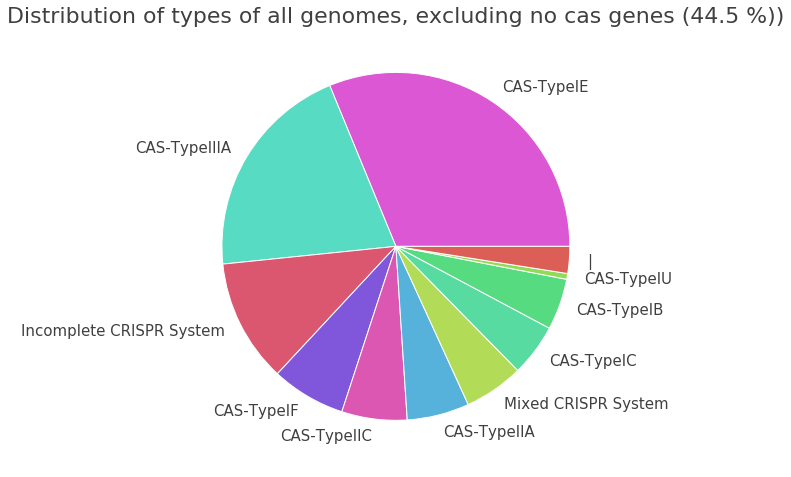

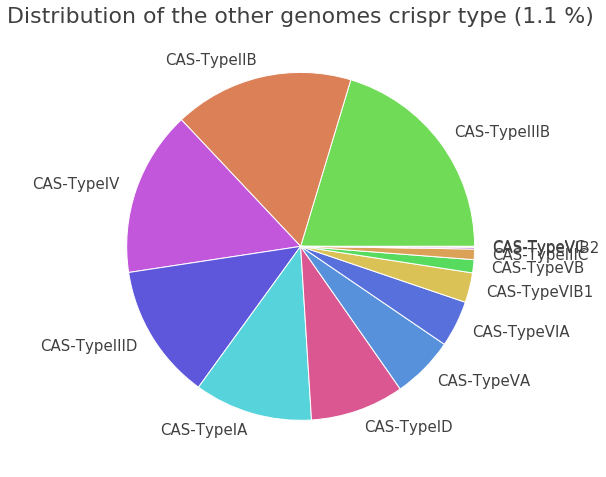

In [53]:
# df_genome_type_count_subsection = df_genome_type_count[df_genome_type_count.index != NOCAS]
# all_genome_type_count_subsection = all_genome_type_count[all_genome_type_count.index != NOCAS]

def palette_2_map(palette):
    return mpl.colors.ListedColormap(sns.color_palette(palette).as_hex())

nocas_perc = all_genome_type_count.get(NOCAS, 0) / all_genome_type_count.sum()
print("Percentage of genomes with no CAS genes: %.1f %%" % (100.0 * nocas_perc))

sorted_genomes = alltypes_renamed_count_no_other.pipe(
    lambda d:
    d[(d != 0) & (d.index != NOCAS)].sort_values(ascending=False)
)

# Here the split between the two circle diagrams is made.
split_on = "CAS-TypeIU"
others = sorted_genomes.loc[split_on:]
others = others.iloc[1:]  # remove split_on itself (pandas implements unlogical slicing)
largest = sorted_genomes.loc[:split_on].append(pd.Series([others.sum()], index=['|']))
colors_num = len(sorted_genomes) + 1
import random
random.seed(1)
colors_map  = sns.color_palette("hls", n_colors=colors_num)
random.shuffle(colors_map)
split_num = len(largest)
ax = largest.plot.pie(legend=False, colormap=palette_2_map(colors_map[:split_num]))
# others.plot.pie(legend=False)


# ax = sorted_genomes.plot.pie(legend=False)
# plt.legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)
increase_figsize(2, plt)
ax.set_ylabel("")
ax.set_title("Distribution of types of all genomes, excluding no cas genes (%.1f %%))" % (100 - 100 * nocas_perc))
save_fig()
save_fig(format='svg')
# ----
fig, ax = plt.subplots()
# others.rename(index={'other': ''}, inplace=True)
others.plot.pie(legend=False, ax=ax, colormap=palette_2_map(colors_map[split_num:]))
increase_figsize(2, plt)
ax.set_ylabel("")
ax.set_title("Distribution of the other genomes crispr type (%.1f %%)" 
             % (100 * others.sum() / all_genome_type_count.sum()))
save_fig()
save_fig(format='svg')

In [54]:
# ax = sns.countplot(x='spacer_size', data=df, color=cbf[0], saturation=100)
# # increase_figsize(3, plt)

# sns.despine()
# every_nth = 5
# for n, label in enumerate(ax.xaxis.get_ticklabels()):
#     if (n-1) % every_nth != 0:
#         label.set_visible(False)
# # ax.set_yscale('log')
# plt.title("Spacer size (all spacer hits)" + title_mod)
# plSize = plt.gcf().get_size_inches()
# plt.gcf().set_size_inches( (plSize[0]*1, plSize[1]*2) )
# if save:
#     second_order += 1
#     plt.savefig(fig_folder + first_order + str(second_order) + ax.get_title().replace(" ", "_") + ".png", format='png', bbox_inches='tight')

## Histogram of spacer size

figure saved in /home/hielke/bep/figs/FINAL2/A6___Spacer_size_of_unique_STS_(TypeIII)_(hit_identity:_>90%)_(N=20019).png


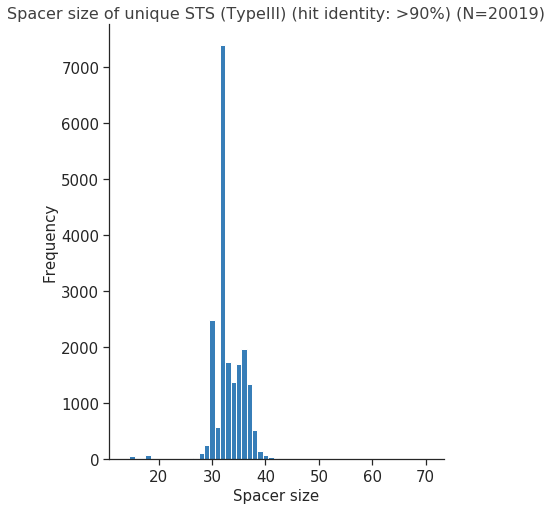

In [55]:
# Making a hist plot so that each bin is equal to that exact integer. 
# (So each bin is e.g. 4.5-5.5 so that all 5 size is captured there)
def plot(d):
    ax = d.pipe(
        lambda df: df['spacer_size'].hist(
            bins=list(map(.5 .__rsub__, range(df['spacer_size'].min(), df['spacer_size'].max() + 2)))
        )
    )
    return ax, len(d)
ax, N = plot(df_uni)
sns.despine()
ax.grid(False)
plSize = plt.gcf().get_size_inches()
plt.gcf().set_size_inches((plSize[0]*1, plSize[1]*2))
# ax.set_yscale('log')
plt.title("Spacer size of unique STS (TypeIII) (hit identity: %s) (N=%d)" % (perc_ident + title_mod, N), fontsize=16)
plt.xlabel("Spacer size")
plt.ylabel("Frequency")
save_fig()

figure saved in /home/hielke/bep/figs/FINAL2/A7___Distribution_of_array_size_of_all_unique_STS_(hit_identity:_>90%).png


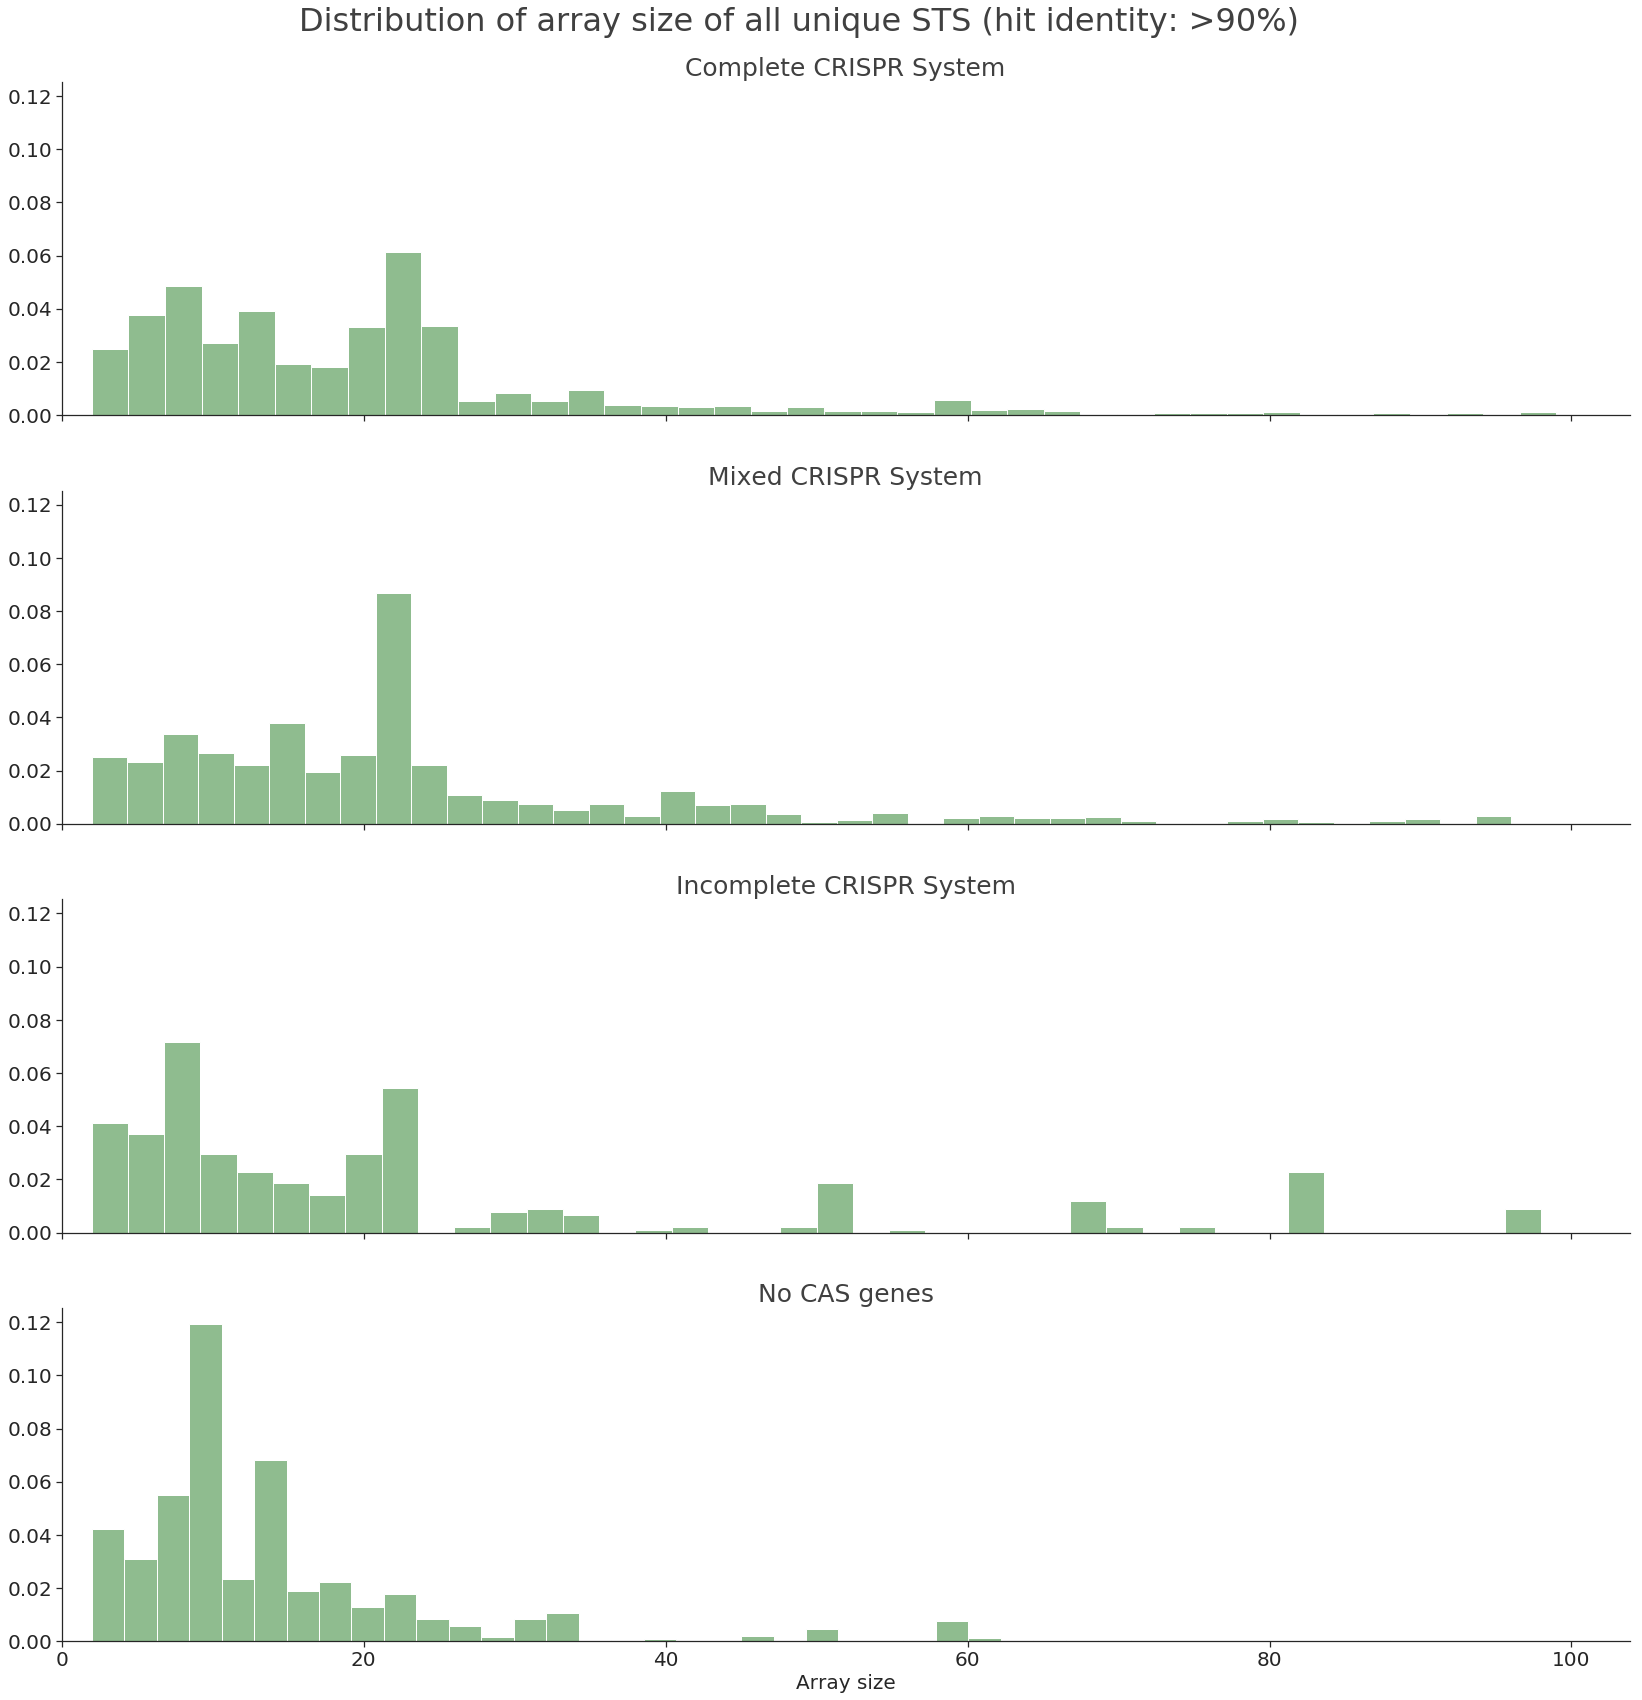

In [56]:
top_level_order = [Complete, Mixed, Incomplete, NOCAS]  # Order to plot each group in.

g = sns.FacetGrid(df_uni.query('array_size < 100'), row='top_level_group', aspect=4, row_order=top_level_order) 
g = g.map(plt.hist, 'array_size', density=True, color='darkseagreen', bins=40)
g.fig.suptitle("Distribution of array size of all unique STS (hit identity: %s)" % perc_ident, fontsize=32, y=1.01)
# ax.set_yscale('log')
plt.xlabel('Array size')
for ax in g.axes.flat:
    ax.set_xlim(left=0)
increase_size_by(2, 20)
g.set_titles(row_template="{row_name}", size=25)
save_fig(g)

figure saved in /home/hielke/bep/figs/FINAL2/A8___Distribution_of_the_totals_of_unique_STSs_in_a_genome_(hit_identity:_>90%).png


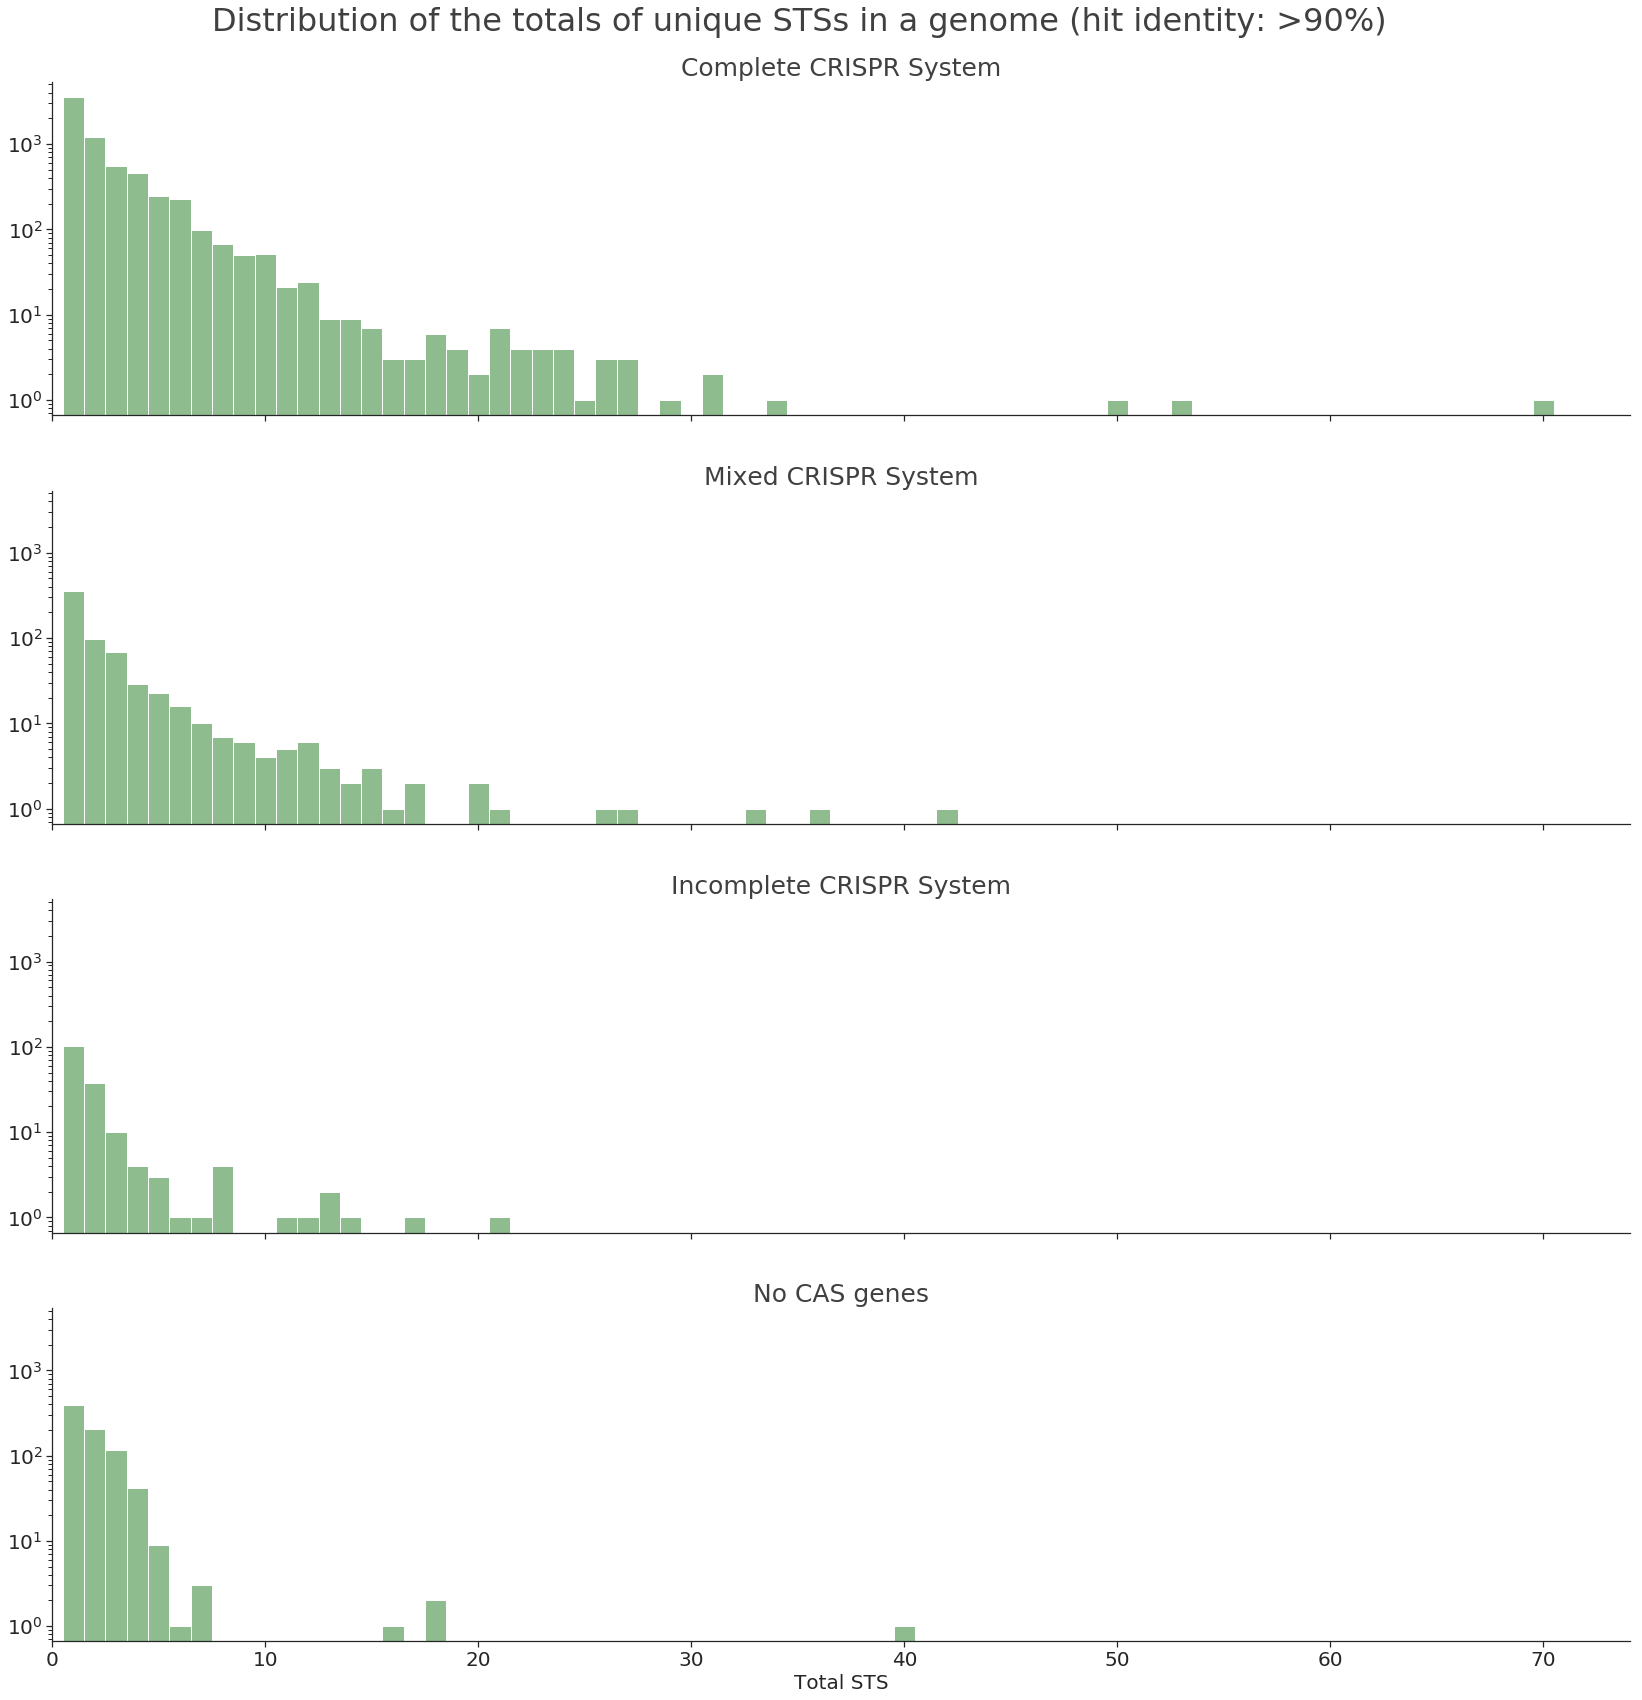

In [57]:
df_hitcount = df_uni.pipe(
    lambda df:
    df.groupby(by='genome_id').agg('first')
    .assign(
        genome_count_hit=df.groupby(by='genome_id')['array_id'].agg('count')
    )
)

g = sns.FacetGrid(df_hitcount, row='top_level_group', aspect=4, row_order=top_level_order) 
g = g.map(plt.hist, 'genome_count_hit', density=False, color='darkseagreen', 
          bins=list(map(.5 .__rsub__, range(0, df_hitcount['genome_count_hit'].max() + 2)))
         )

g.fig.suptitle("Distribution of the totals of unique STSs in a genome (hit identity: %s)" % perc_ident, fontsize=32, y=1.01)
plt.xlabel('Total STS')
g.set(yscale='log')
for ax in g.axes.flat:
    ax.set_xlim(left=0, )
increase_size_by(2, 20)
g.set_titles(row_template="{row_name}", size=25)
save_fig(g)

In [58]:
# df_hitcount.query('(genome_count_hit > 10) & (genome_type == "CAS-TypeIC")').pipe(
#     lambda d: d.empty or
#     d[d.index.str.contains("64187")]
# )

## Plots on type level

In [59]:
all_genome_type_count[all_genome_type_count.index != NOCAS]

CAS-TypeIA                     135
CAS-TypeIB                    2341
CAS-TypeIC                    2384
CAS-TypeID                     107
CAS-TypeIE                   15342
CAS-TypeIF                    3390
CAS-TypeIU                     262
                                 0
CAS-TypeIIA                   2844
CAS-TypeIIB                    205
CAS-TypeIIC                   2983
                                 0
CAS-TypeIIIA                 10035
CAS-TypeIIIB                   250
CAS-TypeIIIC                    12
CAS-TypeIIID                   155
                                 0
CAS-TypeIV                     189
                                 0
CAS-TypeVA                      71
CAS-TypeVB                      15
                                 0
CAS-TypeVIA                     53
CAS-TypeVIB1                    34
                                 0
Cas-TypeVC | CAS-TypeVIB2        3
Mixed CRISPR System           2716
Incomplete CRISPR System      5627
dtype: int64

figure saved in /home/hielke/bep/figs/FINAL2/A9___Genomes_with_STSs_grouped_for_each_type.png


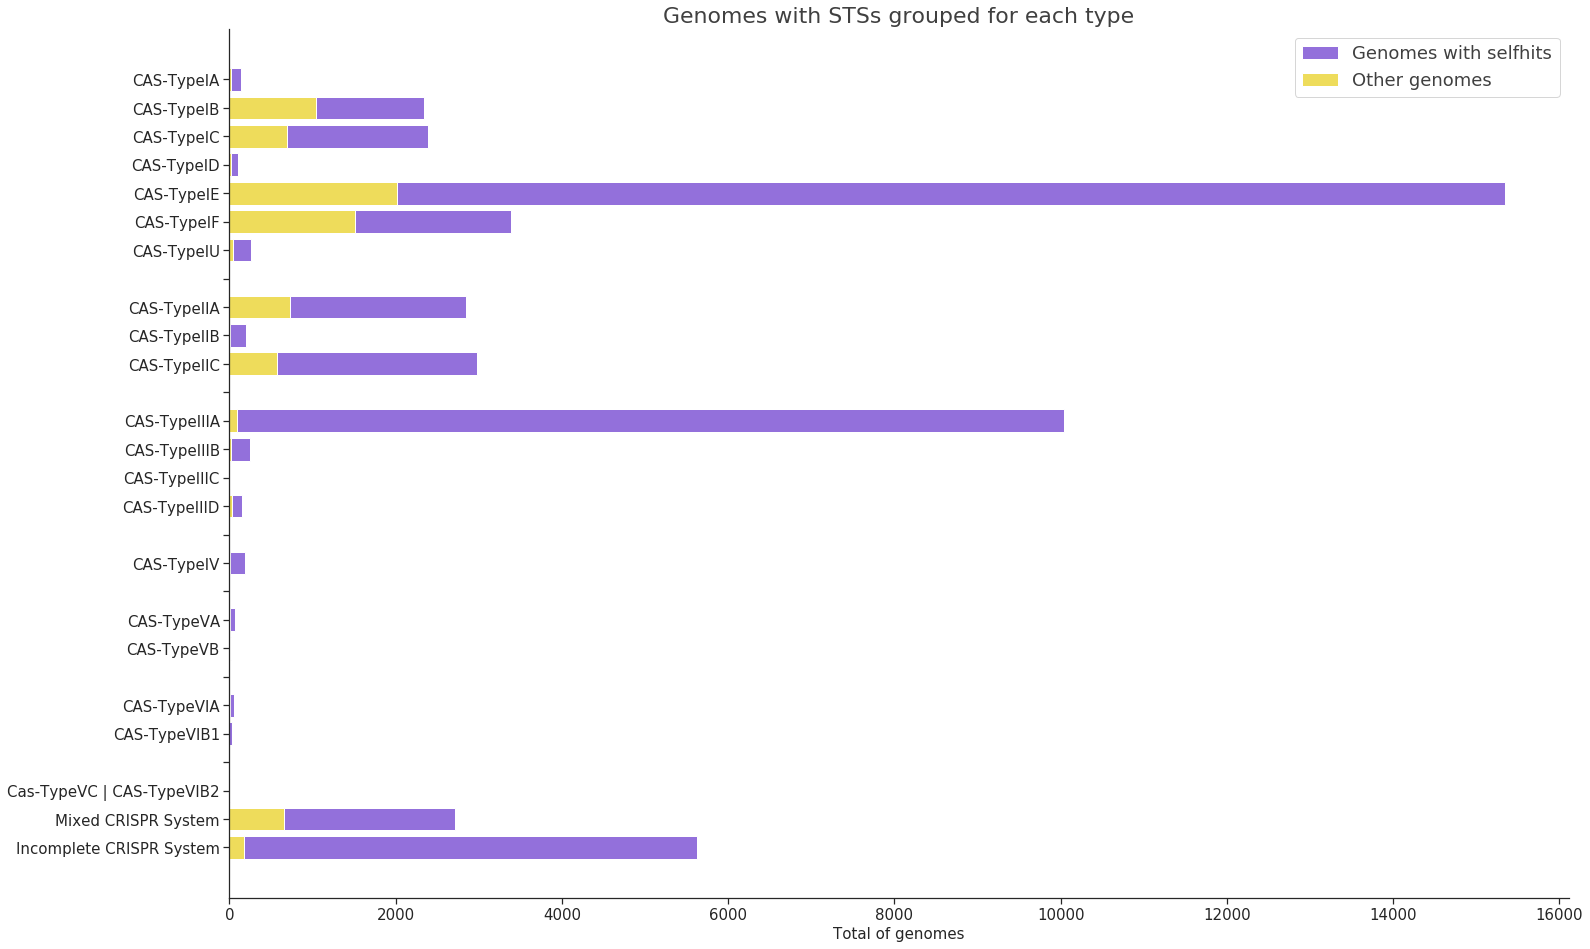

In [60]:
# Remove the NOCAS since that would make the other bars almost disappear
df_genome_type_count_subsection = df_genome_type_count[df_genome_type_count.index != NOCAS]
all_genome_type_count_subsection = all_genome_type_count[all_genome_type_count.index != NOCAS]


N = len(df_genome_type_count_subsection)
ind = list(range(N))[::-1]

plt.barh(ind, all_genome_type_count_subsection, color='mediumpurple', )
ax = plt.barh(ind, df_genome_type_count_subsection, color=sns.xkcd_rgb["dull yellow"], )

plt.yticks(ind, df_genome_type_count_subsection.index)
plt.legend(['Genomes with selfhits', 'Other genomes'], loc='upper right')
plt.title("Genomes with STSs grouped for each type")
plt.xlabel("Total of genomes")
# plt.gca().set_xscale('log')
sns.despine()
increase_figsize(4, plt, )
save_fig()

In [61]:
df_hitcount.head()  # (df_uni)

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,array_ori,contigs,size,name,type,class,num_genes,new_type_group,top_level_group,genome_count_hit
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,AAGAGGCGATTAGTTGGCTATATGCAGCCTTT,45209,45178,JQGS01000037,8,JQGS01000093_1_8,100.000,32,53765,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CTTTTACTGA,3,2,2,RNA-,JQGS01000037_64,UNCLASSIFIED,0.318182,middle,mid,341,4040397,Leptospira alexanderi strain 56650,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,Complete CRISPR System,16
100053.5,CACATCCAACCCGAAGACTTGAGCATTCTTCA,1242,1273,JQGU01000091,22,JQGU01000025_1_22,100.000,32,16908,JQGU01000025_1,23,6.23,29,CAS-TypeIE,CAS-TypeIE,0,CTGGTTGGTG,3,NULL,0,RNA-,JQGU01000091_1,Protein of unknown function (DUF1564),0.954545,middle,mid,335,4044353,Leptospira alexanderi strain 56643,CAS-TypeIE,SingleUnknownExtra,8,CAS-TypeIE,Complete CRISPR System,2
100053.6,GAGGGAAAGAAATTTTTCAACCTTGAGATCAG,3063,3033,JQGV01000288,35,JQGV01000216_1_35,96.875,32,5252,JQGV01000216_1,51,6.26,29,CAS-TypeIE,CAS-TypeIE,0,TCGTTTTATC,3,NULL,0,RNA-,JQGV01000288_5,Protein of unknown function (DUF736),0.680000,middle,mid,368,4062692,Leptospira alexanderi strain 56640,CAS-TypeIE,SingleUnknownExtra,8,CAS-TypeIE,Complete CRISPR System,5
100053.7,AAAGAAGATTTTACGAGTGATCAAACGAACCCAATGGGA,1863,1825,JQGT01000196,15,JQGT01000117_1_15,100.000,39,12738,JQGT01000117_1,24,6.16,29,CAS-TypeIE,CAS-TypeIE,0,CGTATTCGGA,3,NULL,0,RNA-,JQGT01000196_2,SET domain,0.608696,middle,mid,337,4067564,Leptospira alexanderi strain 56159,CAS-TypeIE,SingleUnknownExtra,8,CAS-TypeIE,Complete CRISPR System,10
100053.8,AAAACAGGATGGATTTTGATTTAAAACCCTAACCACTGATTCCTAA...,146,200,JQGW01000033,3,JQGW01000031_1_3,98.180,55,75992,JQGW01000031_1,3,5.25,29,CAS-TypeIE,CAS-TypeIE,3,CCATCCAACC,3,NULL,0,INTERGENIC,NULL,NULL,1.000000,tail,tail,238,4060960,Leptospira alexanderi strain 56659,CAS-TypeIE,AccompaniedSingleUnknown,8,CAS-TypeIE,Complete CRISPR System,5


In [62]:
df_hitcount.groupby('new_type_group')['genome_count_hit'].mean().divide(4)

new_type_group
CAS-TypeIA                  0.805556
CAS-TypeIB                  0.647300
CAS-TypeIC                  0.854412
CAS-TypeID                  0.433333
CAS-TypeIE                  0.507976
CAS-TypeIF                  0.702099
CAS-TypeIIA                 0.616941
CAS-TypeIIB                 0.318182
CAS-TypeIIC                 0.444900
CAS-TypeIIIA                0.386111
CAS-TypeIIIB                0.347826
CAS-TypeIIIC                0.250000
CAS-TypeIIID                0.520000
CAS-TypeIU                  0.711111
CAS-TypeIV                  0.550000
CAS-TypeVA                  0.916667
CAS-TypeVB                  0.625000
CAS-TypeVIA                 0.625000
CAS-TypeVIB1                0.750000
Incomplete CRISPR System    0.568047
Mixed CRISPR System         0.702859
No CAS genes                0.479032
Name: genome_count_hit, dtype: float64

In [63]:
acr_df = acr_all.to_frame(name="acr_count").join(all_genome_type_count.to_frame(name="total_count")) \
        .fillna(0).astype({"total_count": int})

In [64]:
# acr_df.to_csv('/home/hielke/bep/export_to_franklin/acr.tsv', sep='\t', index_label='type')

figure saved in /home/hielke/bep/figs/FINAL2/A10___Genomes_with_STSs_normalized_for_type_abundance.png


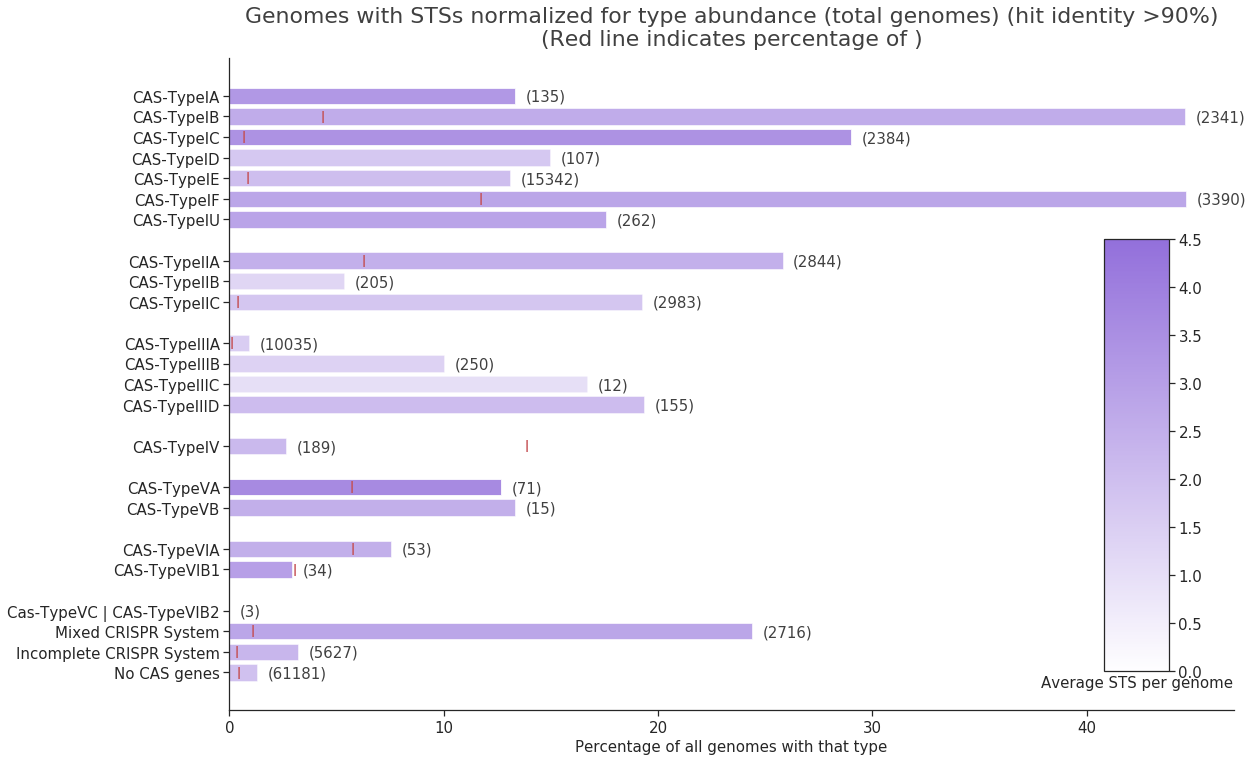

In [65]:
color="mediumpurple"

# Plot the relative size of genomes with at least one STS versus all the genomes.
value_counts_perc = [(p / w * 100) if p != 0 else 0 for p, w in zip(df_genome_type_count, all_genome_type_count)]
N = len(df_genome_type_count)
ind = list(range(N))[::-1]
fig, ax = plt.subplots()
bars = plt.barh(ind, value_counts_perc, color=color)
plt.yticks(ind, df_genome_type_count.index)
yticks = ax.yaxis.get_major_ticks()

# Transparancy indicates the average amount of selfhits per genome
max_val = 4.5  # The maximum number of average STS per genome. (Increase if required)
transparency_ticks = 256
alpha_values = df_hitcount.groupby('new_type_group')['genome_count_hit'].mean().divide(max_val).to_dict()
color = mpl.colors.to_rgba(color)

def create_colors(color, alpha):
    # Perform manual alpha blending, since matplotlib fails this
    # See https://stackoverflow.com/a/35672224/8477066
    color = [(1 - alpha) + alpha * c for c in color[:3]]
    return (*color, 1)

cmap = mpl.colors.ListedColormap([create_colors(color, alpha=(1+a)/transparency_ticks) for a in range(transparency_ticks)])
norm = mpl.colors.Normalize(vmin=0, vmax=max_val)
for i, (k, v) in enumerate(zip(all_genome_type_count.index, all_genome_type_count.values)):
    if v == 0:  # Remove ticks with no bar
        plt.setp(yticks[i], visible=False)
    else:
        # Set transparancy on the bars
        new_alpha = alpha_values.get(k)
        if new_alpha:
            assert new_alpha < 1, "The alpha is higher than 1, increase max_val."
            plt.setp(bars[i], alpha=new_alpha)
            
        acr = acr_all.get(k, None) or 0
#         acr = 0
            
        # Set value of the absolutet number of genomes of that group.
#         print(value_counts_perc[i], ind[i])
        ax.text(value_counts_perc[i]+0.5, ind[i]-0.25, '(%.0f)' % (v), color='0.25', fontsize=15)
        perc_acr = (acr / v * 100)
        if acr != 0:
            ax.text(perc_acr, ind[i]-.25, 'l', color='r', fontsize=15)
#         print(k, ind[i])
#         if perc_acr > 0.1:
#             y_size = .01
#             x_size = .1
#             x = perc_acr
#             y = ind[i]
#             ax.axvspan(ymax=y+y_size, ymin=y-y_size, xmax=x+x_size, xmin=x-x_size, facecolor='r')
            
        
#         if i==27:
#             print(ind[i], perc_acr)
#             ax.axvspan(ymax=ind[i] + y_size, ymin=ind[i] - y_size, xmin=perc_acr-.1, xmax=perc_acr+.1, facecolor='r')

# y_size = .01

# y = 6/28
# x = 10

plt.title("Genomes with STSs normalized for type abundance (total genomes) (hit identity %s)" % perc_ident +
          "\n(Red line indicates percentage of )", y=1.01)
plt.xlabel("Percentage of all genomes with that type")

cax = fig.add_axes([0.8, 0.17, 0.05, 0.5])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical', 
                                 drawedges=False,
                                )
cbar.solids.set_edgecolor('face')
cbar.solids.set_rasterized(True)
plt.xlabel("Average STS per genome")


sns.despine()
increase_figsize(3)
save_fig(title="Genomes with STSs normalized for type abundance")

## Phage hit

In [66]:
df_phage_retyped = df.pipe(
    lambda df:
    df.groupby(by='genome_id').first()
    .assign(
        phage_perc=df.groupby(by='genome_id')['with_phage'].agg(lambda x: sum(x==2)/len(x))
    )
)
df_phage_retyped.head()

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,array_ori,contigs,size,name,type,class,num_genes,new_type_group,top_level_group,phage_perc
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,AACTTCTTCTCCGTGGATTTCGTCGTCACCAT,10514,10484,JQGS01000075,2,JQGS01000093_1_2,96.875,32,17127,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CCTTTATGGA,3,3,2,RNA+,JQGS01000075_22,UNCLASSIFIED,0.045455,middle,mid,341,4040397,Leptospira alexanderi strain 56650,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,Complete CRISPR System,0.833333
100053.5,CACATCCAACCCGAAGACTTGAGCATTCTTCA,1242,1273,JQGU01000091,22,JQGU01000025_1_22,100.000,32,16908,JQGU01000025_1,23,6.23,29,CAS-TypeIE,CAS-TypeIE,0,CTGGTTGGTG,3,NULL,0,RNA-,JQGU01000091_1,Protein of unknown function (DUF1564),0.954545,middle,mid,335,4044353,Leptospira alexanderi strain 56643,CAS-TypeIE,SingleUnknownExtra,8,CAS-TypeIE,Complete CRISPR System,0.000000
100053.6,GAGACAGATTCGAAGGAAACTTCAAAGACGAC,11287,11256,JQGV01000052,38,JQGV01000216_1_38,100.000,32,18548,JQGV01000216_1,51,6.26,29,CAS-TypeIE,CAS-TypeIE,0,CGTTCTTATA,3,NULL,0,RNA-,JQGV01000052_10,MORN motif,0.740000,middle,mid,368,4062692,Leptospira alexanderi strain 56640,CAS-TypeIE,SingleUnknownExtra,8,CAS-TypeIE,Complete CRISPR System,0.333333
100053.7,AAAACAGAATGGATTTTGACTTAAAACCCTAACCACTAATTCCTAA...,5644,5589,JQGT01000055,24,JQGT01000117_1_24,91.070,56,5671,JQGT01000117_1,24,6.16,29,CAS-TypeIE,CAS-TypeIE,3,CCATTCAACC,3,NULL,0,INTERGENIC,NULL,NULL,1.000000,tail,tail,337,4067564,Leptospira alexanderi strain 56159,CAS-TypeIE,SingleUnknownExtra,8,CAS-TypeIE,Complete CRISPR System,0.117647
100053.8,AAAACAGGATGGATTTTGATTTAAAACCCTAACCACTGATTCCTAA...,146,200,JQGW01000033,3,JQGW01000031_1_3,98.180,55,75992,JQGW01000031_1,3,5.25,29,CAS-TypeIE,CAS-TypeIE,3,CCATCCAACC,3,NULL,0,INTERGENIC,NULL,NULL,1.000000,tail,tail,238,4060960,Leptospira alexanderi strain 56659,CAS-TypeIE,AccompaniedSingleUnknown,8,CAS-TypeIE,Complete CRISPR System,0.000000


In [74]:
total_phage_STS = len(df.query("with_phage == 2"))
total_STS = len(df)
print("The total percentage of STS hitting a phage: %.2f%%." % (total_phage_STS / total_STS * 100))
#====
phage_genome_id = set(df_phages.index)
sts_genome_id = set(df.index)
crispr_genome_id = set(df_crispr.index)
transposon_genome_id = set(df_tn.index)
print("Total genomes having a STS with a (pro)phage: %s" % len(sts_genome_id & phage_genome_id))
print("Total genomes having a STS without a (pro)phage: %s" % len(sts_genome_id - phage_genome_id))
print("Percentage of genomes with a (pro)phage not having STS: %.2f%%" 
      % (len(phage_genome_id - sts_genome_id) / total_genomes * 100))
# print("The total number of phage DNA is %s" %)
#====
print("====")
print("Percentage of genomes with a transposon: %.2f%%" % (len(transposon_genome_id) / total_genomes * 100))
print("Percentage of genomes with STS that have a transposon: %.2f%%" 
      % (len(sts_genome_id & transposon_genome_id) / total_genomes * 100))
print("Percentage of genomes without STS, but with CRISPR array, that have a transposon: %.2f%%" 
      % (len((crispr_genome_id - sts_genome_id) & transposon_genome_id) / total_genomes * 100)) 
print("Percentage of genomes without STS, but with CRISPR array, that have a (pro)phage: %.2f%%"
     % (len((crispr_genome_id - sts_genome_id) & phage_genome_id) / total_genomes * 100))

The total percentage of STS hitting a phage: 57.86%.
Total genomes having a STS with a (pro)phage: 8203
Total genomes having a STS without a (pro)phage: 263
Percentage of genomes with a (pro)phage not having STS: 82.23%
====
Percentage of genomes with a transposon: 2.40%
Percentage of genomes with STS that have a transposon: 0.93%
Percentage of genomes without STS, but with CRISPR array, that have a transposon: 1.39%
Percentage of genomes without STS, but with CRISPR array, that have a (pro)phage: 28.53%


In [80]:
phages_typed = df_phages.join(df_genome_class, how='left')

In [81]:
phages_typed.head()

,contig,phage_group,s,e,gene_start,gene_end,type,class,num_genes,new_type_group
genome_id,,,,,,,,,,
100053.4,JQGS01000037,2,759.0,53763.0,3.0,72.0,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11.0,CAS-TypeIE
100053.4,JQGS01000016,3,99.0,20352.0,1.0,28.0,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11.0,CAS-TypeIE
100053.4,JQGS01000075,3,43.0,16638.0,2.0,26.0,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11.0,CAS-TypeIE
100053.4,JQGS01000146,3,476.0,11121.0,1.0,20.0,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11.0,CAS-TypeIE
100053.4,JQGS01000183,3,578.0,6034.0,2.0,13.0,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11.0,CAS-TypeIE


In [82]:
phages_typed.index.value_counts().mean()

6.432513570063984

figure saved in /home/hielke/bep/figs/FINAL2/A11___Mean_number_of_(pro)phages_per_type.png


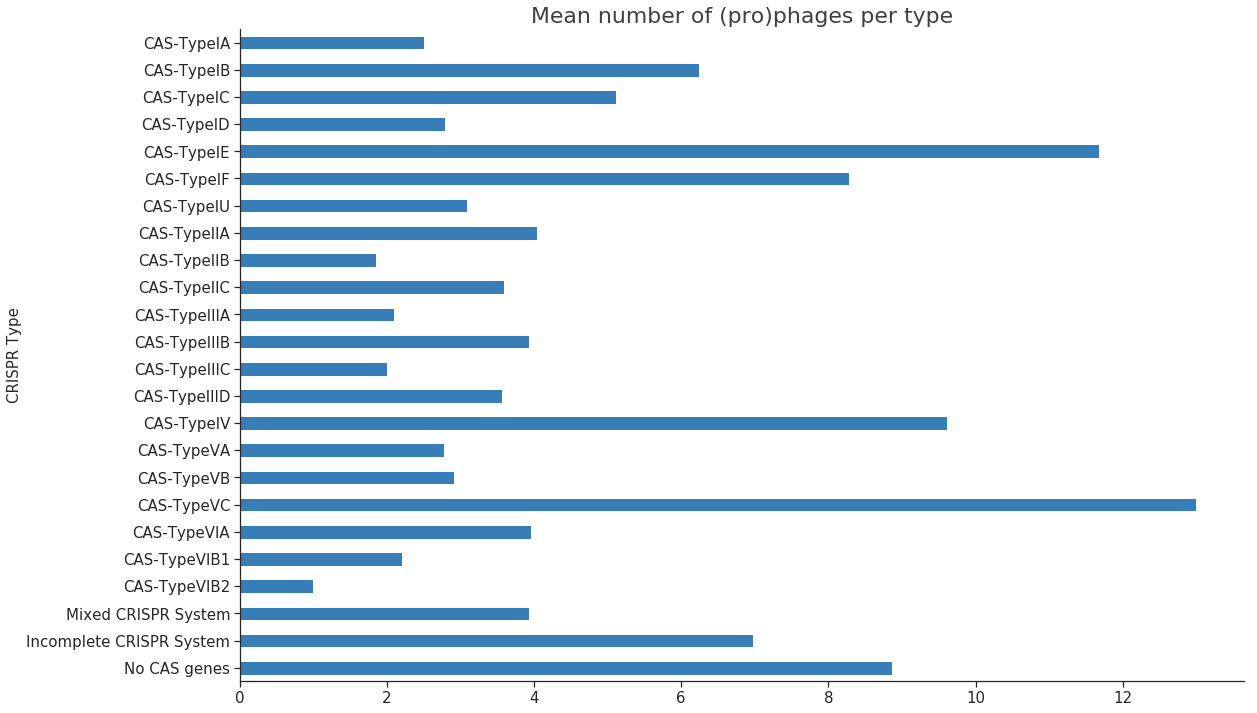

In [83]:
mean_phage_per_type = phages_typed.groupby(by='new_type_group').apply(lambda x: x.index.value_counts().mean())
mean_phage_per_type = mean_phage_per_type.pipe(crispr_order)
mean_phage_per_type.plot.barh(cmap=cbf_map)
sns.despine()
plt.title("Mean number of (pro)phages per type")
plt.ylabel("CRISPR Type")
# plt.legend(['All STSs targeting (pro)phage', 'Some in (pro)phage, some not', 'All STSs targeting native DNA'],)
increase_figsize(3)
save_fig()

Code below raises warning, but can't be fixed because of: 

https://github.com/pandas-dev/pandas/issues/18366

Check this link when the code below breaks to see the alternative syntax implemented in the pull request that will close the issue. 

/home/hielke/pydev/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


figure saved in /home/hielke/bep/figs/FINAL2/A12___Genomes_selfhits_in_(pro)phage_or_not_(hit_identity:_>90%).png


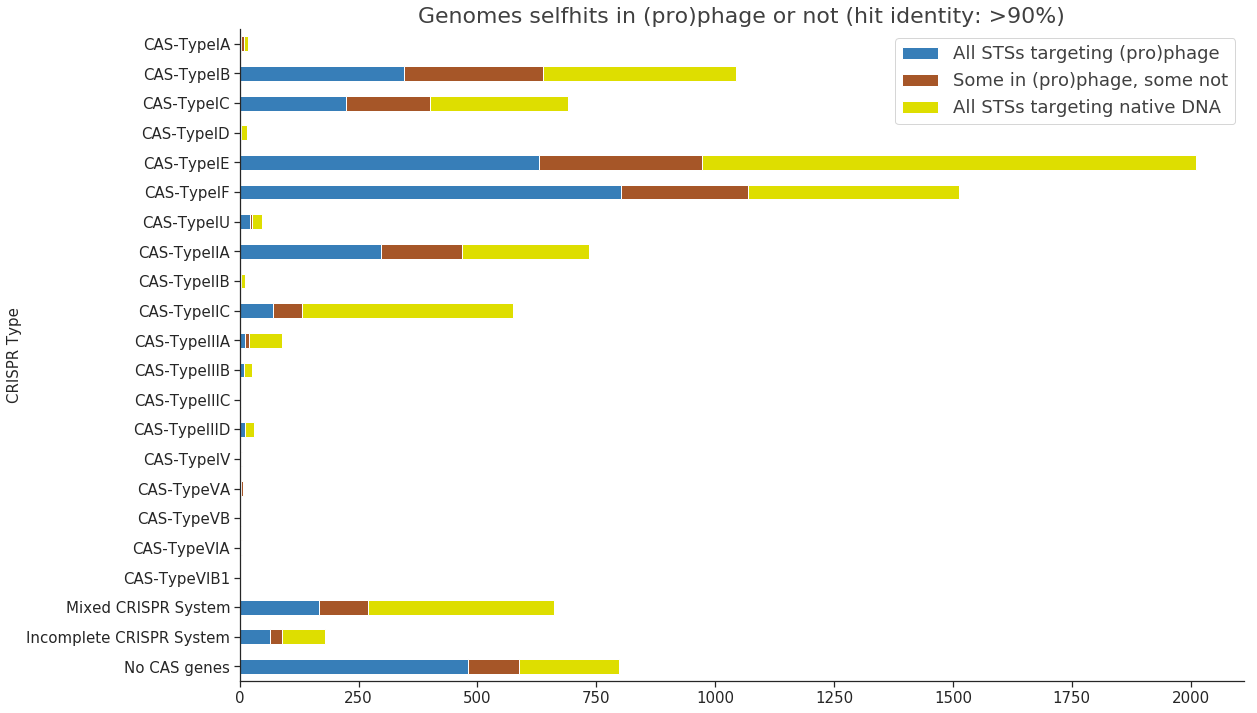

In [84]:
# The phage percentage is used to make the three groups. 
#     all_phage_hit: 1
#     inbetween: count - (all_phage_hit) - (no_phage_hit) (NB. This is done in the second code line)
#     no_phage_hit: 0
phage_hit_genome_level = df_phage_retyped.groupby("new_type_group")['phage_perc'].agg({
    "all_phage_hit": lambda x: sum(x==1.0), 
    "inbetween": 'count', 
    "no_phage_hit": lambda x: sum(x==0.0),
})

phage_hit_genome_level['inbetween'] = (
    phage_hit_genome_level['inbetween'] 
    - phage_hit_genome_level['all_phage_hit']
    - phage_hit_genome_level['no_phage_hit']
)

phage_hit_genome_level = phage_hit_genome_level.reindex(sorted(
    phage_hit_genome_level.index, key=sort_groups, reverse=True))
phage_hit_genome_level[['all_phage_hit', 'inbetween', 'no_phage_hit']] \
    .plot.barh(stacked=True, cmap=cbf_map)
sns.despine()
plt.title("Genomes selfhits in (pro)phage or not (hit identity: %s)" % perc_ident)
plt.ylabel("CRISPR Type")
plt.legend(['All STSs targeting (pro)phage', 'Some in (pro)phage, some not', 'All STSs targeting native DNA'],)
increase_figsize(3)
save_fig()

figure saved in /home/hielke/bep/figs/FINAL2/A13___STSs_targeting_(pro)phage_normalized_for_type_abundance_in_selftargeting_genomes_(hit_identity:_>90%).png


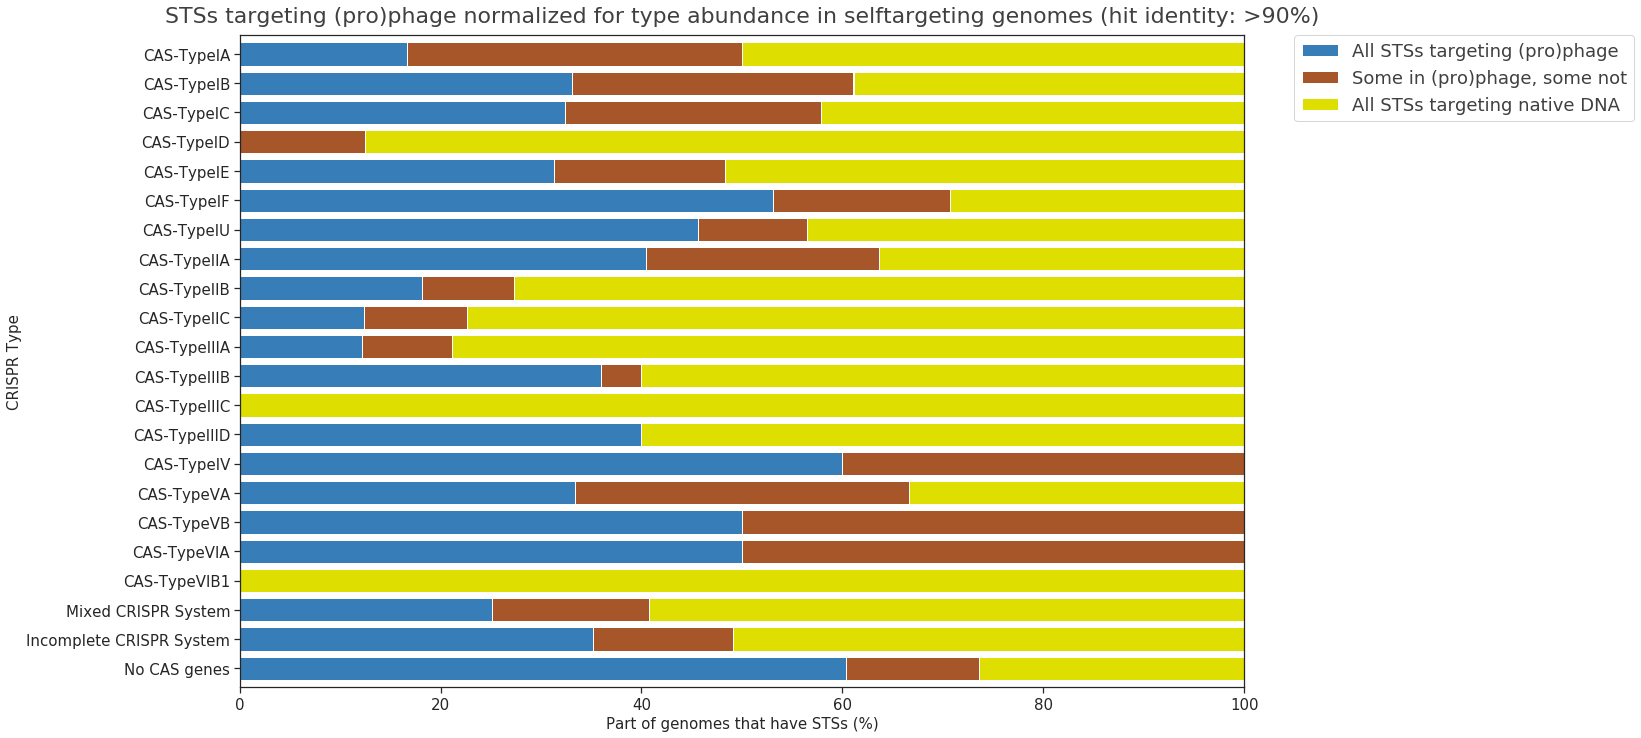

In [85]:
# Now we dived by the total of genomes in that group to have a relative scale.
phage_hit_genome_level_percentage = phage_hit_genome_level.div(phage_hit_genome_level.sum(axis=1), axis=0).mul(100)
ax = phage_hit_genome_level_percentage[['all_phage_hit', 'inbetween', 'no_phage_hit']] \
    .plot.barh(stacked=True, cmap=cbf_map, width=.8)
ax.legend(loc='center right',  shadow=True)
ax.set_xlim((0, 100))
plt.legend(['All STSs targeting (pro)phage', 'Some in (pro)phage, some not', 'All STSs targeting native DNA'], 
        bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("STSs targeting (pro)phage normalized for type abundance in selftargeting genomes (hit identity: %s)" 
          % perc_ident, y=1.01)
plt.ylabel("CRISPR Type")
plt.xlabel("Part of genomes that have STSs (%)")
increase_figsize(3)
save_fig()

## Origin of STS: Tail or head

Plot for: 
figure saved in /home/hielke/bep/figs/FINAL2/head_vs_tail_p_value_hit/A15___P-value_histogram_that_test_non-uniform_distribution_of_STSs.png


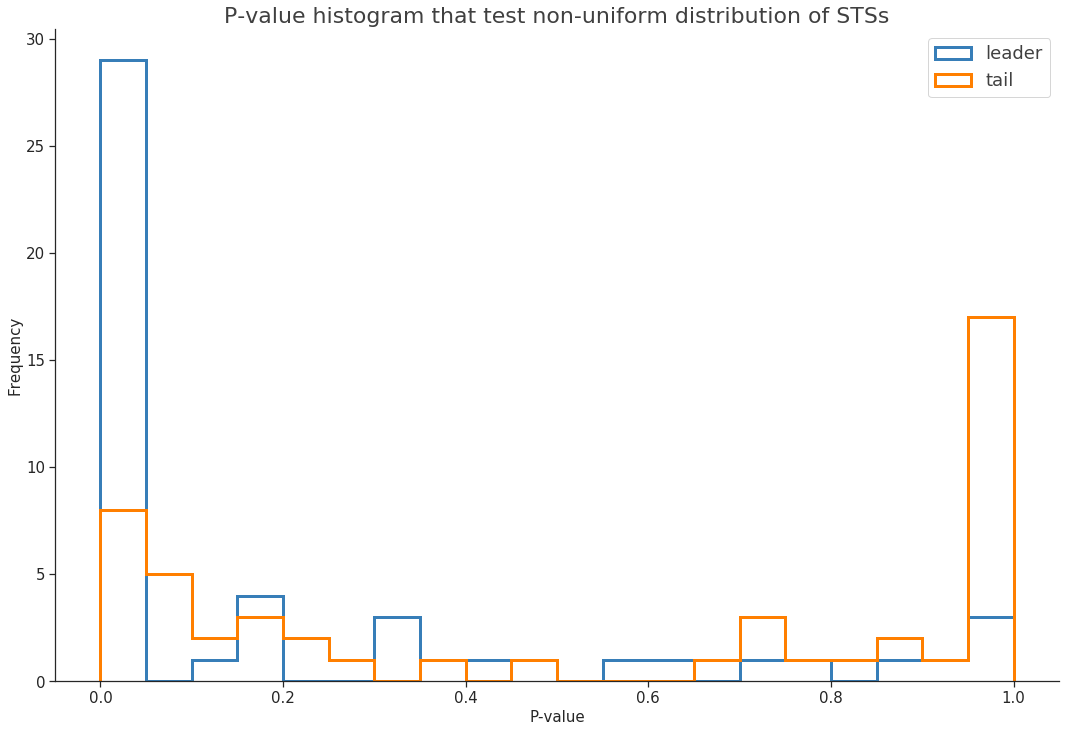

In [94]:
def test_chisquare(tester):
    """Return [leader, middle, tail]
    This test applies a chisquare test to see if the distribution is expected"""
    array_size = tester.name
    observed = [tester['leader'], tester['middle'], tester['tail']]
    expected = np.array([1, array_size - 2, 1]) / array_size * sum(observed)
    
    # Hypothesis test applied to each group individually
    p_vals = np.zeros(3)
    for i in range(3):
        mask = np.ones(3, np.bool)
        mask[i] = False
        obs = [observed[~mask][0], expected[mask].sum()]
        exp = [expected[~mask][0], expected[mask].sum()]
        _, p = stats.chisquare(f_obs=obs, f_exp=exp)
        p_vals[i] = p
    return p_vals

def test_binom_test(tester):
    """Return [leader, middle, tail]
    This test uses the binomial distribution as the expected distribution
    Advantage of this test is that we test a specific alternative hypothesis (as opposed to the test_chisquare)"""
    array_size = tester.name
    observed = tester[['leader', 'middle', 'tail']]
    n = observed.sum()
    chance = 1 / array_size
    # yields low values if higher than expected
    p_vals = [0] * 3
    for i in [0, 2]:  # Only relevant for leader and tail
        t = observed[i]
        p = stats.binom_test(t, n, chance, 
                             alternative='greater'
                            )
        p_vals[i] = p
    return p_vals

# Used for pivotting
x = 'name_spacer_pos'
hue = 'array_size'
y = 'count'

def build_p_value_hist(df, name_mod=""):
    print("Plot for: " + name_mod)
    p_vals = df.pipe(
        lambda d:
        d[x]
        .groupby(d[hue])
        .value_counts(normalize=False)
        .rename(y)
        .reset_index()

        # This is the important pivotting !!! --> Changes to groups of `'leader', 'middle', 'tail'`
        .pivot(index=hue, columns=x, values=y)

        .fillna(0)

        # Here we apply the test which for each group of `'leader', 'middle', 'tail'` 
        # the passed distribution is a possible one or impossible
        .apply(test_binom_test, axis=1, result_type='expand')

        .fillna(0.9)
        .pipe(lambda x: x.set_columns(x.columns.astype(str)))
        .rename({'0':'leader', '1':'middle', '2':'tail'}, axis='columns')
        .loc[2:50, :]  # Too small values afterwards for accurate p-value
    )
    # Only plot the histogram for leader and tail.
    ax = p_vals.drop('middle', axis=1).plot.hist(bins=20,
                                                 histtype="step", 
                                                 linewidth=3,
                                                 alpha=1)
    sns.despine()
    title = "P-value histogram that test non-uniform distribution of STSs" + (
            "(applied to each array size individually) " + name_mod if name_mod else "")
    plt.title(title)
    plt.xlabel("P-value")
    increase_figsize(3)
    save_fig(fig_folder=fig_folder + 'head_vs_tail_p_value_hit/')
    
build_p_value_hist(df)

# Observation:
# Unique values hit identity >75% gives a strong tail preference
# High identity hits (not excluding unique) give a strong leader preference

Plot for: CAS-TypeIA
figure saved in /home/hielke/bep/figs/FINAL2/head_vs_tail_p_value_hit/A16___P-value_histogram_that_test_non-uniform_distribution_of_STSs(applied_to_each_array_size_individually)_CAS-TypeIA.png
Plot for: CAS-TypeIB
figure saved in /home/hielke/bep/figs/FINAL2/head_vs_tail_p_value_hit/A17___P-value_histogram_that_test_non-uniform_distribution_of_STSs(applied_to_each_array_size_individually)_CAS-TypeIB.png
Plot for: CAS-TypeIC
figure saved in /home/hielke/bep/figs/FINAL2/head_vs_tail_p_value_hit/A18___P-value_histogram_that_test_non-uniform_distribution_of_STSs(applied_to_each_array_size_individually)_CAS-TypeIC.png
Plot for: CAS-TypeID
figure saved in /home/hielke/bep/figs/FINAL2/head_vs_tail_p_value_hit/A19___P-value_histogram_that_test_non-uniform_distribution_of_STSs(applied_to_each_array_size_individually)_CAS-TypeID.png
Plot for: CAS-TypeIE
figure saved in /home/hielke/bep/figs/FINAL2/head_vs_tail_p_value_hit/A20___P-value_histogram_that_test_non-uniform_distrib

/home/hielke/pydev/lib/python3.5/site-packages/pandas/core/series.py:1148: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/home/hielke/pydev/lib/python3.5/site-packages/scipy/stats/morestats.py:2428: RuntimeWarning: overflow encountered in long_scalars
  pval = distributions.binom.sf(x-1, n, p)


figure saved in /home/hielke/bep/figs/FINAL2/head_vs_tail_p_value_hit/A27___P-value_histogram_that_test_non-uniform_distribution_of_STSs(applied_to_each_array_size_individually)_CAS-TypeIIIC.png
Plot for: CAS-TypeIIID
figure saved in /home/hielke/bep/figs/FINAL2/head_vs_tail_p_value_hit/A28___P-value_histogram_that_test_non-uniform_distribution_of_STSs(applied_to_each_array_size_individually)_CAS-TypeIIID.png
Plot for: CAS-TypeIU
figure saved in /home/hielke/bep/figs/FINAL2/head_vs_tail_p_value_hit/A29___P-value_histogram_that_test_non-uniform_distribution_of_STSs(applied_to_each_array_size_individually)_CAS-TypeIU.png
Plot for: CAS-TypeIV
figure saved in /home/hielke/bep/figs/FINAL2/head_vs_tail_p_value_hit/A30___P-value_histogram_that_test_non-uniform_distribution_of_STSs(applied_to_each_array_size_individually)_CAS-TypeIV.png
Plot for: CAS-TypeVA
figure saved in /home/hielke/bep/figs/FINAL2/head_vs_tail_p_value_hit/A31___P-value_histogram_that_test_non-uniform_distribution_of_STSs(a

/home/hielke/pydev/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


figure saved in /home/hielke/bep/figs/FINAL2/head_vs_tail_p_value_hit/A36___P-value_histogram_that_test_non-uniform_distribution_of_STSs(applied_to_each_array_size_individually)_Mixed_CRISPR_System.png
Plot for: No CAS genes
figure saved in /home/hielke/bep/figs/FINAL2/head_vs_tail_p_value_hit/A37___P-value_histogram_that_test_non-uniform_distribution_of_STSs(applied_to_each_array_size_individually)_No_CAS_genes.png


""


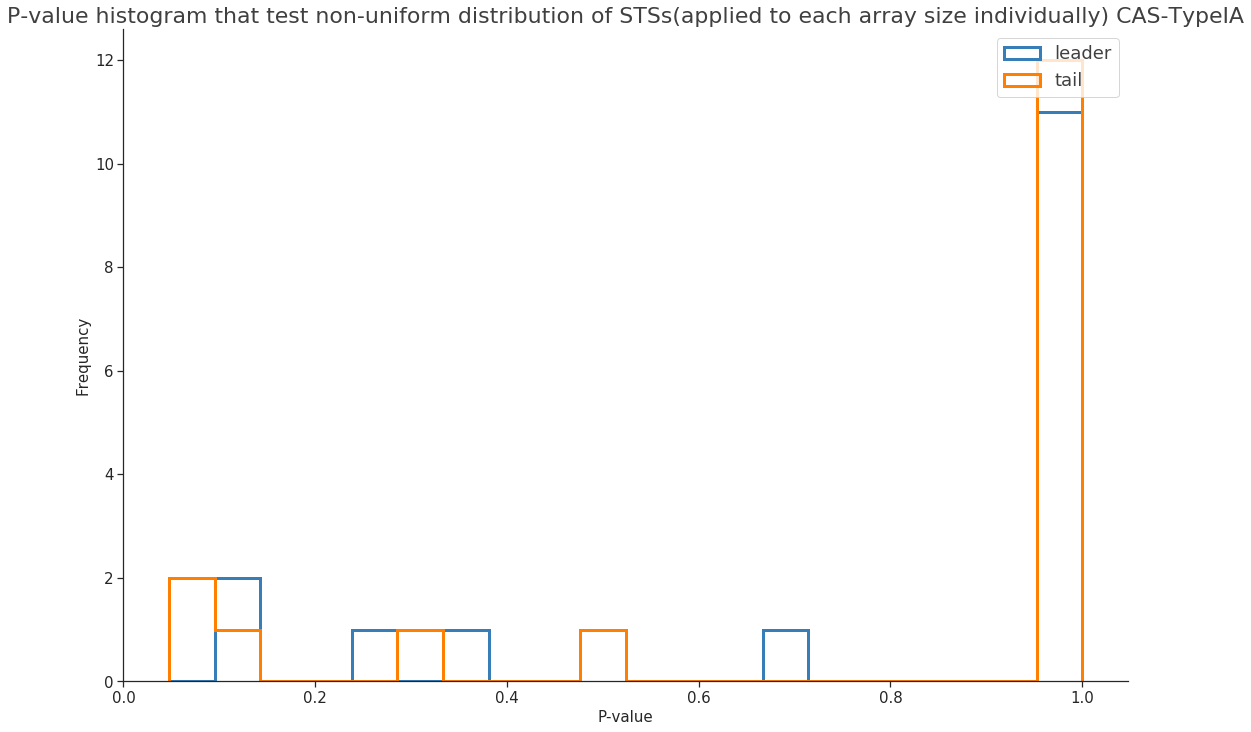

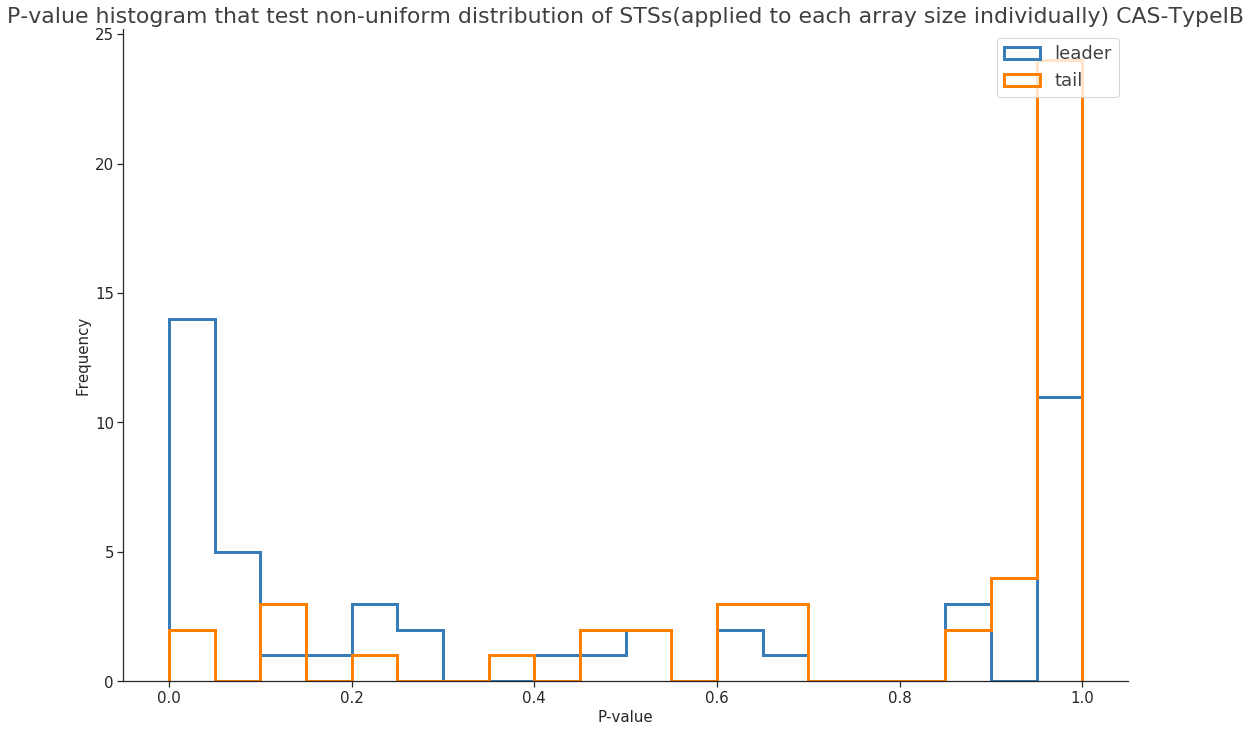

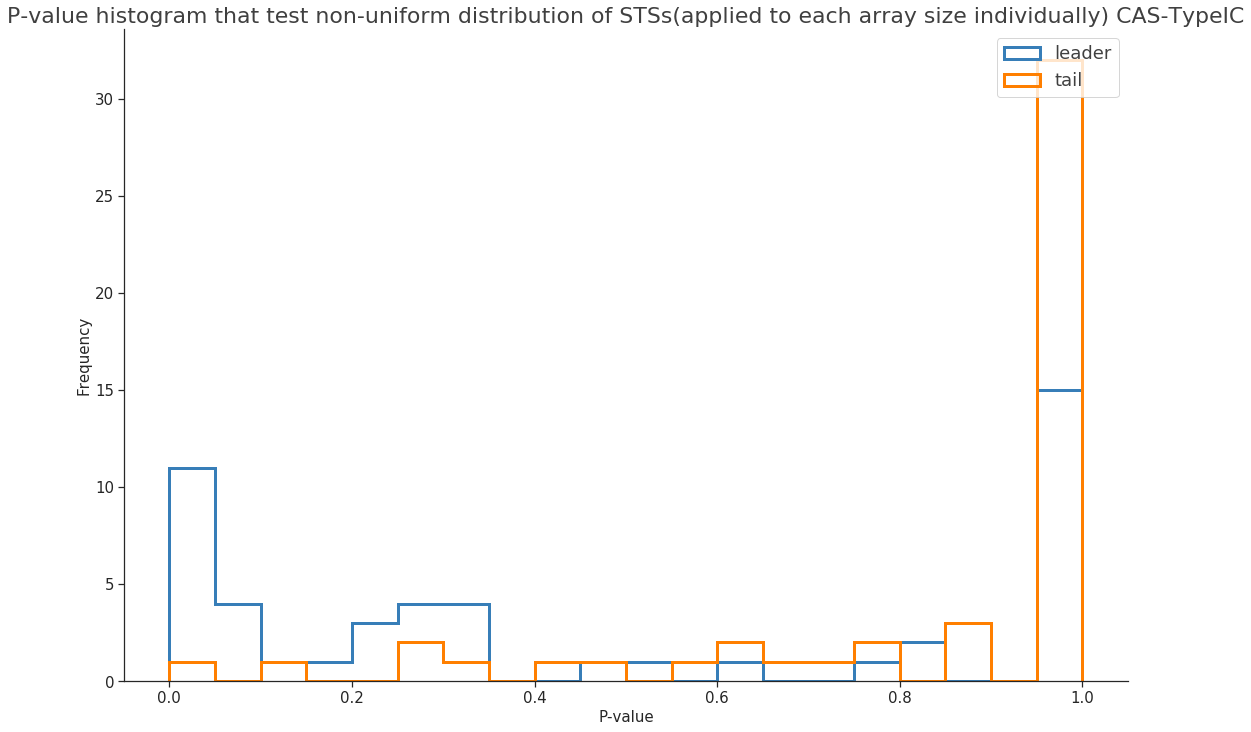

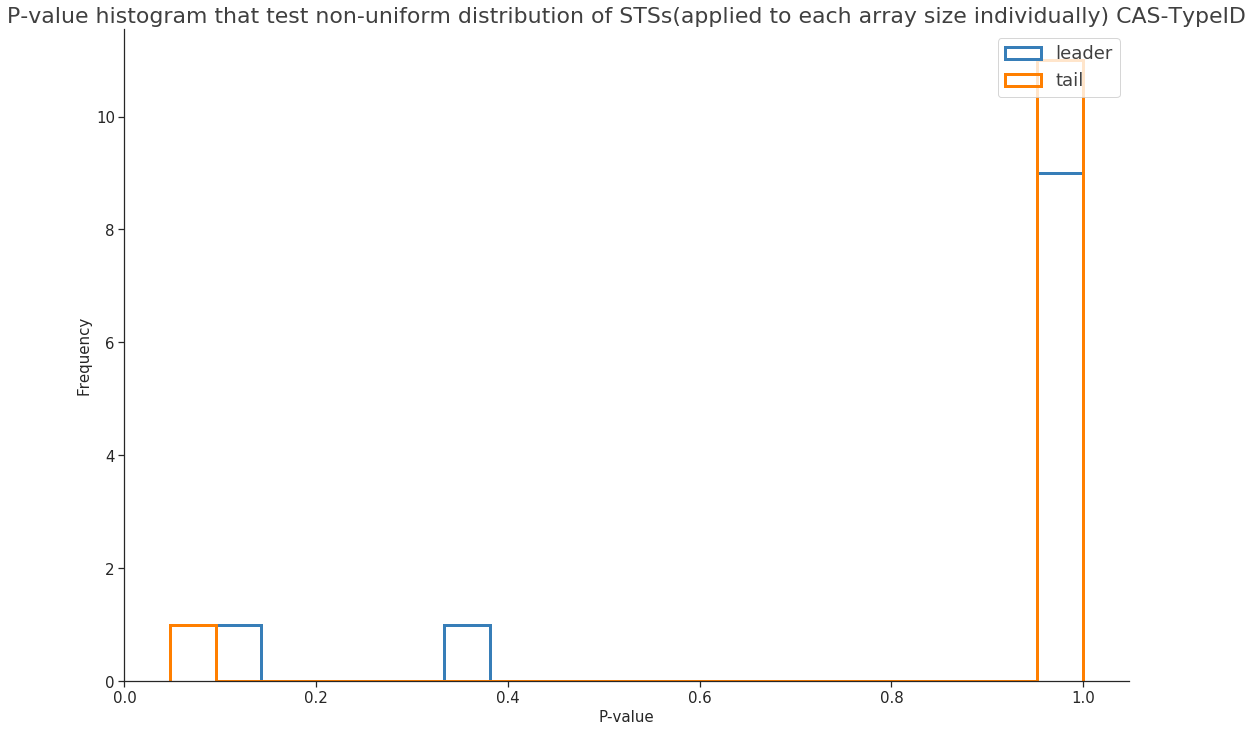

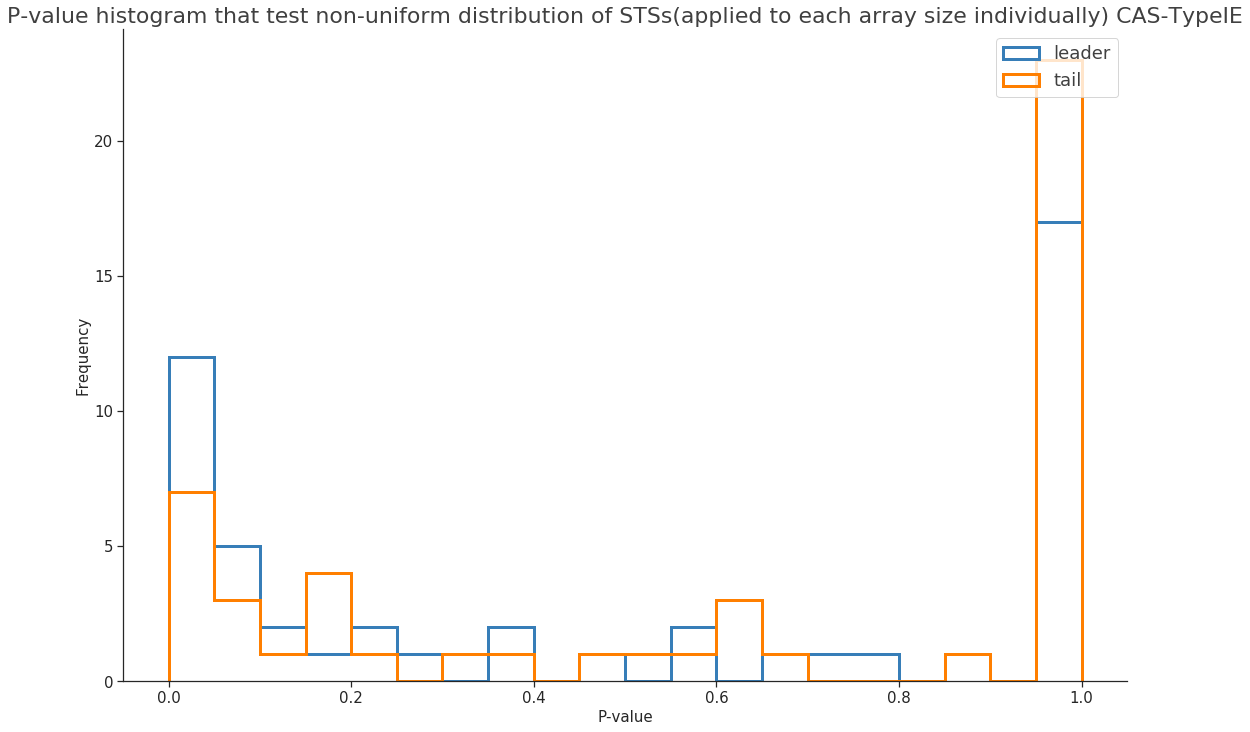

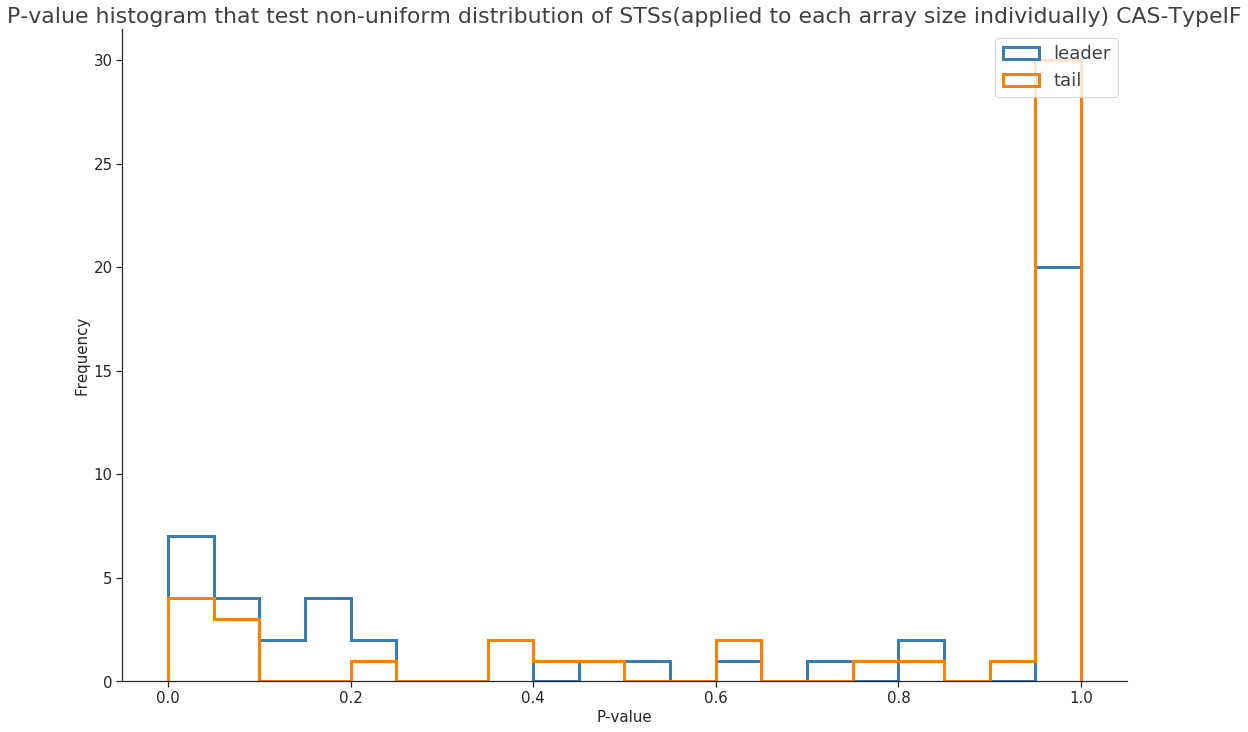

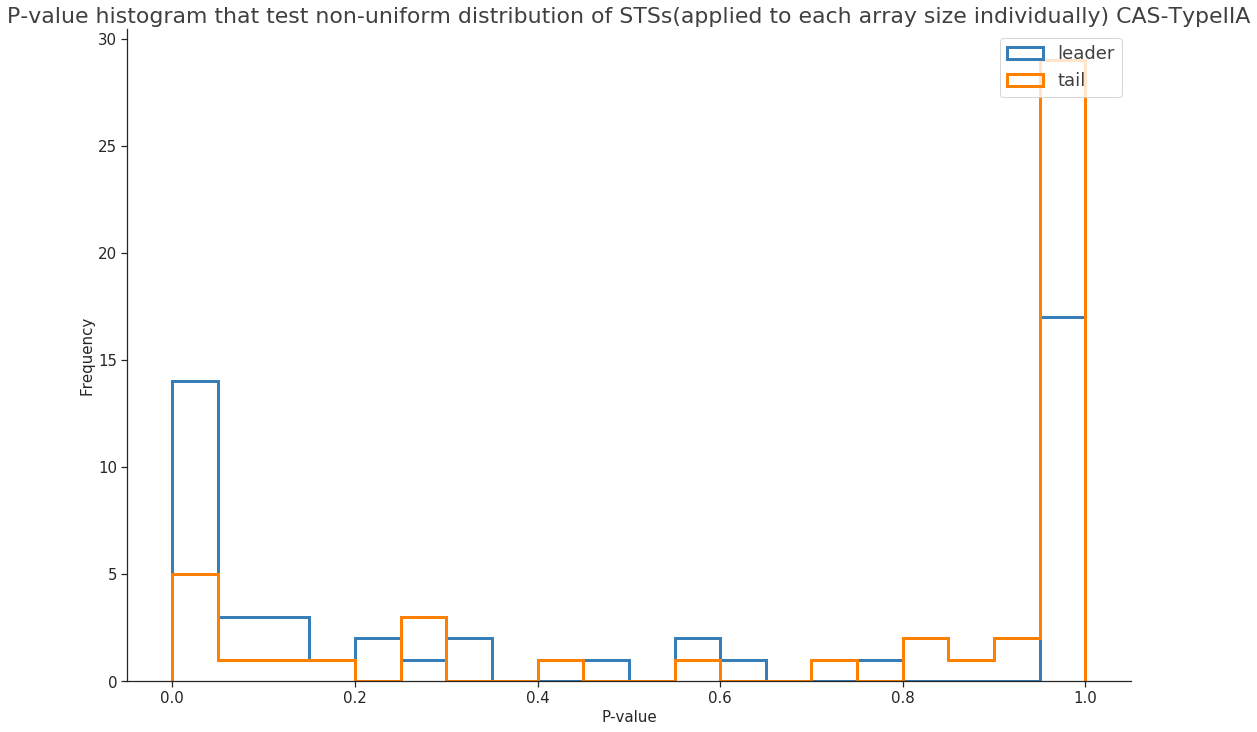

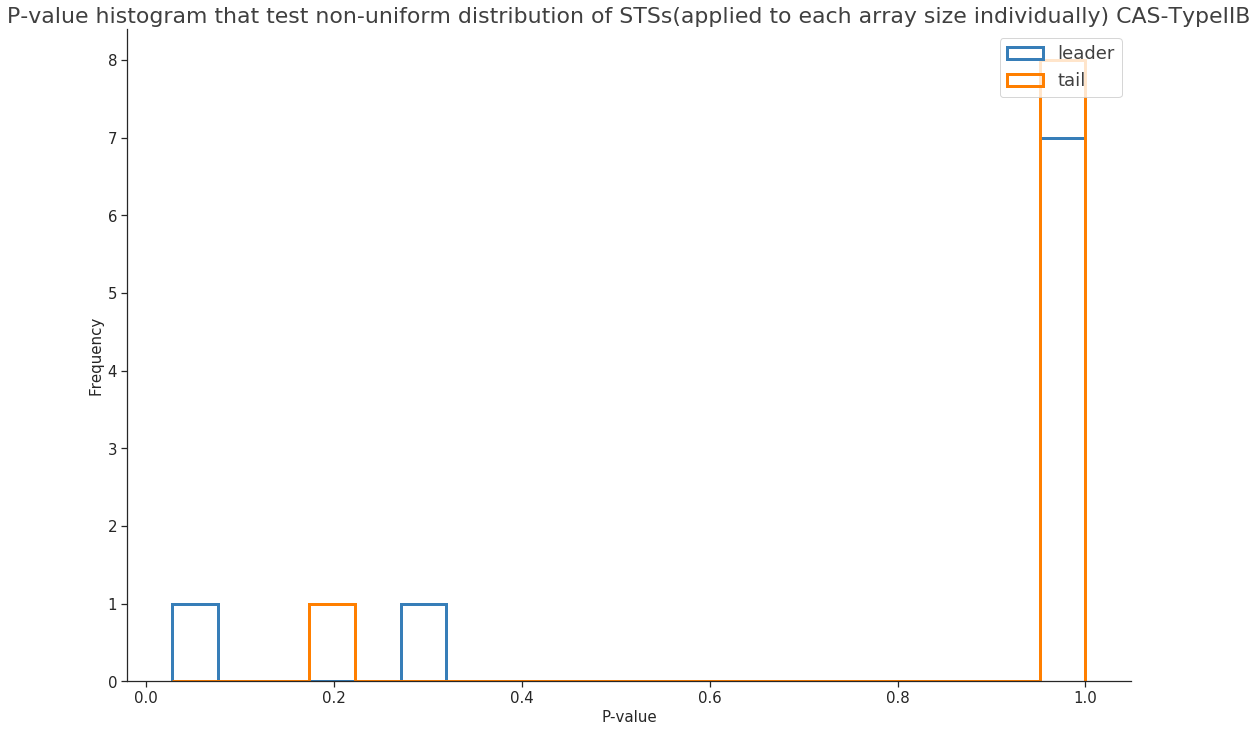

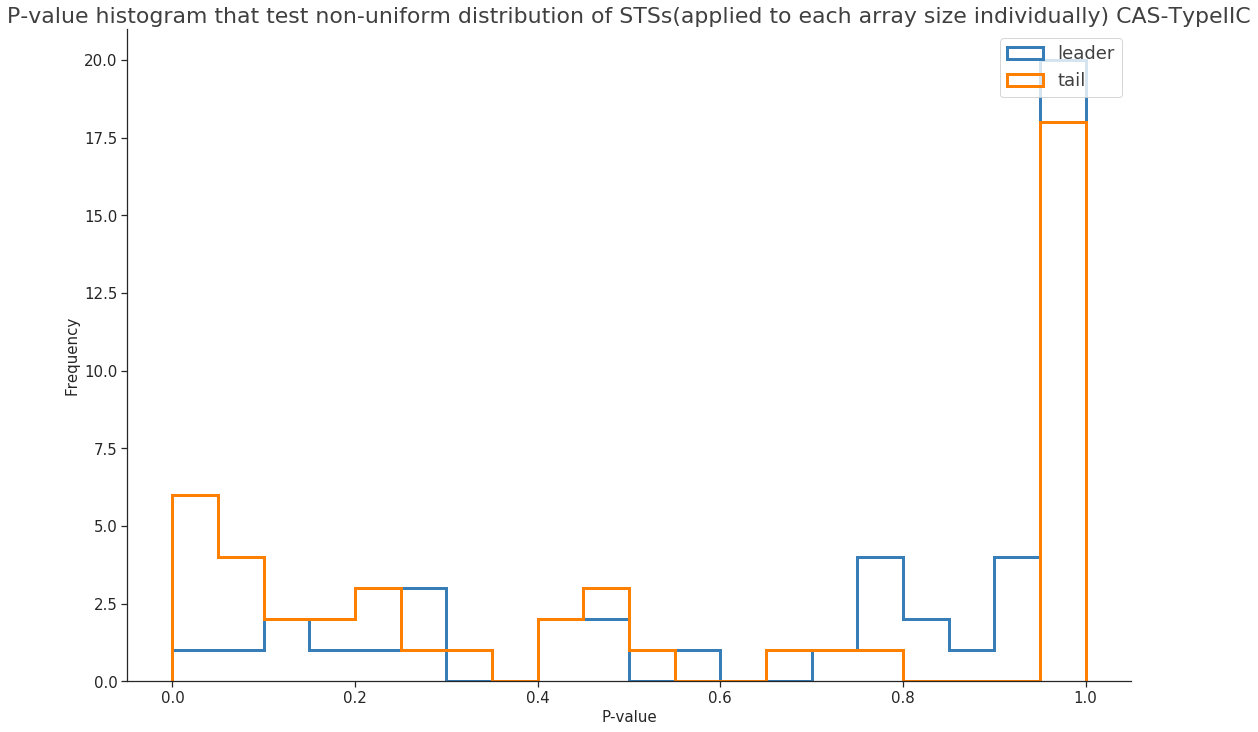

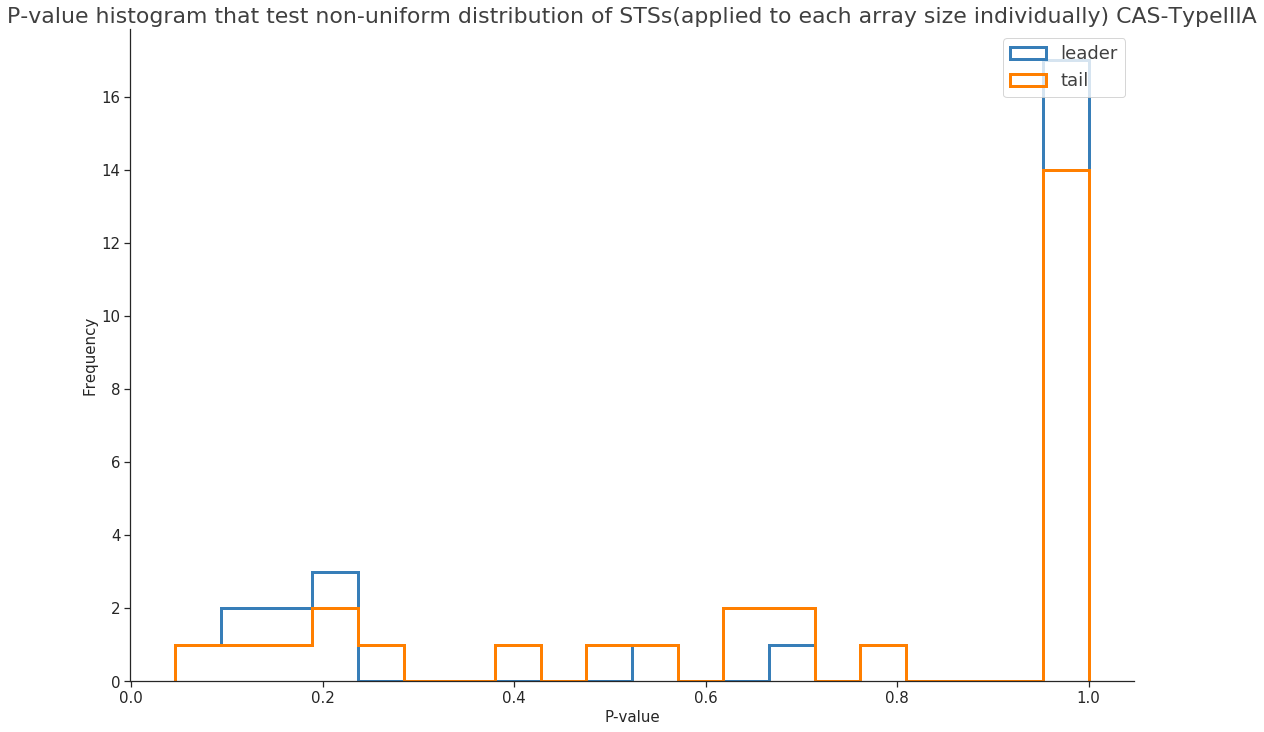

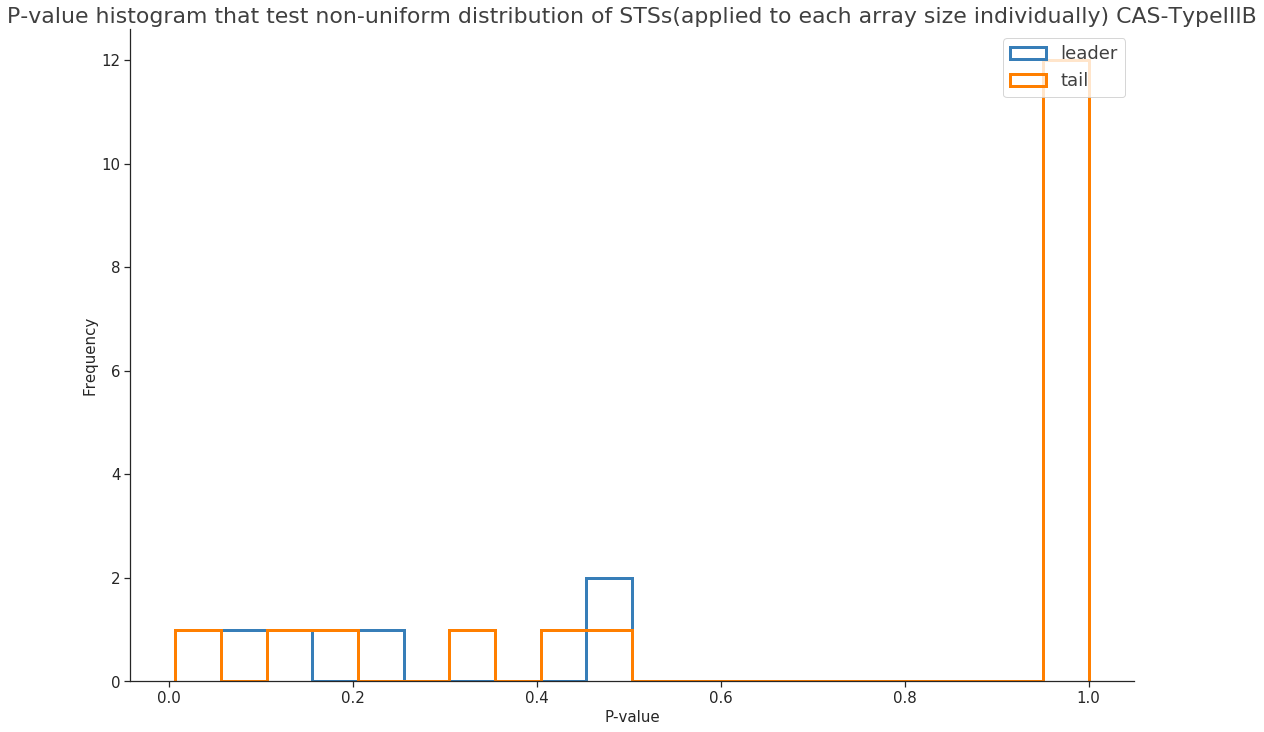

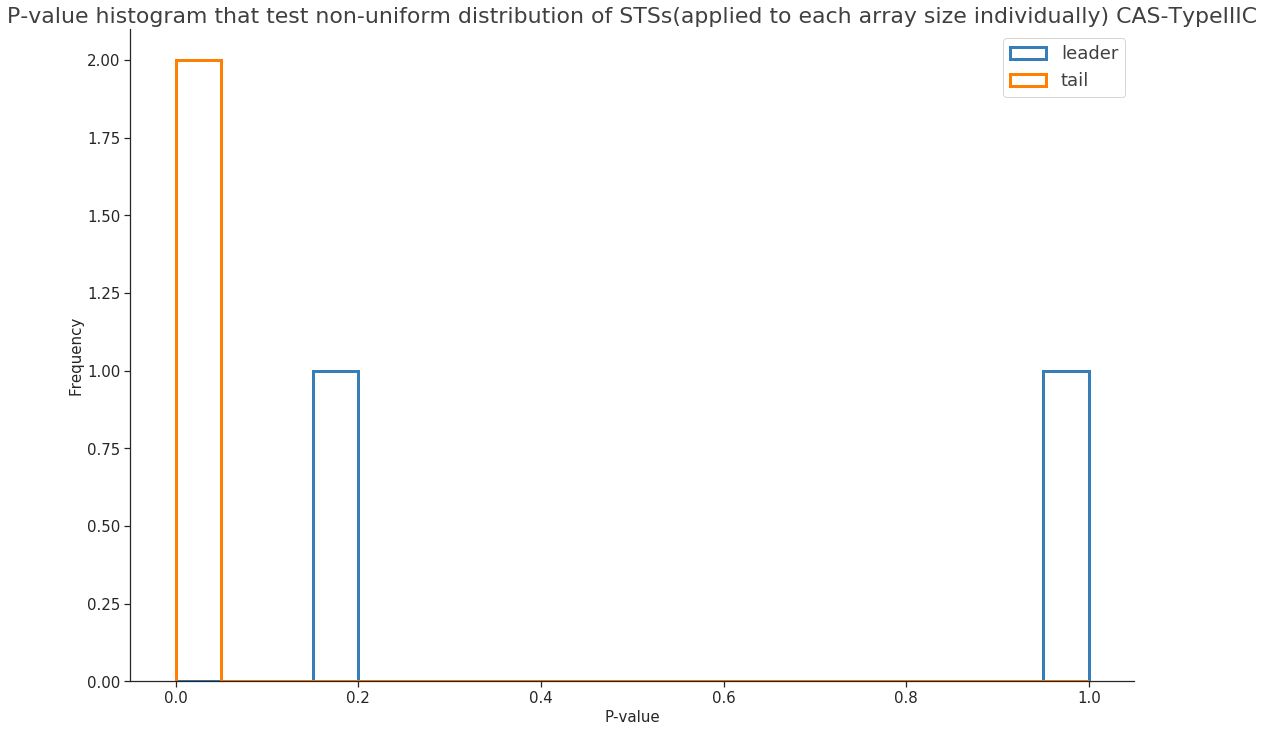

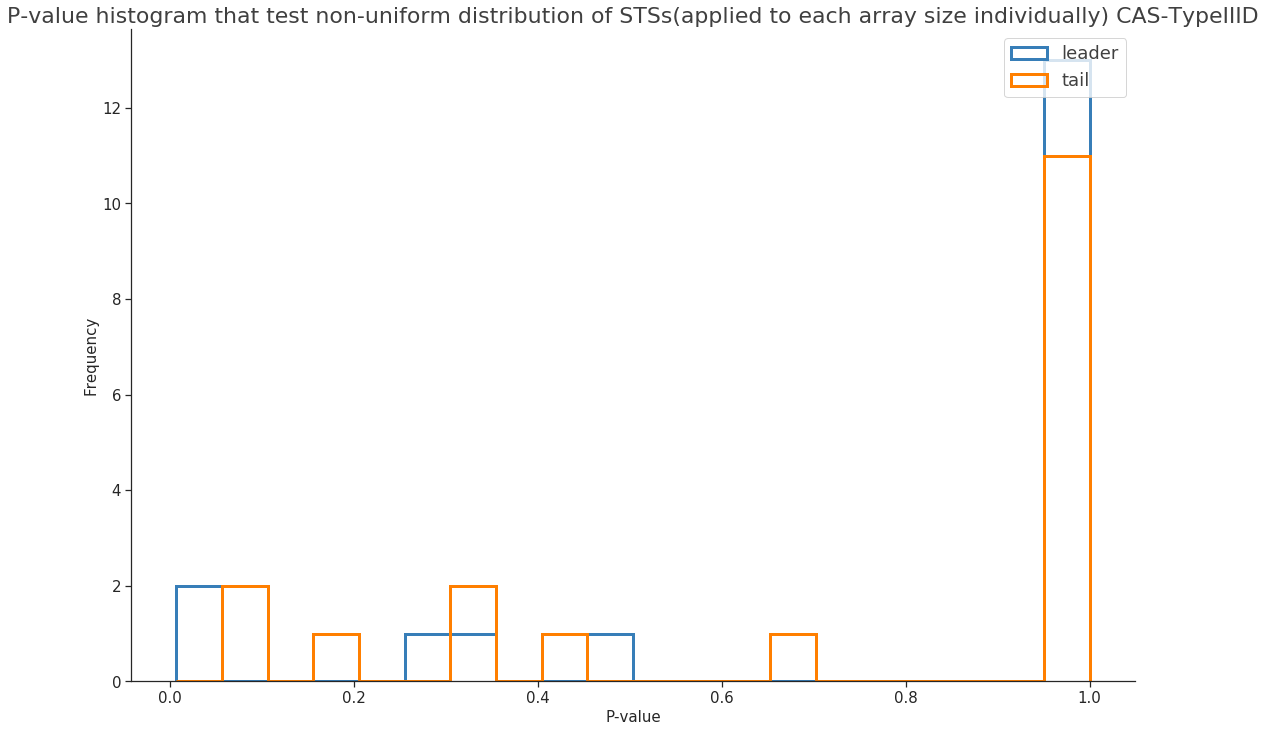

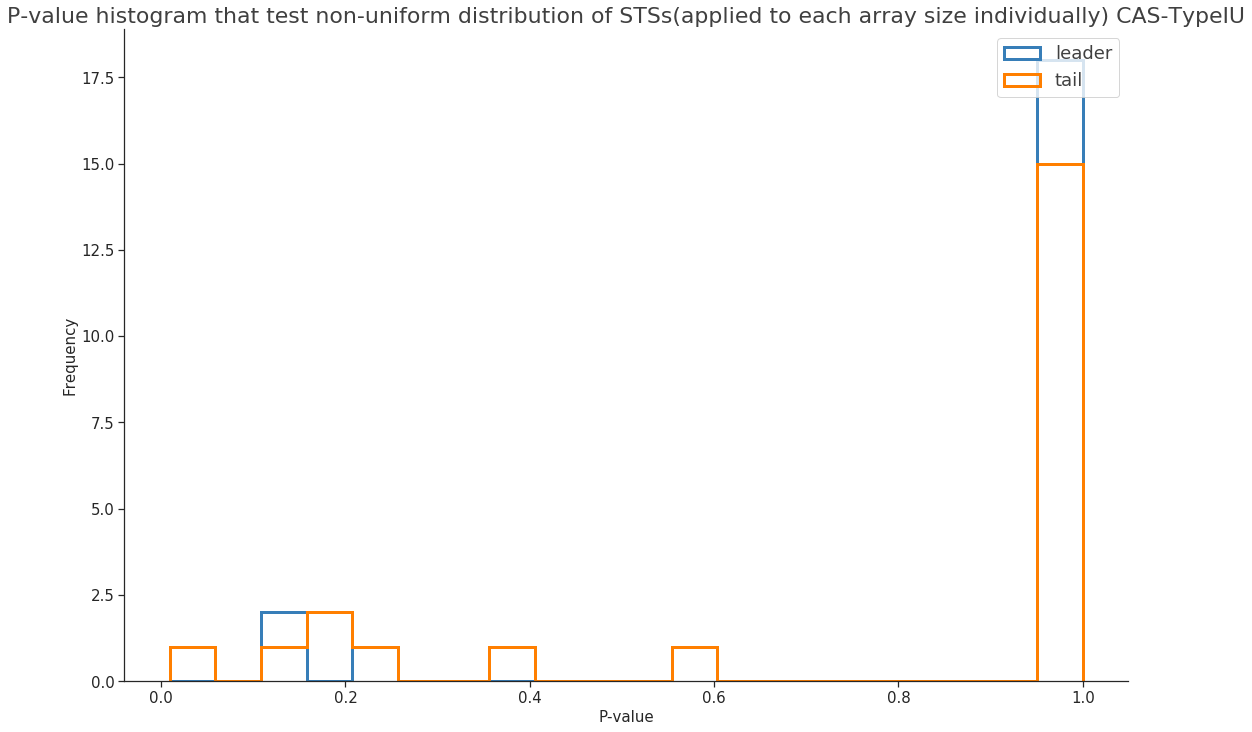

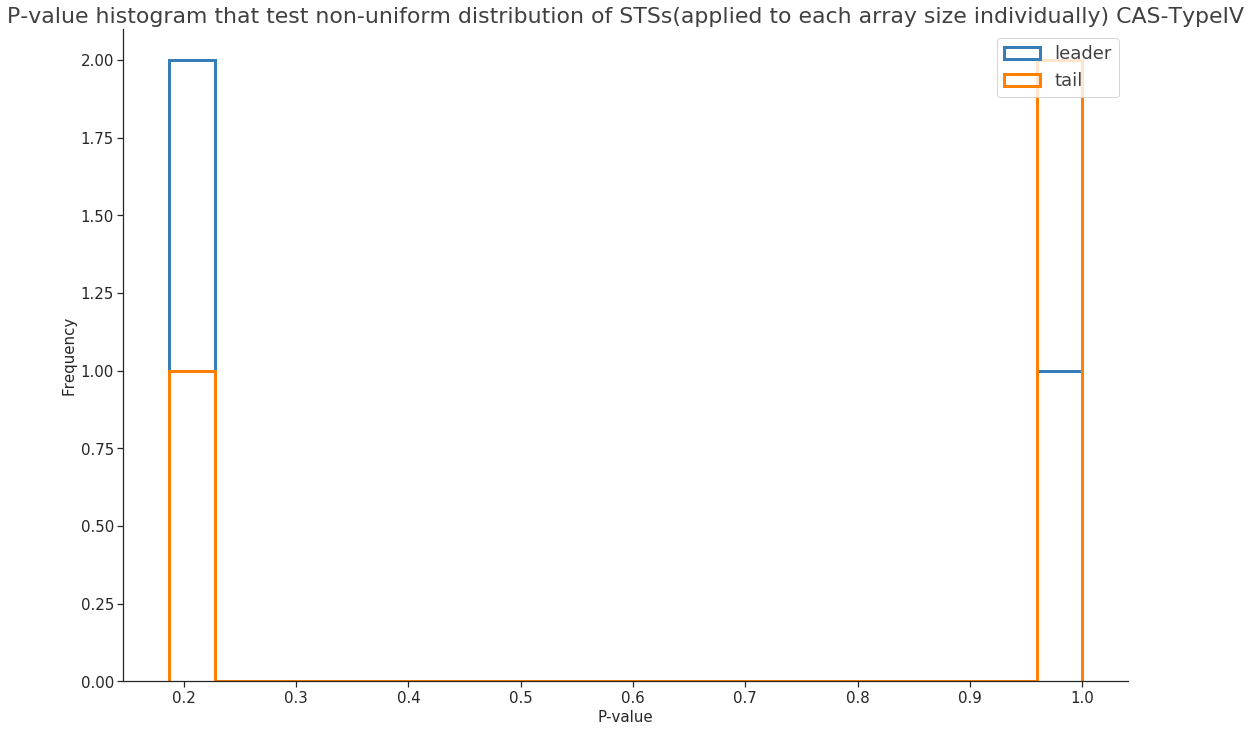

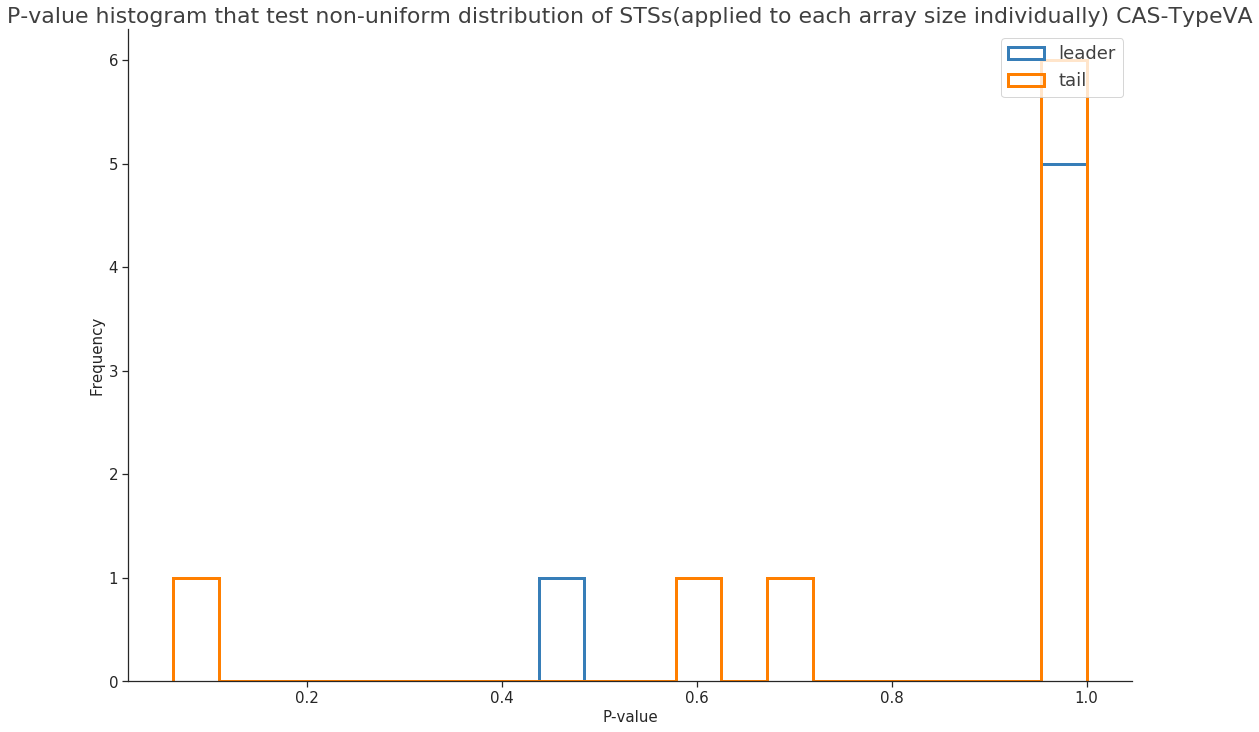

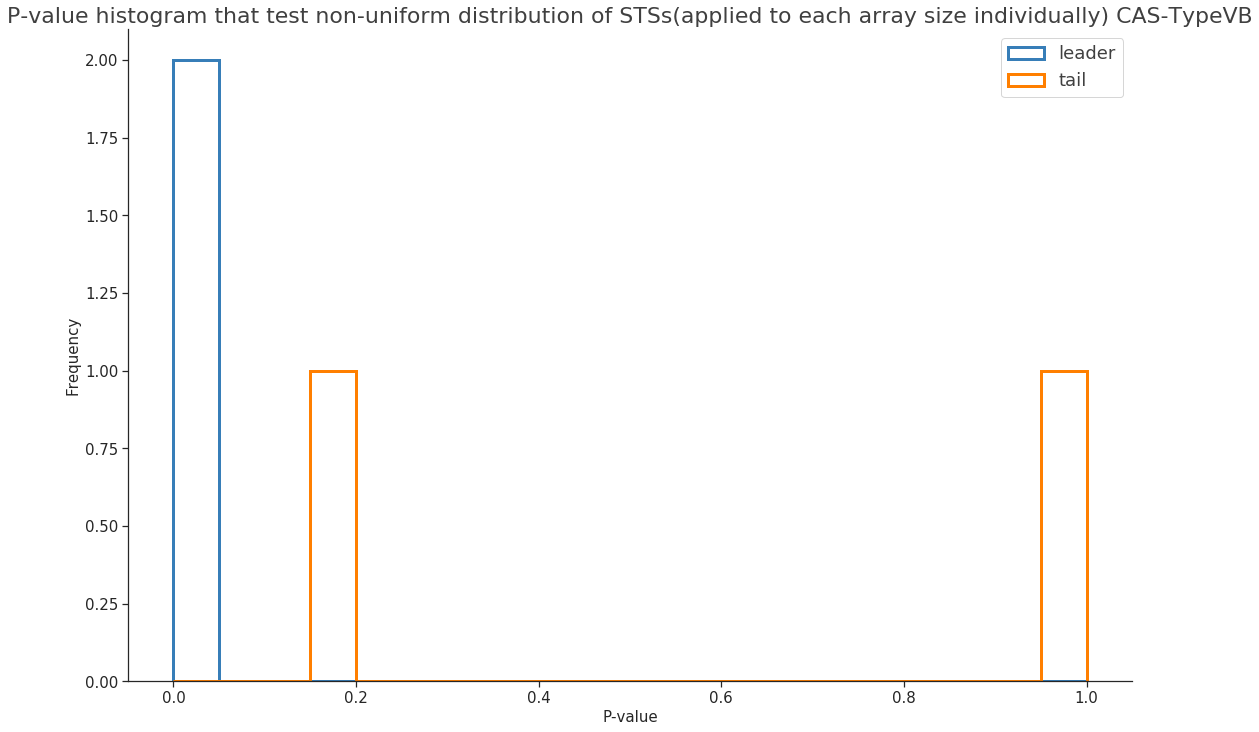

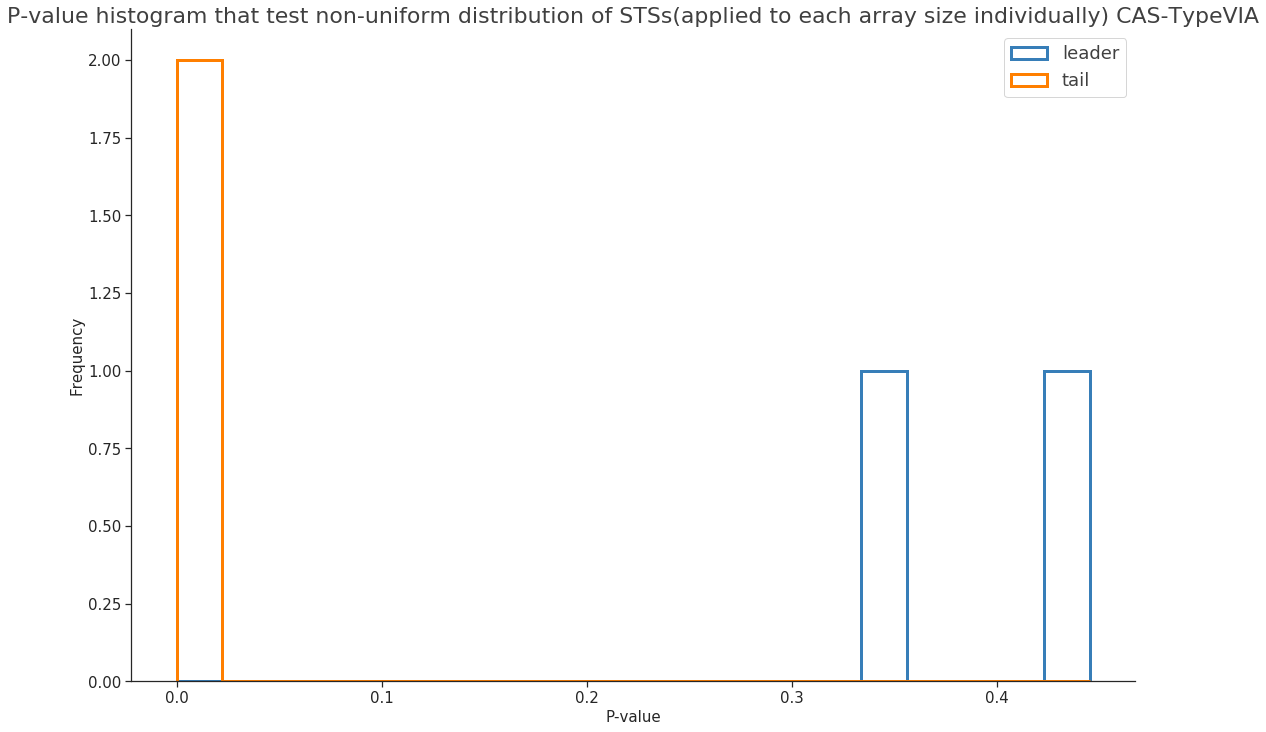

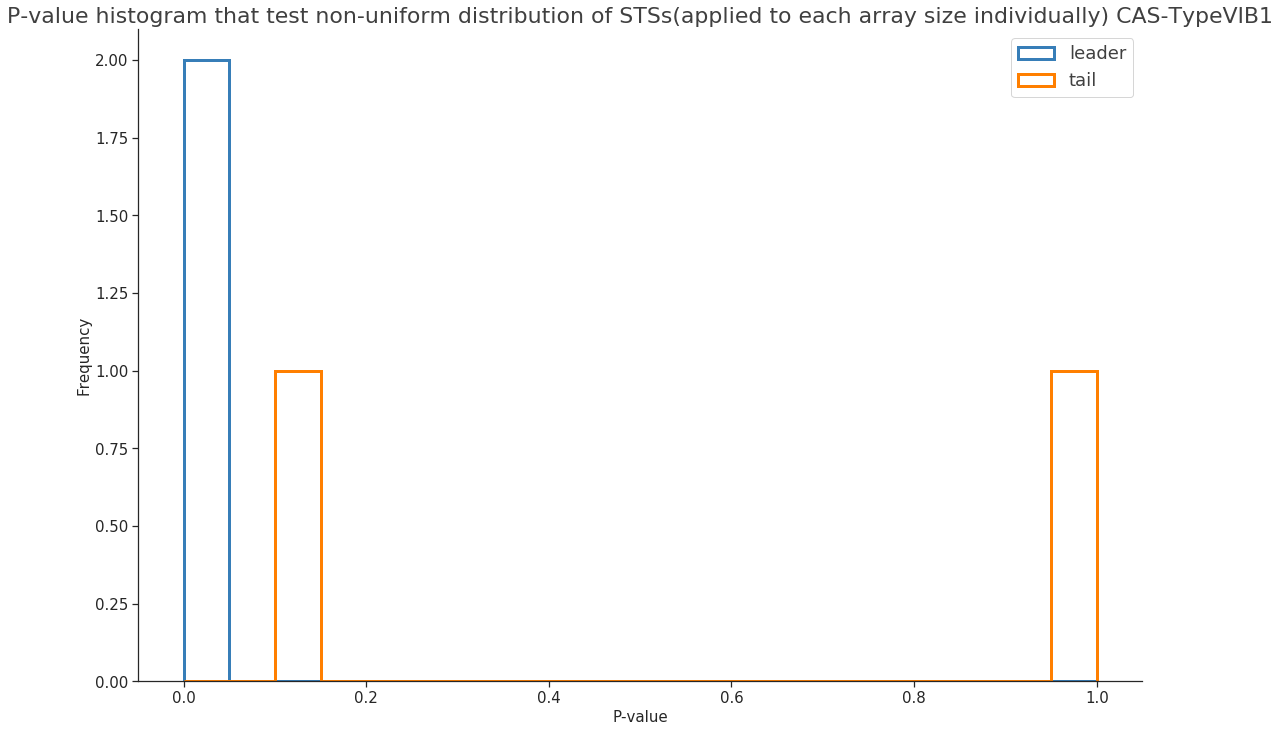

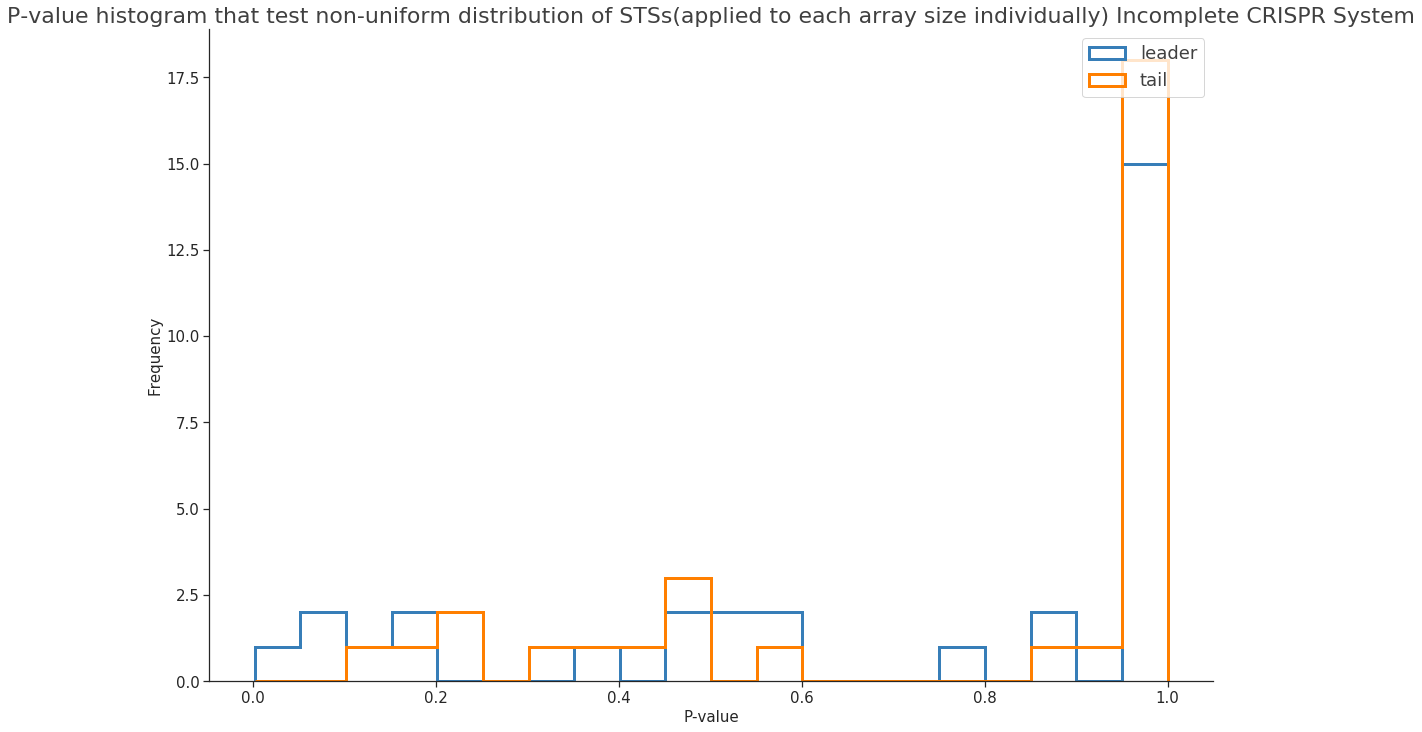

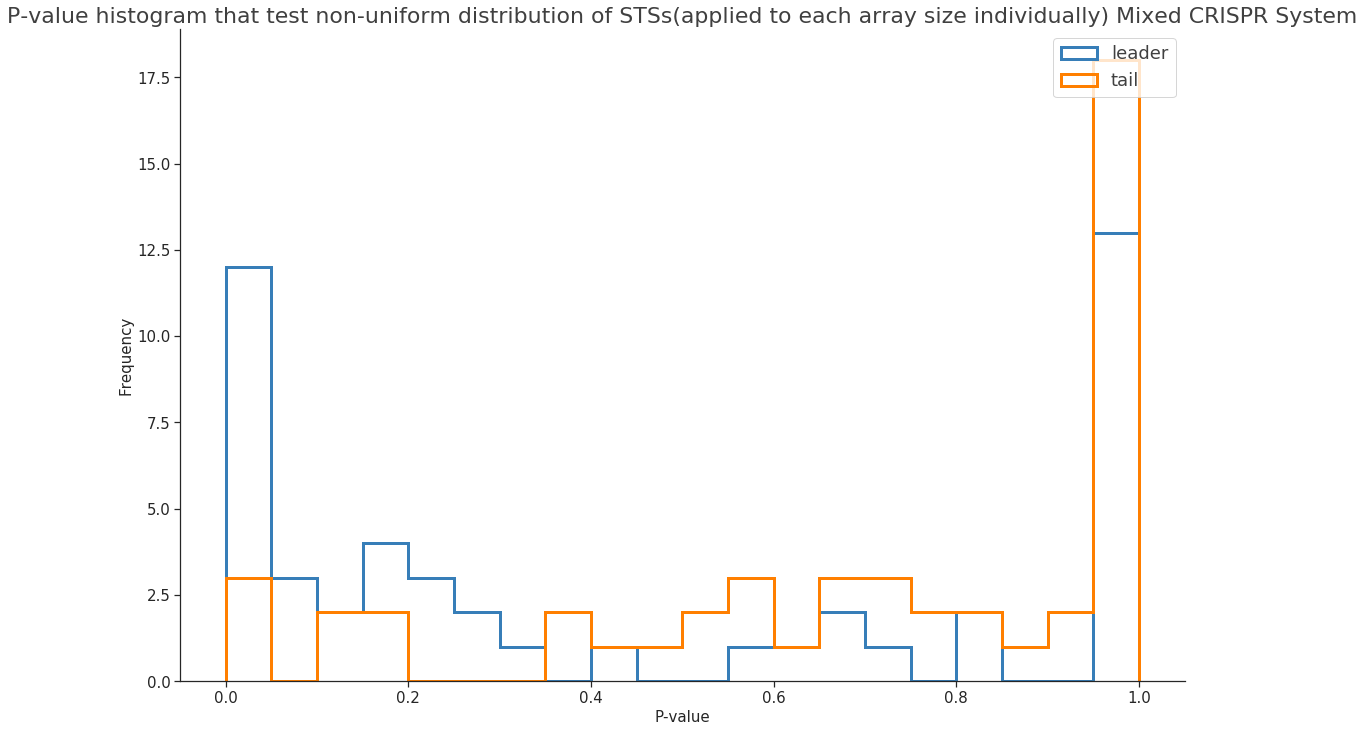

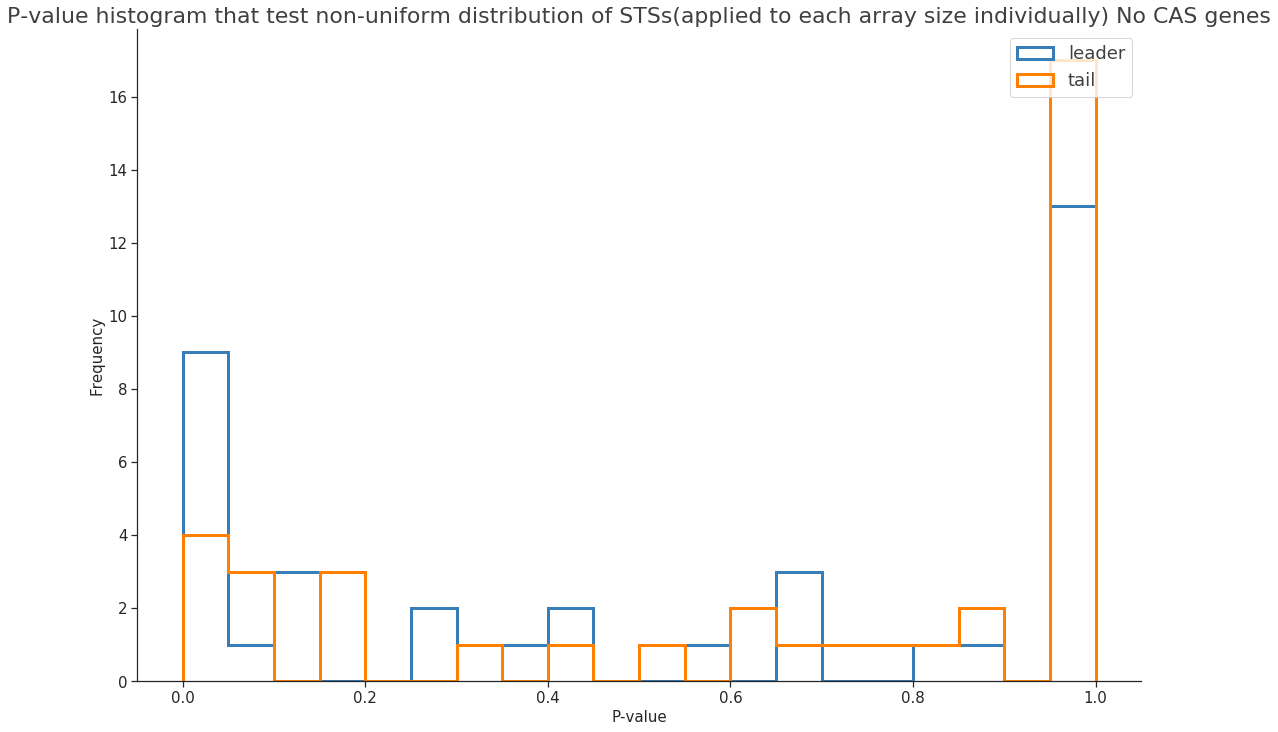

In [95]:
df.groupby(by='new_type_group').apply(lambda x: build_p_value_hist(x, name_mod = x.name))

figure saved in /home/hielke/bep/figs/FINAL2/A38___Change_of_frequency_of_head_and_tail_spacers_in_different_identity_intervals.png


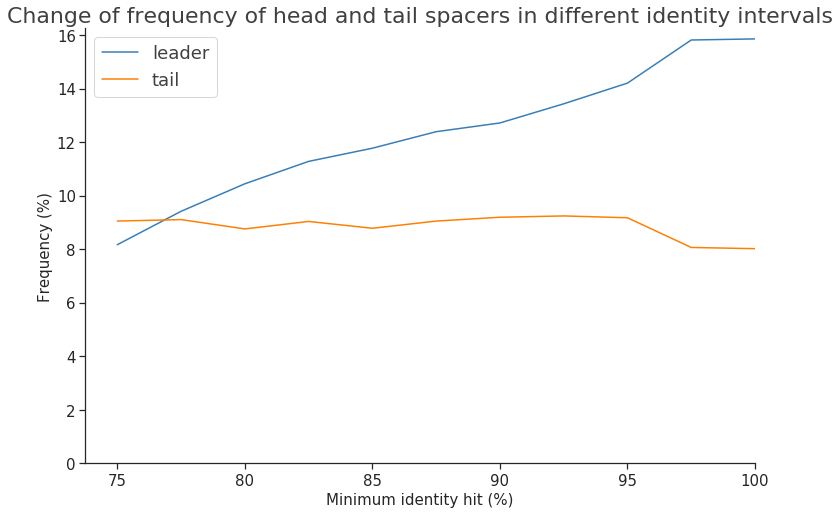

In [96]:
# Cumulative sum to have each range till 100 %
# For each group the percentage of that group is displayed.

pivot_table = df_uni_all.pipe(
    lambda d: 
    d.groupby(['name_spacer_pos', 
                pd.cut(d['hit_ident'], 10)])
    .size() 
    .groupby(level=0).apply(lambda x: x[::-1].cumsum()[::-1]) 
    .groupby(level=1).apply(percentage) 
    .unstack(0).fillna(0)
    .pipe(lambda pt: 
          # Set index to something readable
          pt.set_index(pt.index.map(lambda x: round(x.left, 1)).astype(float))
         )
    .append(
        # Finish table with the group with exactly 100 % identity
        d.query('hit_ident == 100')
        .groupby('name_spacer_pos')
        .size().pipe(percentage)
        .to_frame(100.0).T
    )
    .mul(100)
)

# pd.core.base.PandasObject.reverse = lambda df: df.reindex(index=df.index[::-1])

# sum_ranges = (df_all.groupby(df_all_cut).size()
#               .reverse().cumsum().reverse()
#              )

ax = sns.lineplot(data=pivot_table.drop('middle', axis=1), dashes=False)
sns.despine()
plt.legend(loc='upper left')
ax.set_ylim(bottom=0)
ax.set_xlim(right=100)
ax.set_xlabel('Minimum identity hit (%)')
ax.set_ylabel('Frequency (%)')
ax.set_title('Change of frequency of head and tail spacers in different identity intervals')
increase_figsize(2)
save_fig()

In [97]:
x, y, hue, grouper = 'gene_hit', 'Frequency (%)', 'name_spacer_pos', 'top_level_group'
data = df.query('array_size < 4').pipe(
    lambda d:
    d.empty or 
    d[x]
    .groupby([d[hue], d[grouper],])
#     .value_counts(normalize=True)
#     .rename(y)
#     .reset_index()
)
data.value_counts() if type(data) is not bool else None

name_spacer_pos  top_level_group           gene_hit  
leader           Complete CRISPR System    RNA-          123
                                           RNA+          108
                                           INTERGENIC     30
                 Incomplete CRISPR System  RNA-            3
                                           RNA+            2
                                           INTERGENIC      1
                 Mixed CRISPR System       RNA+           13
                                           RNA-            8
                                           INTERGENIC      5
                 No CAS genes              INTERGENIC     26
                                           RNA-           10
                                           RNA+            4
middle           Complete CRISPR System    RNA-           44
                                           RNA+           41
                                           INTERGENIC     22
                 Incomplete CRI

In [98]:
# g = sns.FacetGrid(data=data, hue=hue, row='top_level_group', height=2,)

# g = g.map(plt.bar, x, y)

# g.fig.suptitle("Distribution of the totals of unique STSs in a genome (hit identity: %s)" % perc_ident, 
# fontsize=32, y=1.01)
# plt.xlabel('Total STS')
# g.set(yscale='log')
# for ax in g.axes.flat:
#     ax.set_xlim(left=0,
#                right=10,
#                )
# increase_size_by(2, 20)
# g.set_titles(row_template="{row_name}", size=25)
# save_fig(g)

figure saved in /home/hielke/bep/figs/FINAL2/A39___Spacer_position_(all_spacer_hits).png


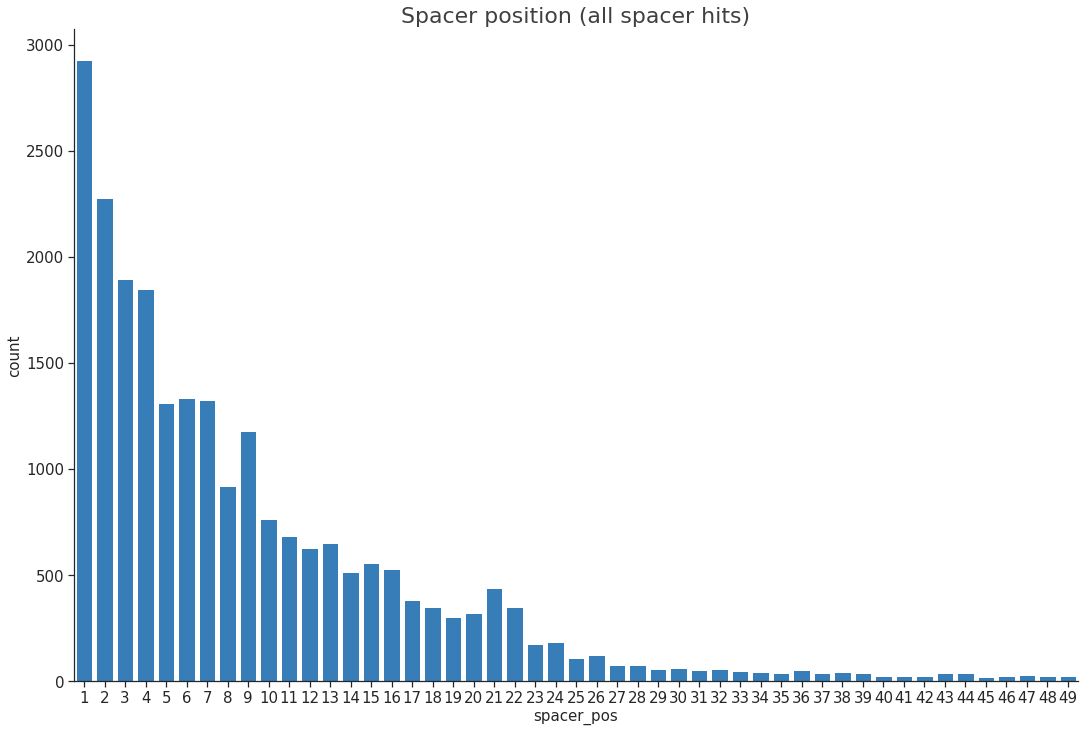

In [99]:
ax = sns.countplot(x='spacer_pos', data=df.query('spacer_pos < 50'), color=cbf[0], saturation=100)
increase_figsize(3)
sns.despine()
plt.title("Spacer position (all spacer hits)" + title_mod)
save_fig()
# save_fig()

figure saved in /home/hielke/bep/figs/FINAL2/A40___Spacer_position_reversed_(all_spacer_hits).png


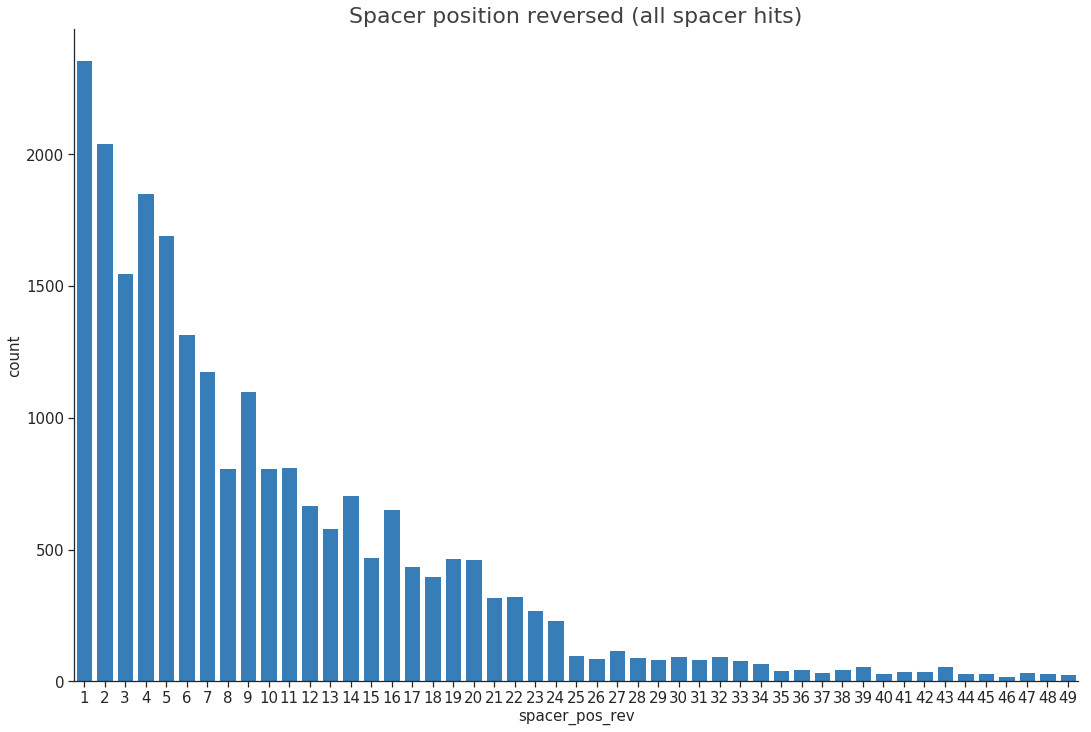

In [100]:
# spacer position reversed
df = df.assign(spacer_pos_rev=df['array_size'].add(1).subtract(df['spacer_pos']))
ax = sns.countplot(x='spacer_pos_rev', data=df.query('spacer_pos_rev < 50'), color=cbf[0], saturation=100)
increase_figsize(3)
sns.despine()
plt.title("Spacer position reversed (all spacer hits)" + title_mod)
save_fig()
# save_fig()

figure saved in /home/hielke/bep/figs/FINAL2/A41___Relative_spacer_position_(all_spacer_hits);_0:_leader;_1:_tail.png


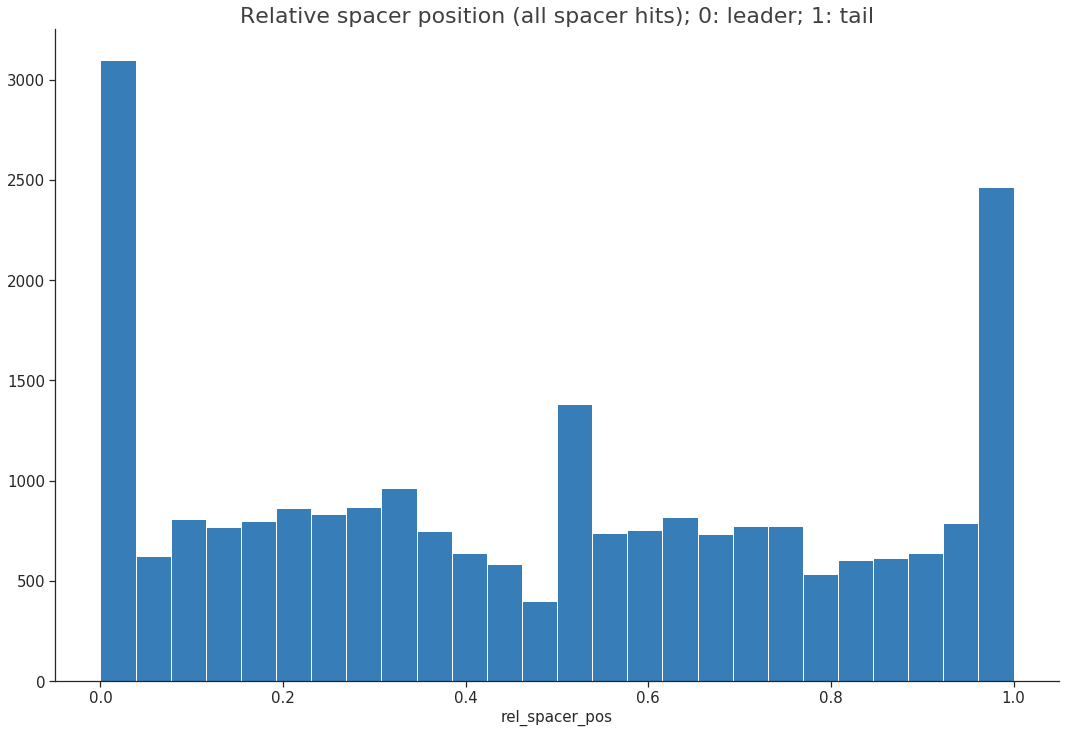

In [101]:
ax = sns.distplot(df['rel_spacer_pos'], kde=False, hist_kws={'color': cbf[0], 'alpha': 1})
increase_figsize(3)
sns.despine()
plt.title("Relative spacer position (all spacer hits); 0: leader; 1: tail" + title_mod)
save_fig()
# save_fig()

figure saved in /home/hielke/bep/figs/FINAL2/A42___Array_size_of_'tail_and_head_spacers'_(all_spacer_hits).png


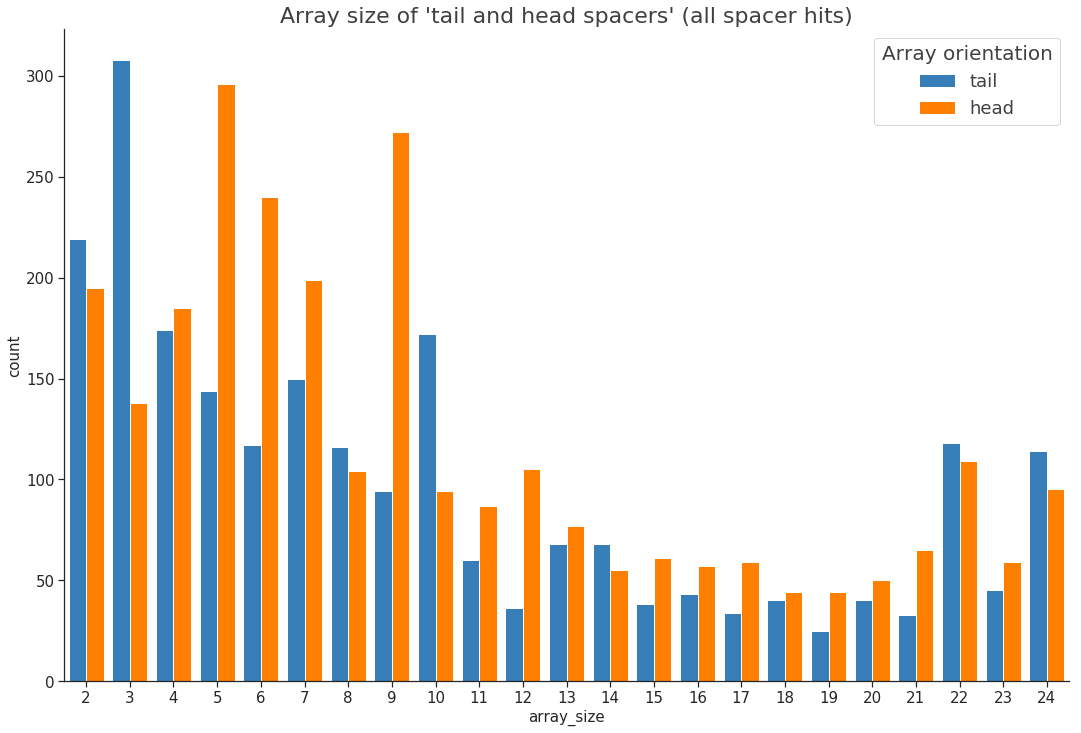

In [102]:
# relative spacer position
ax = sns.countplot(x = 'array_size', data=df.query('array_ori != "mid" and array_size < 25'), 
                   hue='array_ori', saturation=100, palette=cbf)
increase_figsize(3)
sns.despine()
plt.title("Array size of 'tail and head spacers' (all spacer hits)" + title_mod)
plt.setp(ax.get_legend().get_title(), fontsize=20, text="Array orientation")
save_fig()
# save_fig()

In [103]:
df['new_type_group'].unique()

array(['CAS-TypeIE', 'CAS-TypeIIA', 'No CAS genes', 'CAS-TypeIF',
       'CAS-TypeIIC', 'CAS-TypeIC', 'Mixed CRISPR System',
       'Incomplete CRISPR System', 'CAS-TypeID', 'CAS-TypeIIIA',
       'CAS-TypeIB', 'CAS-TypeIA', 'CAS-TypeIU', 'CAS-TypeIIID',
       'CAS-TypeVIA', 'CAS-TypeIIIB', 'CAS-TypeVA', 'CAS-TypeIIIC',
       'CAS-TypeVIB1', 'CAS-TypeVB', 'CAS-TypeIIB', 'CAS-TypeIV'],
      dtype=object)

figure saved in /home/hielke/bep/figs/FINAL2/A43___CRISPR_Type_of_'tail_and_head_spacers'_(all_spacer_hits).png


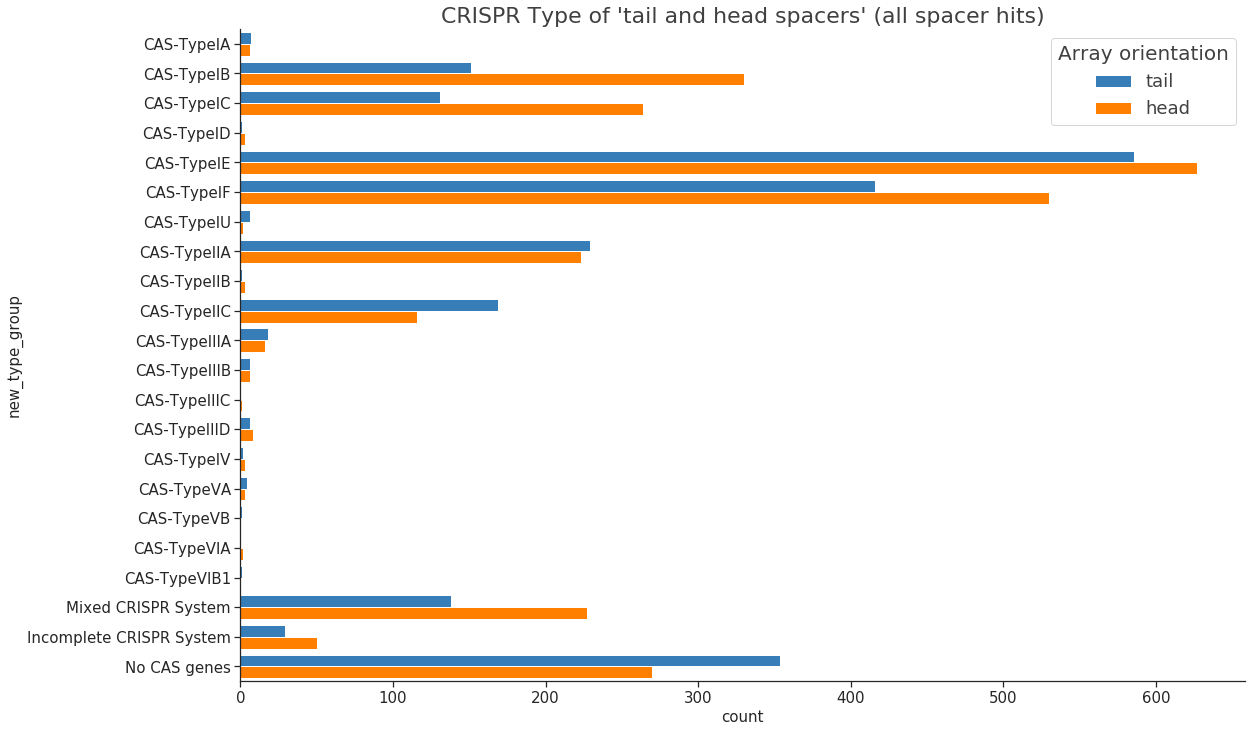

In [104]:
ax = sns.countplot(y='new_type_group', hue='array_ori', data=df.query('array_ori != "mid" and array_size < 25'), 
                   saturation=100, palette=cbf, order=sorted(df['new_type_group'].unique(), key=sort_groups))
increase_figsize(3)
sns.despine()
plt.title("CRISPR Type of 'tail and head spacers' (all spacer hits)" + title_mod)
plt.setp(ax.get_legend().get_title(), fontsize=20, text="Array orientation")
save_fig()

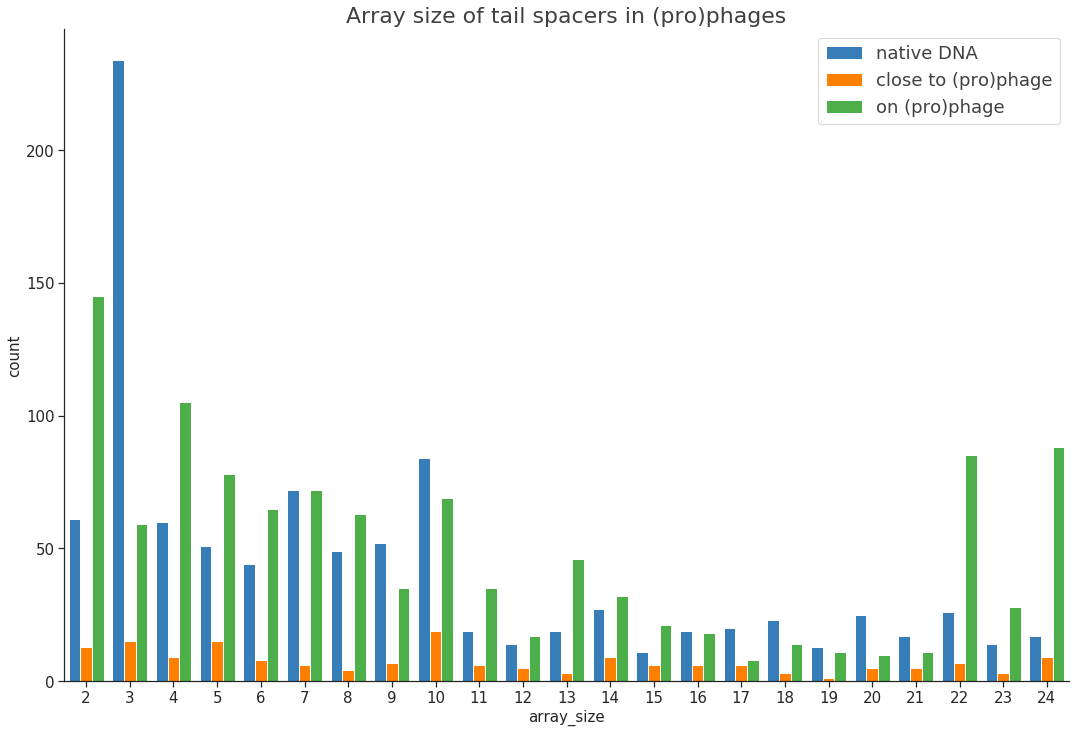

In [105]:
# tail spacers in (pro)phages
ax = sns.countplot(x = 'array_size', data=df.query('array_ori == "tail" and array_size < 25'), 
                   hue='with_phage', saturation=100, palette=cbf)
increase_figsize(3)
sns.despine()
plt.title("Array size of tail spacers in (pro)phages" + title_mod)
plt.setp(ax.get_legend().get_title(), fontsize=20, text="In (pro)phage or close")
plt.legend(['native DNA', 'close to (pro)phage', 'on (pro)phage'])
# save_fig()

In [106]:
df.head()

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,array_ori,contigs,size,name,type,class,num_genes,new_type_group,top_level_group,spacer_pos_rev
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,AACTTCTTCTCCGTGGATTTCGTCGTCACCAT,10514,10484,JQGS01000075,2,JQGS01000093_1_2,96.875,32,17127,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CCTTTATGGA,3,3,2,RNA+,JQGS01000075_22,UNCLASSIFIED,0.045455,middle,mid,341,4040397,Leptospira alexanderi strain 56650,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,Complete CRISPR System,22
100053.4,AAGAGGCGATTAGTTGGCTATATGCAGCCTTT,45209,45178,JQGS01000037,8,JQGS01000093_1_8,100.000,32,53765,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CTTTTACTGA,3,2,2,RNA-,JQGS01000037_64,UNCLASSIFIED,0.318182,middle,mid,341,4040397,Leptospira alexanderi strain 56650,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,Complete CRISPR System,16
100053.4,ACGCGCAGAAATATCAGGGTGCTGCCGTTCG,39170,39200,JQGS01000037,23,JQGS01000093_1_23,100.000,31,53765,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CTTGAGGCGT,3,2,2,RNA+,JQGS01000037_54,UNKNOWN,1.000000,tail,tail,341,4040397,Leptospira alexanderi strain 56650,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,Complete CRISPR System,1
100053.4,ATAAGCTCCGATACGCACCAAAGCATCGACTGC,6534,6502,JQGS01000215,5,JQGS01000065_1_5,100.000,33,18044,JQGS01000065_1,12,6.21,29,CAS-TypeIE,CAS-TypeIE,0,TCTTCCGGTG,3,NULL,0,RNA+,JQGS01000215_7,PBS lyase HEAT-like repeat,0.363636,middle,mid,341,4040397,Leptospira alexanderi strain 56650,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,Complete CRISPR System,8
100053.4,ATAGCACTCCCCTCATCATGTGTTTCTAATAT,6382,6413,JQGS01000037,15,JQGS01000093_1_15,100.000,32,53765,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CTTAATTCCA,3,2,2,RNA+,JQGS01000037_11,Phosphoribosyltransferase domain,0.636364,middle,mid,341,4040397,Leptospira alexanderi strain 56650,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,Complete CRISPR System,9


figure saved in /home/hielke/bep/figs/FINAL2/A44___Identity_with_the_hit.png


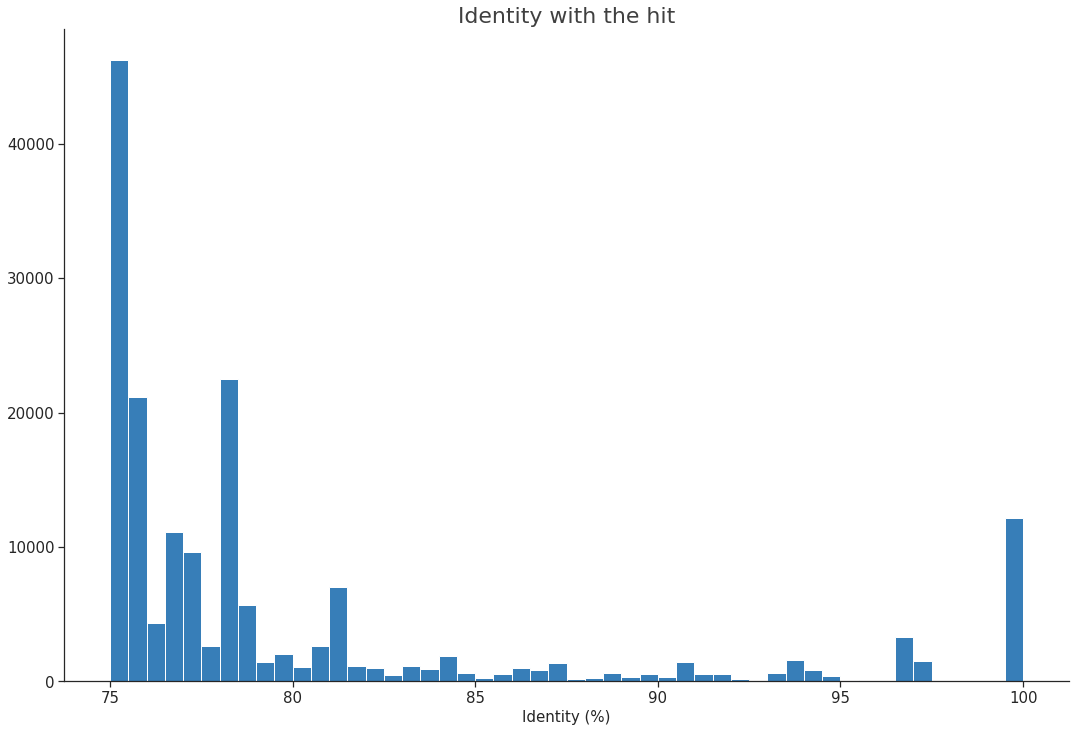

In [107]:
# df_uni_all['hit_ident'] = pd.to_numeric(df_all['hit_ident'])
ax = sns.distplot(df_all['hit_ident'], kde=False, hist_kws={'color': cbf[0], 'alpha': 1})
increase_figsize(3, plt)
sns.despine()
plt.title("Identity with the hit" + title_mod)
plt.xlabel("Identity (%)")
save_fig()

In [108]:
df.groupby(by='genome_id').first()['new_type_group'].value_counts() \
        .pipe(lambda df: df.reindex(sorted(df.index, key=sort_groups)))

CAS-TypeIA                    18
CAS-TypeIB                  1044
CAS-TypeIC                   691
CAS-TypeID                    16
CAS-TypeIE                  2012
CAS-TypeIF                  1513
CAS-TypeIU                    46
CAS-TypeIIA                  734
CAS-TypeIIB                   11
CAS-TypeIIC                  575
CAS-TypeIIIA                  90
CAS-TypeIIIB                  25
CAS-TypeIIIC                   2
CAS-TypeIIID                  30
CAS-TypeIV                     5
CAS-TypeVA                     9
CAS-TypeVB                     2
CAS-TypeVIA                    4
CAS-TypeVIB1                   1
Mixed CRISPR System          662
Incomplete CRISPR System     179
No CAS genes                 797
Name: new_type_group, dtype: int64

figure saved in /home/hielke/bep/figs/FINAL2/A45___Frequency_of_all_STS_per_type_(hit_identity:_>90%).png


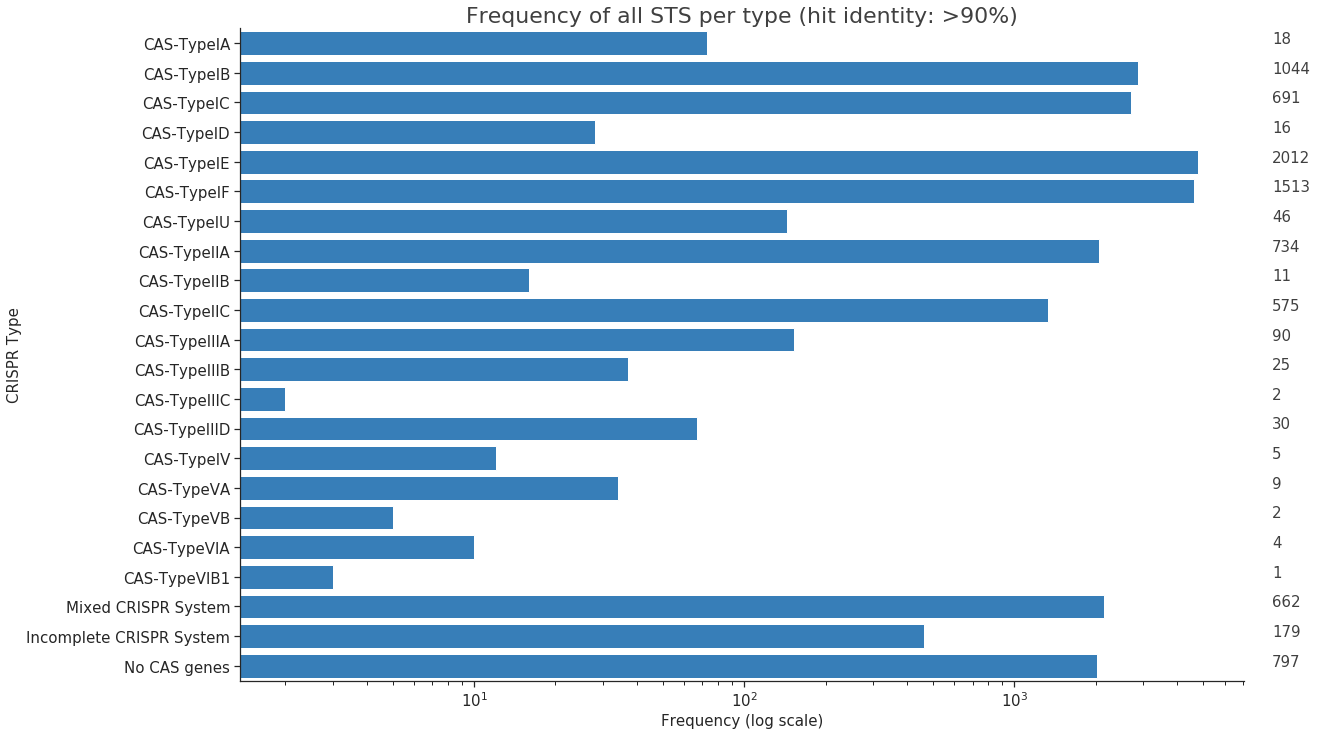

In [109]:
def plot(df, y):
    genome_value_counts = df.groupby(by='genome_id').first()[y].value_counts() \
        .pipe(lambda d: d.reindex(sorted(d.index, key=sort_groups)))
    ax = sns.countplot(y=y, data=df, color=cbf[0], saturation=100, 
                   order=sorted(df[y].unique(), key=sort_groups))
    N = len(genome_value_counts)
    ind = list(range(N))
    for i, v in enumerate(genome_value_counts):
        if v == 0: continue
        ax.text(9000, ind[i], str(round(v)), color='0.25', fontsize=15)
    return ax
ax = plot(df, 'new_type_group')
ax.set_xscale('log')
increase_figsize(3, plt)
sns.despine()
plt.title("Frequency of all STS per type (hit identity: %s)" % perc_ident + title_mod)
plt.xlabel("Frequency (log scale)")
plt.ylabel("CRISPR Type")
save_fig()

Text(0, 0.5, 'CRISPR Type')

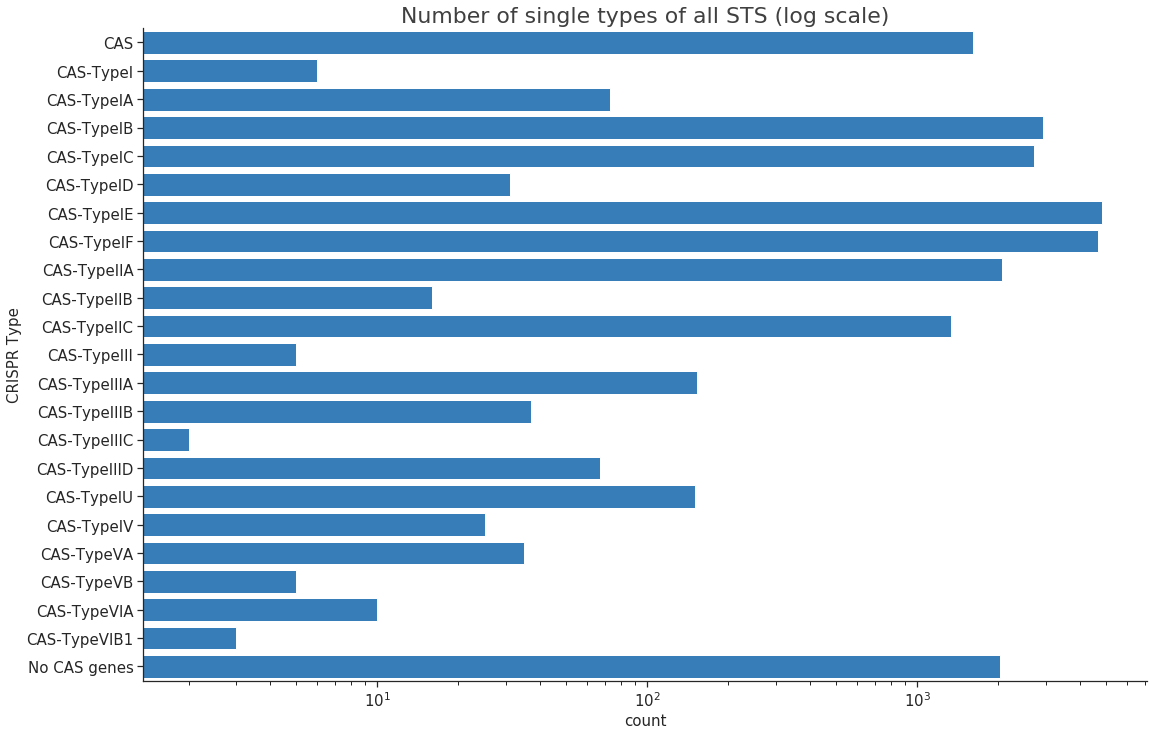

In [110]:
ax = sns.countplot(y='genome_type', 
                   data=df_single_type, color=cbf[0], 
                   saturation=100, 
                   order=sorted(df_single_type['genome_type'].unique()))
ax.set_xscale('log')
for i, v in enumerate(all_genome_type_count):
    if v == 0: 
        continue
    # Add the number to end of the bar (currently not working)
    # ax.text(value_counts_perc[i]+0.5, ind[i]-0.25, str(round(v)), color='0.25', fontsize=15)

increase_figsize(3)
sns.despine()
plt.title("Number of single types of all STS (log scale)" + title_mod)
plt.ylabel("CRISPR Type")
# save_fig()
# save_fig()

## Heatmaps

In [111]:
pivot_table = df_single_type.groupby(['genome_type', pd.cut(df_single_type['hit_ident'], 10)]).size() \
        .groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().fillna(0)
pivot_table

hit_ident,"(89.991, 91.001]","(91.001, 92.001]","(92.001, 93.001]","(93.001, 94.001]","(94.001, 95.001]","(95.001, 96.001]","(96.001, 97.0]","(97.0, 98.0]","(98.0, 99.0]","(99.0, 100.0]"
genome_type,,,,,,,,,,
CAS,5.080545,6.071871,1.734820,6.319703,7.249071,0.247831,8.921933,8.798017,0.061958,55.514250
CAS-TypeI,0.000000,16.666667,0.000000,0.000000,16.666667,0.000000,0.000000,66.666667,0.000000,0.000000
CAS-TypeIA,9.589041,6.849315,2.739726,0.000000,17.808219,0.000000,0.000000,12.328767,0.000000,50.684932
CAS-TypeIB,0.068236,12.794268,3.650631,0.102354,16.103719,0.000000,0.204708,15.864893,0.000000,51.211191
CAS-TypeIC,2.286136,9.697640,0.737463,2.544248,7.632743,0.073746,5.125369,12.831858,0.036873,59.033923
CAS-TypeID,0.000000,6.451613,6.451613,0.000000,9.677419,0.000000,0.000000,16.129032,19.354839,41.935484
CAS-TypeIE,11.992543,0.932063,0.248550,13.069594,3.024027,0.227838,22.120961,0.704225,0.041425,47.638774
CAS-TypeIF,12.888033,0.128452,0.000000,13.979876,0.856348,0.000000,22.586170,0.856348,0.000000,48.704774
CAS-TypeIIA,2.909796,4.170708,0.096993,12.900097,6.013579,0.000000,17.798254,7.807953,0.000000,48.302619


Text(0.5, 1.0, 'Heatmap of identity with hit')

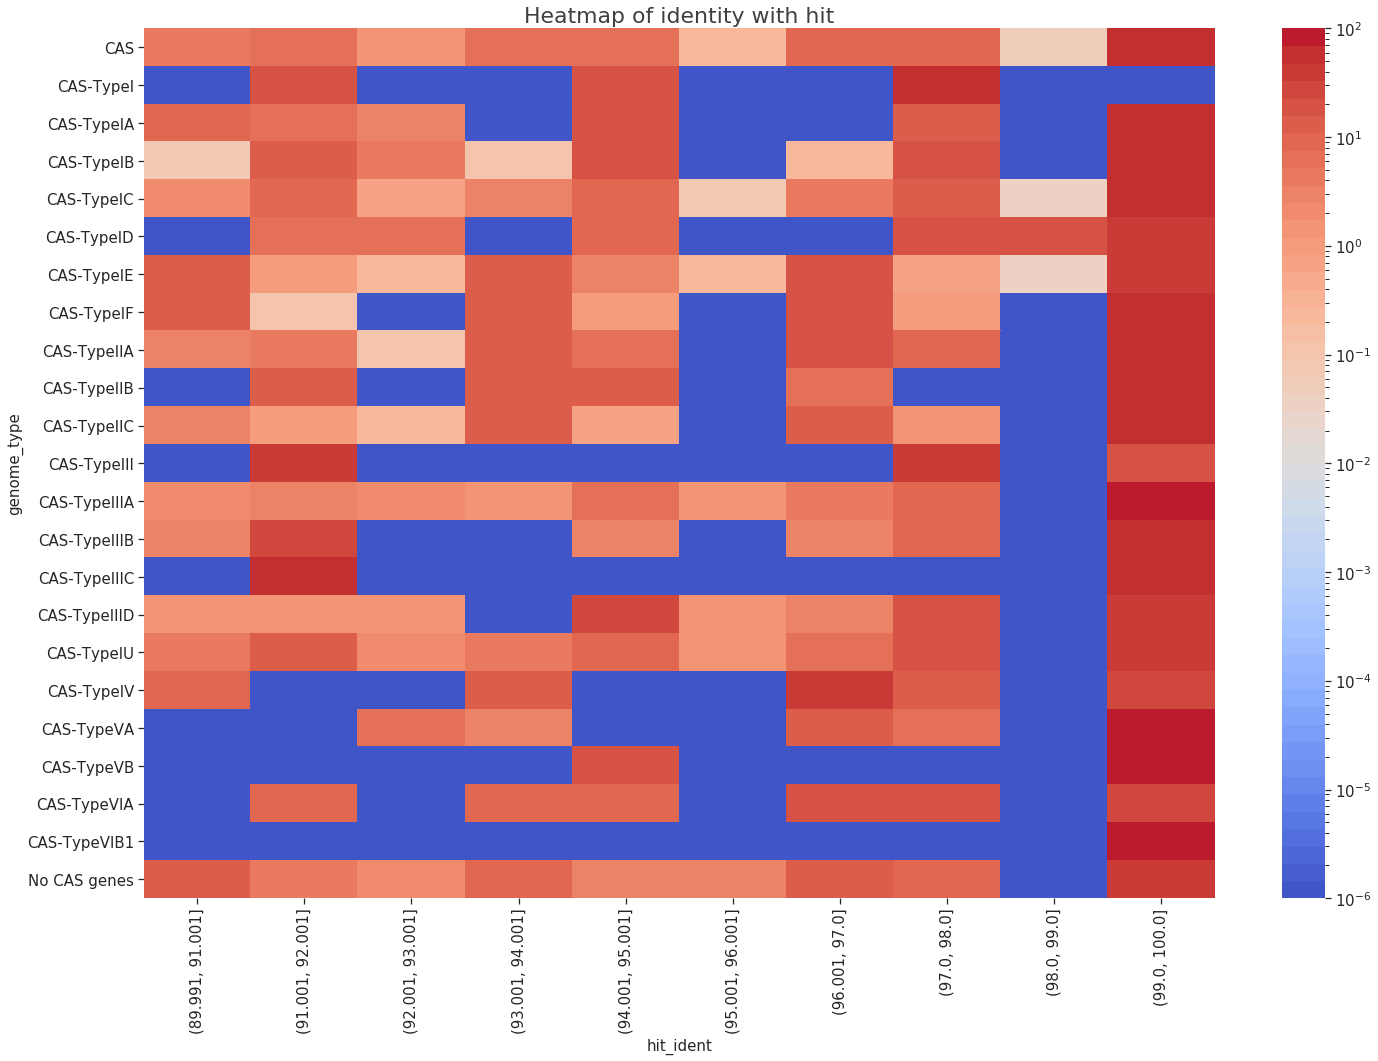

In [112]:
ax = sns.heatmap(pivot_table.applymap(lambda x: x if x!= 0 else 0.000001), yticklabels=True, xticklabels=True, square=False, 
            cmap=sns.color_palette("coolwarm", 50), 
            cbar_kws={'ticks': mpl.ticker.LogLocator()}, 
            norm=mpl.colors.LogNorm(vmin=pivot_table.min().min(), vmax=pivot_table.max().max()))
increase_figsize(4, plt)
plt.title("Heatmap of identity with hit" + title_mod)
# save_fig()
# save_fig()

In [113]:
pivot_table = df_single_type.groupby(
    ['genome_type', pd.cut(df_single_type['array_size'], 
    pd.IntervalIndex.from_breaks(list(range(0,80,5)) + [400]))]).size() \
        .groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().fillna(0)
pivot_table

array_size,"(0, 5]","(5, 10]","(10, 15]","(15, 20]","(20, 25]","(25, 30]","(30, 35]","(35, 40]","(40, 45]","(45, 50]","(50, 55]","(55, 60]","(60, 65]","(65, 70]","(70, 75]","(75, 400]"
genome_type,,,,,,,,,,,,,,,,
CAS,7.434944,17.038414,12.763321,13.630731,20.136307,6.195787,3.345725,4.460967,3.035936,0.247831,1.548947,0.805452,0.867410,0.929368,0.557621,7.001239
CAS-TypeI,0.000000,16.666667,16.666667,33.333333,33.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CAS-TypeIA,2.739726,23.287671,13.698630,9.589041,2.739726,0.000000,19.178082,2.739726,0.000000,13.698630,0.000000,0.000000,0.000000,0.000000,0.000000,12.328767
CAS-TypeIB,6.073013,20.368475,22.449676,11.190720,14.431934,6.857728,7.062436,2.012965,1.091778,1.569430,0.477653,3.650631,0.102354,0.887069,0.272944,1.501194
CAS-TypeIC,8.296460,15.191740,8.849558,12.094395,31.600295,3.502950,3.539823,2.765487,1.290560,1.327434,1.659292,1.401180,2.654867,0.811209,0.442478,4.572271
CAS-TypeID,6.451613,12.903226,58.064516,3.225806,3.225806,9.677419,0.000000,3.225806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.225806
CAS-TypeIE,9.921292,19.780447,19.407622,10.687655,21.499586,2.837614,3.024027,1.367026,2.154101,0.952775,0.579950,0.849213,1.387738,0.207125,0.787075,4.556752
CAS-TypeIF,14.279598,18.561336,9.612503,8.242346,40.676515,0.620852,1.605652,0.406765,0.299722,0.449583,0.235496,1.669878,0.813530,0.128452,0.149861,2.247913
CAS-TypeIIA,11.348206,26.867119,11.736178,10.960233,13.482056,5.916586,10.087294,2.861300,2.473327,0.872939,1.260912,0.824442,0.000000,1.115422,0.000000,0.193986


Text(0.5, 1.0, 'Heatmap of array size')

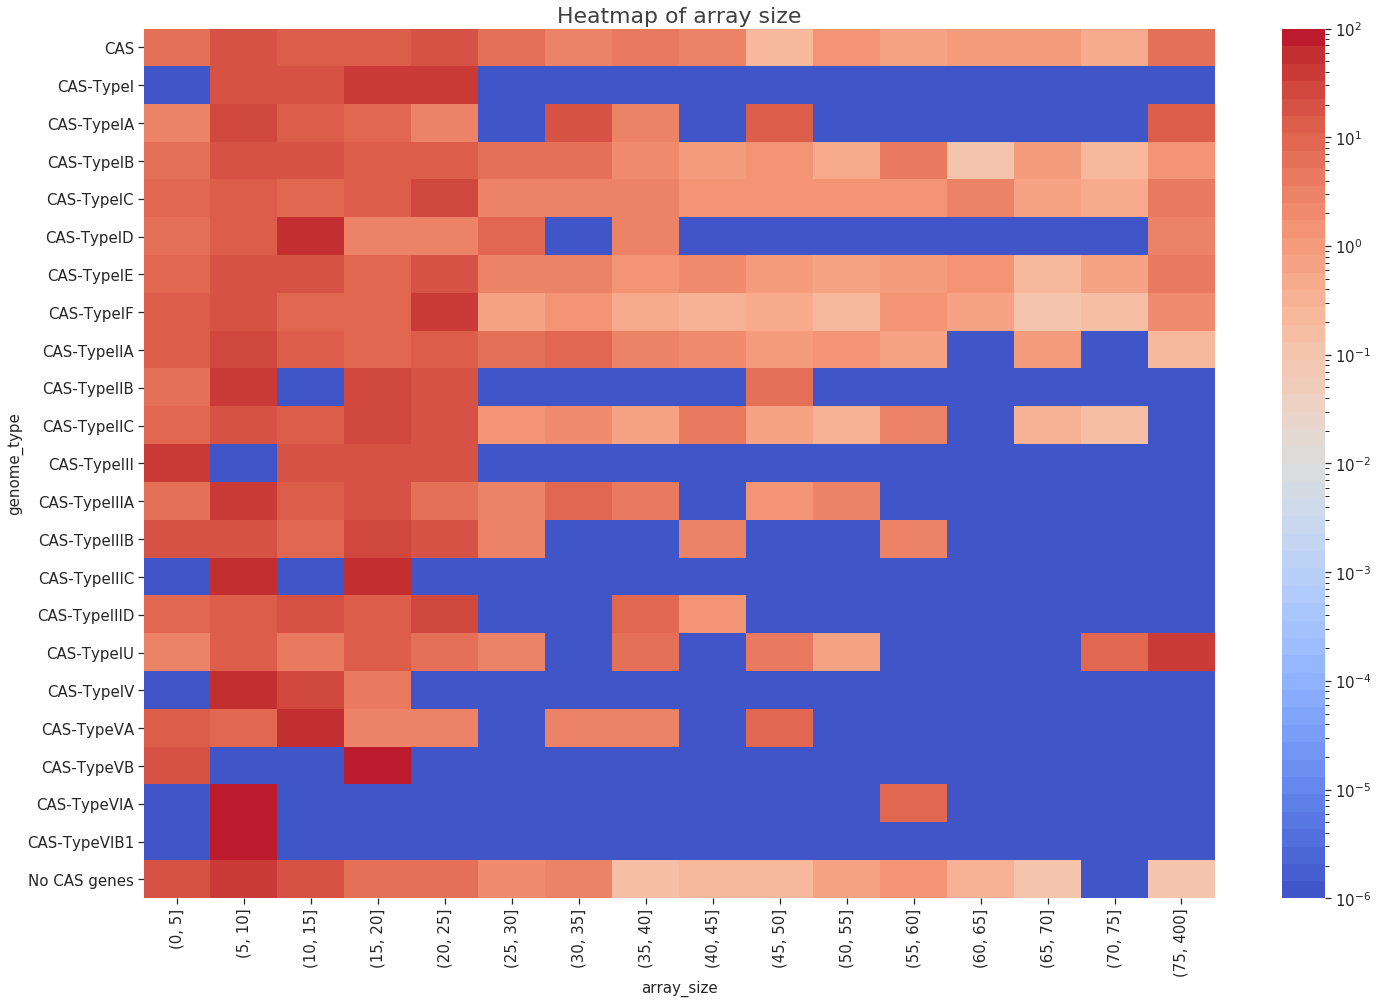

In [114]:
ax = sns.heatmap(pivot_table.applymap(lambda x: x if x!= 0 else 0.000001), yticklabels=True, xticklabels=True, square=False, 
            cmap=sns.color_palette("coolwarm", 50), 
            cbar_kws={'ticks': mpl.ticker.LogLocator()}, 
            norm=mpl.colors.LogNorm(vmin=pivot_table.min().min(), vmax=pivot_table.max().max()))
increase_figsize(4, plt)
plt.title("Heatmap of array size" + title_mod)
# save_fig()
# save_fig()

figure saved in /home/hielke/bep/figs/FINAL2/A46___Heatmap_of_spacer_position.png


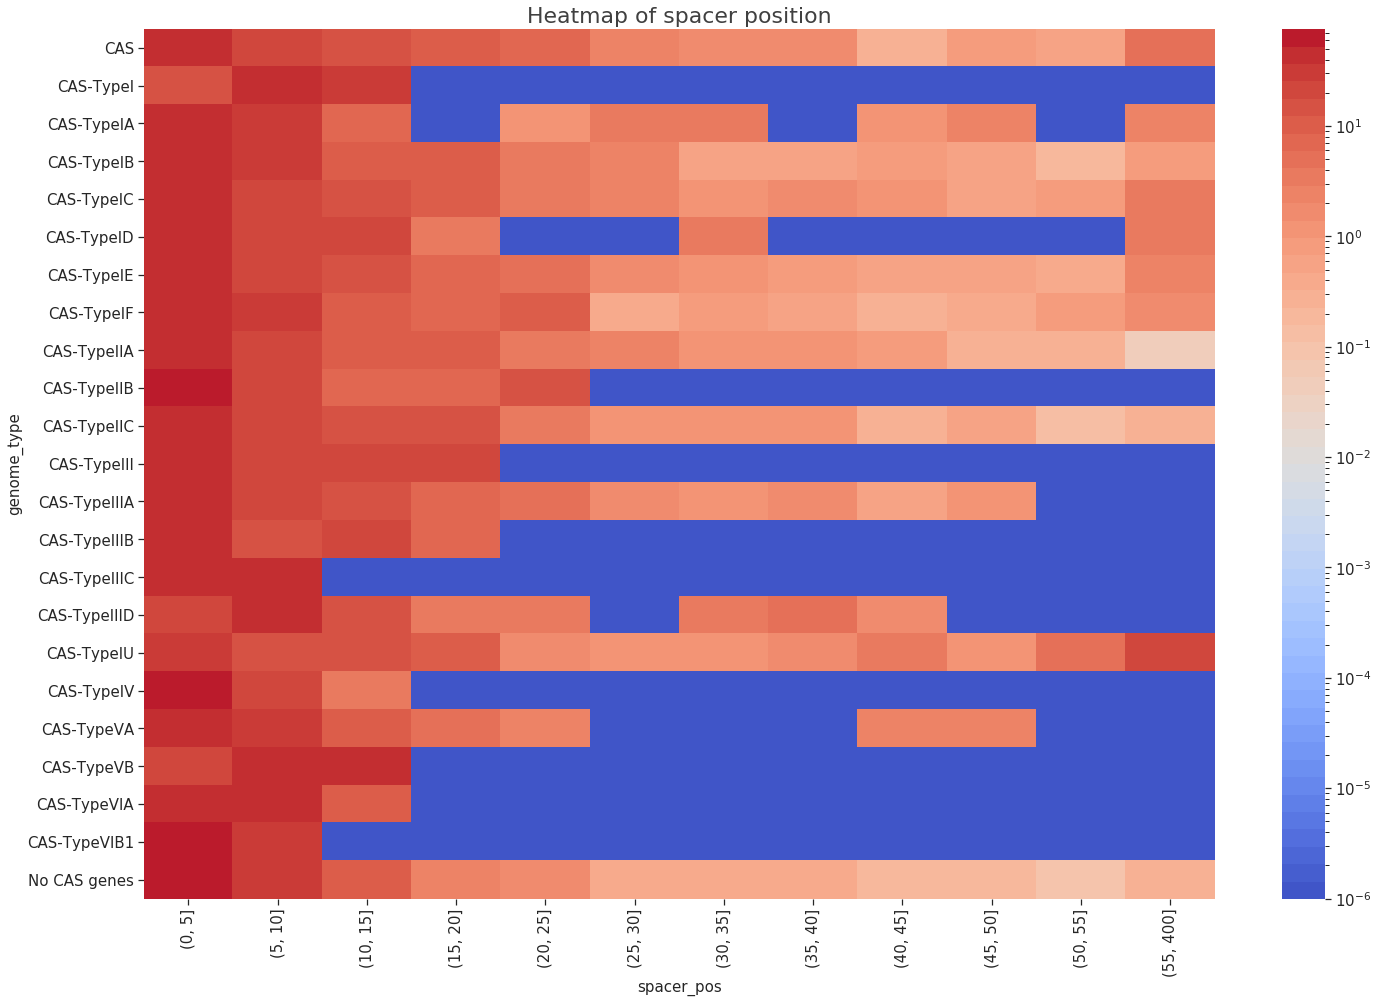

In [115]:
pivot_table = (
    df_single_type.groupby(
        ['genome_type', 
        pd.cut(
            df_single_type['spacer_pos'], 
            pd.IntervalIndex.from_breaks(list(range(0,60,5)) + [400])
            )
        ]
    )
    .size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .unstack()
    .fillna(0)
)
pivot_table
ax = sns.heatmap(pivot_table.applymap(lambda x: x if x!= 0 else 0.000001), 
            yticklabels=True, xticklabels=True, square=False, 
            cmap=sns.color_palette("coolwarm", 50), 
            cbar_kws={'ticks': mpl.ticker.LogLocator()}, 
            norm=mpl.colors.LogNorm(vmin=pivot_table.min().min(), vmax=pivot_table.max().max()))
increase_figsize(4, plt)
plt.title("Heatmap of spacer position" + title_mod)
save_fig(save=True)
# save_fig()

In [116]:
# pivot_table = df_single_type.groupby(
#     ['genome_type', pd.cut(df_single_type['rel_spacer_pos'], 
#     pd.IntervalIndex.from_breaks(list(map(lambda x: -.01 if x==0 else round(0.01*x, 2), range(0,110,5)))))
#                            ]).size() \
#         .groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().fillna(0)
# pivot_table
# ax = sns.heatmap(pivot_table.where(pivot_table!=0, 1e0), yticklabels=True, xticklabels=True, square=False, 
#             cmap=sns.color_palette("coolwarm", 50), 
#             cbar_kws={'ticks': mpl.ticker.LogLocator()}, 
#             norm=mpl.colors.LogNorm(vmin=pivot_table.min().min(), vmax=pivot_table.max().max()))
# increase_figsize(4, plt)
# plt.title("Heatmap of relative spacer position (0: leader; 1: tail)" + title_mod)
# if False or save: plt.savefig(fig_folder + first_order + str(second_order) + ax.get_title().replace(" ", "_") + ".png", format='png', bbox_inches='tight')

## PAM analysis

For the PAM analysis we have looked at the type infered from the Cas proteins (genome_type) and the type infered from the repeat family of the CRISRP array (crispr_type). The column of the table represents that with the following numbers

**NB.** Not for all CRISPR types a PAM analysis can be performed, since not all have known PAM sequences.  
Also note that the type referred in the plot is derived from the found proteins, and the PAM analysis checks for both the type of the proteins as from the CRISPR arrays repeat family. 

So, it could be that there is no PAM available for the CAS proteins in the genome, but there can be a PAM test performed based on the repeat family of the CRISPR array in that genome. 

| Number | explanation |
| --- | --- |
| -1 | no PAM available |
| 0  | PAM incorrect for both |
| 1  | crispr_type correct |
| 2  | genome_type correct
| 3  | both correct |

We have simplified this in the second graph by only looking at the genome_type, so (0 & 1, and 2 & 3, are merged to resp. incorrect PAM, and correct PAM).

figure saved in /home/hielke/bep/figs/FINAL2/A47___PAM_analysis.png


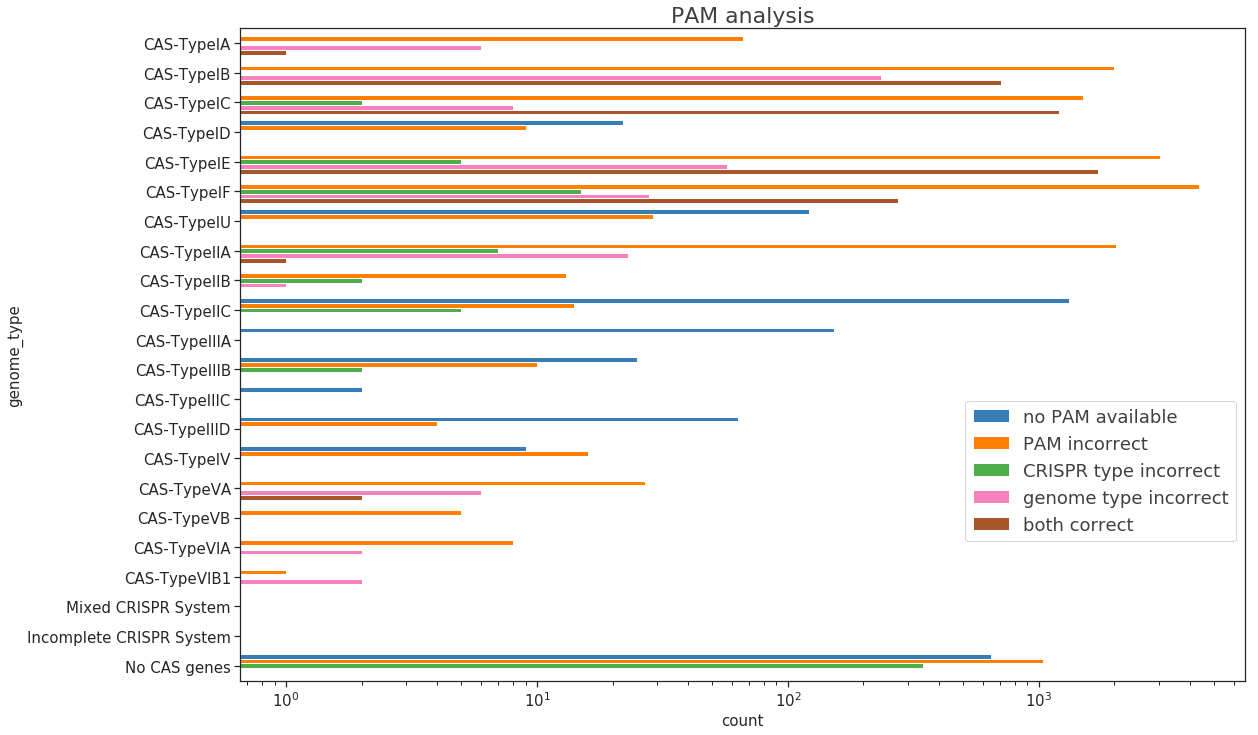

In [117]:
ax = sns.countplot(y='genome_type', hue='PAM_confid', data=df, saturation=100, palette=cbf, 
                   order=sorted(df['new_type_group'].unique(), key=sort_groups))
ax.set_xscale('log')
increase_figsize(3)
plt.title("PAM analysis")
plt.legend(loc='lower right', labels=['no PAM available', 'PAM incorrect', 
                                      'CRISPR type incorrect', 'genome type incorrect',
                                     'both correct'], bbox_to_anchor=(1.0, 0.2))
save_fig()

figure saved in /home/hielke/bep/figs/FINAL2/A48___Correct_or_incorrect_PAM_for_CRISPR_types..png


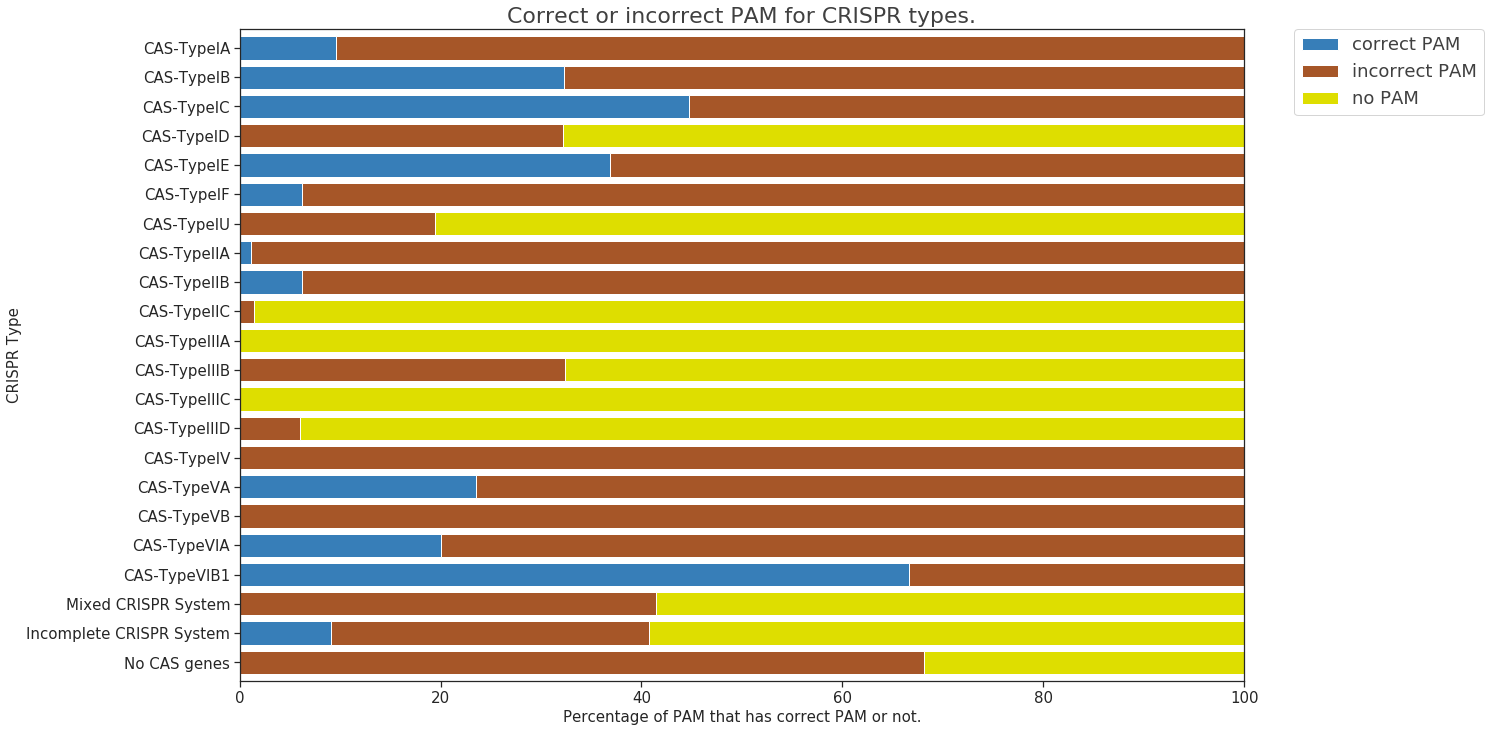

In [118]:
df["PAM_simple"] = df['PAM_confid'].map({-1: "no PAM", 
                                         0: "incorrect PAM", 1: "incorrect PAM", 
                                         2: "correct PAM", 3: "correct PAM"})
simple_pam = df.groupby("new_type_group")["PAM_simple"].value_counts(normalize=True).unstack().fillna(0).mul(100)
simple_pam = simple_pam.pipe(crispr_order)
ax = simple_pam.plot.barh(stacked=True, cmap=cbf_map, width=.8)

ax.legend(loc='center right',  shadow=True)
ax.set_xlim((0, 100))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Correct or incorrect PAM for CRISPR types." )
plt.ylabel("CRISPR Type")
plt.xlabel("Percentage of PAM that has correct PAM or not.")
increase_figsize(3)
save_fig()

## Hits in genes

figure saved in /home/hielke/bep/figs/FINAL2/A49___STS_able_to_target_RNA_(RNA_+)_or_not_(RNA_-),_or_not_on_a_gene_(intergenic)._(hit_identity:_>90%).png


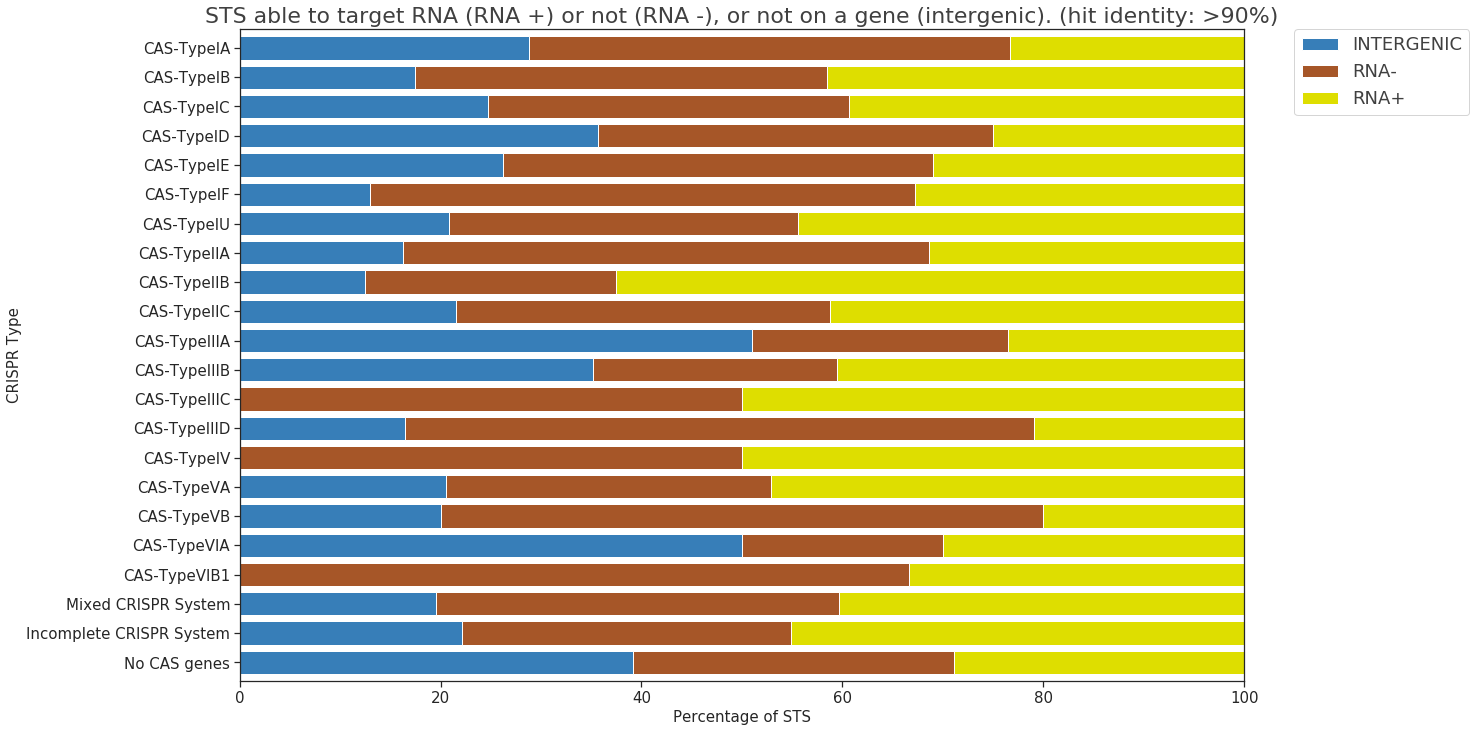

In [119]:
gene_hits = (
    df
    .groupby('new_type_group')['gene_hit']
    .value_counts(normalize=True)
    .unstack().fillna(0)
    .mul(100).pipe(crispr_order)
    
)
gene_hits = gene_hits[['INTERGENIC', 'RNA-', 'RNA+']]
ax = gene_hits.plot.barh(stacked=True, cmap=cbf_map, width=.8)

ax.legend(loc='center right',  shadow=True)
ax.set_xlim((0, 100))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("STS able to target RNA (RNA +) or not (RNA -), or not on a gene (intergenic). (hit identity: %s)" 
          % perc_ident + title_mod)
plt.ylabel("CRISPR Type")
plt.xlabel("Percentage of STS")
increase_figsize(3)
save_fig()

figure saved in /home/hielke/bep/figs/FINAL2/A50___Hits_in_genes_(hit_identity:_>90%).png


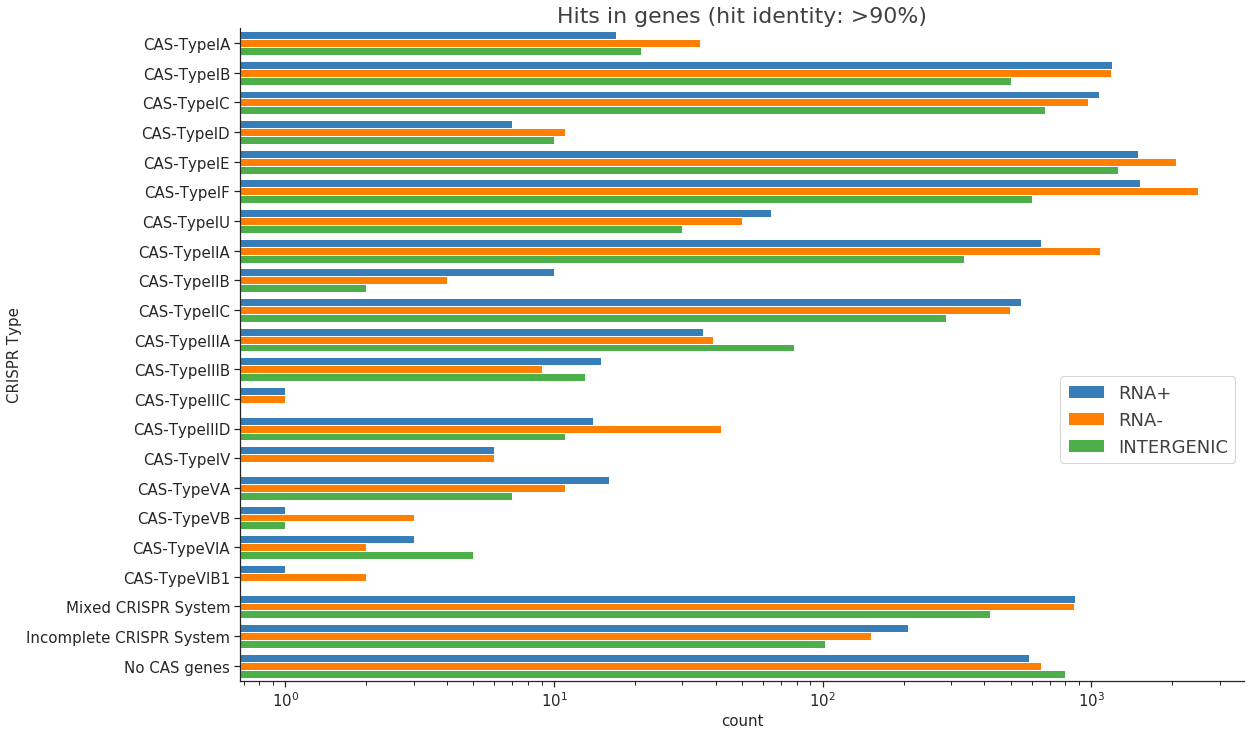

In [120]:
# df_single_type = df[~df['genome_type'].str.contains('/')]
ax = sns.countplot(y='new_type_group', hue='gene_hit', data=df, 
                   saturation=100, palette=cbf, order=sorted(df['new_type_group'].unique(), key=sort_groups))
ax.set_xscale('log')
increase_figsize(3)
plt.legend(loc='center right', bbox_to_anchor=(1, .4))
sns.despine()
# plt.setp(ax.get_legend().get_title(), fontsize=20, text=None)
plt.ylabel("CRISPR Type")
plt.title("Hits in genes (hit identity: %s)" % perc_ident + title_mod,)
save_fig()

## More analysis in leader/middle/tail

figure saved in /home/hielke/bep/figs/FINAL2/A51___Percentage_of_phage_target_(hit_identity:_>90%).png


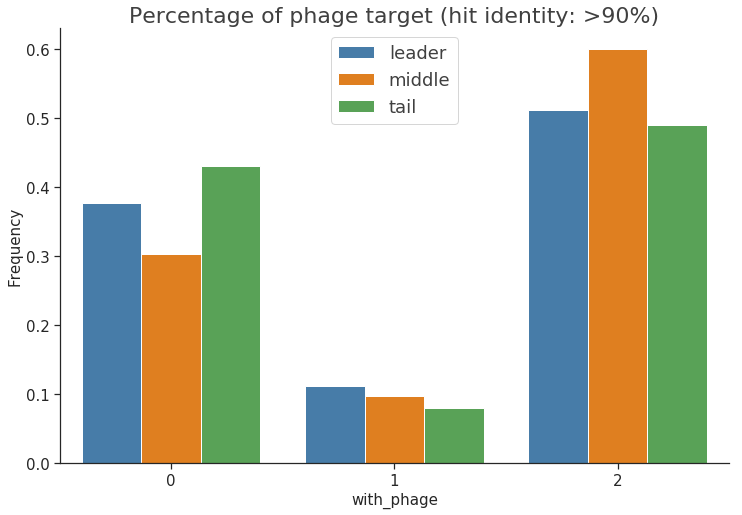

In [121]:
x, y, hue = 'with_phage', 'Frequency', 'name_spacer_pos'
df.pipe(
    lambda d:
    d[x]
    .groupby(d[hue])
    .value_counts(normalize=True)
    .rename(y)
    .reset_index()
).pipe((sns.barplot, "data"), hue=hue, x=x, y=y)
increase_figsize(2)
plt.legend(loc='upper center')
sns.despine()
plt.title("Percentage of phage target (hit identity: %s)" % perc_ident)
save_fig()

figure saved in /home/hielke/bep/figs/FINAL2/A52___Percentage_of_target_group_of_STS_from_small_arrays_(size_2-3)_hit_identity:_>90%.png


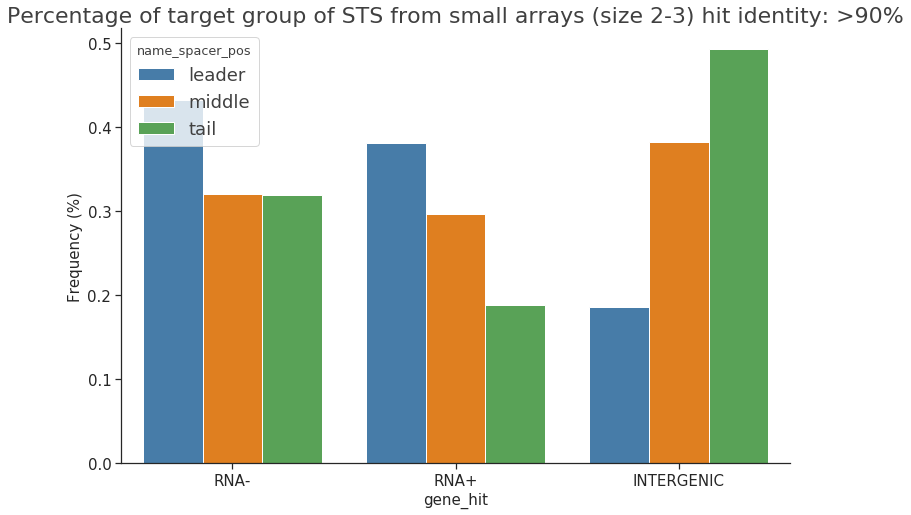

In [122]:
x, y, hue = 'gene_hit', 'Frequency (%)', 'name_spacer_pos'
df.query('array_size < 4').pipe(
    lambda d:
    pd.DataFrame() if d.empty else
    d[x]
    .groupby(d[hue])
    .value_counts(normalize=True)
    .rename(y)
    .reset_index()
).pipe((sns.barplot, "data"), hue=hue, x=x, y=y)
increase_figsize(2)
sns.despine()
plt.title("Percentage of target group of STS from small arrays (size 2-3) hit identity: %s" % perc_ident)
# plt.legend(loc='upper center')
save_fig()

## Just trying something out

### Some export

In [123]:
df_hitcount.head()

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,array_ori,contigs,size,name,type,class,num_genes,new_type_group,top_level_group,genome_count_hit
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100053.4,AAGAGGCGATTAGTTGGCTATATGCAGCCTTT,45209,45178,JQGS01000037,8,JQGS01000093_1_8,100.000,32,53765,JQGS01000093_1,23,6.22,29,CAS-TypeIE,CAS-TypeIE,3,CTTTTACTGA,3,2,2,RNA-,JQGS01000037_64,UNCLASSIFIED,0.318182,middle,mid,341,4040397,Leptospira alexanderi strain 56650,CAS-TypeIE,AdditionalAccompaniedSingleUnknown,11,CAS-TypeIE,Complete CRISPR System,16
100053.5,CACATCCAACCCGAAGACTTGAGCATTCTTCA,1242,1273,JQGU01000091,22,JQGU01000025_1_22,100.000,32,16908,JQGU01000025_1,23,6.23,29,CAS-TypeIE,CAS-TypeIE,0,CTGGTTGGTG,3,NULL,0,RNA-,JQGU01000091_1,Protein of unknown function (DUF1564),0.954545,middle,mid,335,4044353,Leptospira alexanderi strain 56643,CAS-TypeIE,SingleUnknownExtra,8,CAS-TypeIE,Complete CRISPR System,2
100053.6,GAGGGAAAGAAATTTTTCAACCTTGAGATCAG,3063,3033,JQGV01000288,35,JQGV01000216_1_35,96.875,32,5252,JQGV01000216_1,51,6.26,29,CAS-TypeIE,CAS-TypeIE,0,TCGTTTTATC,3,NULL,0,RNA-,JQGV01000288_5,Protein of unknown function (DUF736),0.680000,middle,mid,368,4062692,Leptospira alexanderi strain 56640,CAS-TypeIE,SingleUnknownExtra,8,CAS-TypeIE,Complete CRISPR System,5
100053.7,AAAGAAGATTTTACGAGTGATCAAACGAACCCAATGGGA,1863,1825,JQGT01000196,15,JQGT01000117_1_15,100.000,39,12738,JQGT01000117_1,24,6.16,29,CAS-TypeIE,CAS-TypeIE,0,CGTATTCGGA,3,NULL,0,RNA-,JQGT01000196_2,SET domain,0.608696,middle,mid,337,4067564,Leptospira alexanderi strain 56159,CAS-TypeIE,SingleUnknownExtra,8,CAS-TypeIE,Complete CRISPR System,10
100053.8,AAAACAGGATGGATTTTGATTTAAAACCCTAACCACTGATTCCTAA...,146,200,JQGW01000033,3,JQGW01000031_1_3,98.180,55,75992,JQGW01000031_1,3,5.25,29,CAS-TypeIE,CAS-TypeIE,3,CCATCCAACC,3,NULL,0,INTERGENIC,NULL,NULL,1.000000,tail,tail,238,4060960,Leptospira alexanderi strain 56659,CAS-TypeIE,AccompaniedSingleUnknown,8,CAS-TypeIE,Complete CRISPR System,5


In [124]:
if False:
    with pd.ExcelWriter(data_folder + "hit_ammounts_per_genome.xlsx") as excel_writer:
        for key, group in df_hitcount.groupby('new_type_group'):
            group.to_excel(excel_writer, sheet_name=key, columns=['name', 'genome_count_hit'])
    
    

### Additional analysis

In [125]:
from utils.uclust import uclust

def uclust_analysis_sample(test_groups, match_id):
    test_size = min(map(len, test_groups.values()))

    test_groups = {key: value.sample(test_size) for key, value in test_groups.items()}
    print("---")
    print("All groups cut to %d size" % test_size)
    print("---")
    for key, value in test_groups.items():
        
        print("%s clusters in %d different groups" % (key, len(list(uclust(value, match_id)))))    
        
def uclust_analysis_perc(test_groups, match_id):
    for key, value in test_groups.items():
        size = len(value)
        u_list = list(uclust(value, match_id))
        u_list = sorted(u_list)
        print(["%.2f" % (a / size) for a in u_list[-10:]])
        u = len(u_list)
        print("clustering %s shows %.2f %% unique sequnces" 
              % (key, (100 * u / size)))

def uclust_analysis(test_groups, match_id=0.9, test='sample'):
    assert test in ['sample', 'perc'], "%s is not a valid test" % test
    for key, value in test_groups.items():
        print("%s: %d" % (key, len(value)))
    {'sample': uclust_analysis_sample, 'perc': uclust_analysis_perc}[test](test_groups, match_id)
    

In [126]:
from utils.uclust import uclust
type_group = df[df['new_type_group'].str.contains('CAS-TypeIIIA')]
test_groups = {
    'CAS-TypeIII': type_group['seq'],
#     'CAS-TypeIII_gene': type_group[type_group['gene_hit'].str.contains('RNA')]['seq'],
    'CAS-TypeIII_intergenic': type_group[~type_group['gene_hit'].str.contains('RNA')]['seq'],
    'ALL': df['seq'],
}
uclust_analysis(test_groups)

CAS-TypeIII_intergenic: 78
ALL: 23626
CAS-TypeIII: 153
---
All groups cut to 78 size
---
CAS-TypeIII_intergenic clusters in 46 different groups
ALL clusters in 72 different groups
CAS-TypeIII clusters in 66 different groups


In [127]:
def analyze(df):

    types_analyze = [key for key, value in 
                     df[~df['gene_hit'].str.contains('RNA')]['new_type_group'].value_counts().to_dict().items() 
                     if value > 500]
    test_groups = {'ALL': df['seq']}
    for t in types_analyze: 

        type_group = df[df['new_type_group'] == t]
        gene = type_group['gene_hit'].str.contains('RNA')
        test_groups.update({"%s_gene" % t: type_group[gene]['seq'], 
                            "%s_intergenic" % t: type_group[~gene]['seq']})

    uclust_analysis(test_groups, test='perc')
    
interesting = df_all.query('(new_type_group == "CAS-TypeIIIA") and (seq == "TTAAAACCGTGTTGCACTGCAACCCGGAATTCTTGCAC")')
# TCGGGGAGCCGATCAGCGACCACCGCACCCTGTCA
if True:
    with open(data_folder + 'typeiiia_genomes_staphi', 'w') as f:
        f.writelines(line + '\n' for line in set(interesting.index))
        

In [128]:
# df_all.query('new_type_group == "CAS-TypeIIIA"')['seq'].value_counts()

In [129]:
interesting.to_csv(data_folder + 'typeiiia_staphi.tsv', sep='\t')

In [130]:
interesting

,seq,c_1,c_2,contig_hit,spacer_pos,spacer_id,hit_ident,spacer_size,contig_size,array_id,array_size,array_confid,repeat_size,array_type,genome_type,PAM_confid,poss_PAM,PAM_side,phage_class,with_phage,gene_hit,gene_id,gene_class,rel_spacer_pos,name_spacer_pos,array_ori,contigs,size,name,type,class,num_genes,new_type_group,top_level_group
genome_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1447522.3,TTAAAACCGTGTTGCACTGCAACCCGGAATTCTTGCAC,59,22,JLDK01000070,1,JLDK01000101_1_1,100.0000,38,3202,JLDK01000101_1,12,3.26,36,NA,CAS-TypeIIIA,-1,NULL,NULL,NULL,0,INTERGENIC,NULL,NULL,0.000000,leader,head,101,4406986,Mycobacterium tuberculosis MD14437,CAS-TypeIIIA,SingleUnknownExtra,8,CAS-TypeIIIA,Complete CRISPR System
1773.1139,TTAAAACCGTGTTGCACTGCAACCCGGAATTCTTGCAC,20665,20694,CFIA01000063,11,CFIA01000089_1_11,78.9474,38,20694,CFIA01000089_1,27,3.24,36,NA,CAS-TypeIIIA,-1,NULL,NULL,NULL,0,INTERGENIC,NULL,NULL,0.384615,middle,mid,160,4321711,Mycobacterium tuberculosis strain P000167,CAS-TypeIIIA,SingleUnknown,9,CAS-TypeIIIA,Complete CRISPR System
1773.1139,TTAAAACCGTGTTGCACTGCAACCCGGAATTCTTGCAC,20665,20694,CFIA01000063,13,CFIA01000089_1_13,78.9474,38,20694,CFIA01000089_1,27,3.24,36,NA,CAS-TypeIIIA,-1,NULL,NULL,NULL,0,INTERGENIC,NULL,NULL,0.461538,middle,mid,160,4321711,Mycobacterium tuberculosis strain P000167,CAS-TypeIIIA,SingleUnknown,9,CAS-TypeIIIA,Complete CRISPR System
1773.1622,TTAAAACCGTGTTGCACTGCAACCCGGAATTCTTGCAC,106133,106170,COTK01000014,1,COTK01000100_1_1,100.0000,38,106201,COTK01000100_1,4,3.06,36,NA,CAS-TypeIIIA,-1,NULL,NULL,NULL,0,INTERGENIC,NULL,NULL,0.000000,leader,head,100,4402748,Mycobacterium tuberculosis strain 0904J,CAS-TypeIIIA,SingleUnknown,9,CAS-TypeIIIA,Complete CRISPR System
1773.2084,TTAAAACCGTGTTGCACTGCAACCCGGAATTCTTGCAC,30,1,CNGK01000101,6,CNGK01000017_1_6,78.9474,38,9251,CNGK01000017_1,18,3.16,36,NA,CAS-TypeIIIA,-1,NULL,NULL,NULL,0,INTERGENIC,NULL,NULL,0.294118,middle,mid,200,4313311,Mycobacterium tuberculosis strain P000207,CAS-TypeIIIA,SingleUnknown,9,CAS-TypeIIIA,Complete CRISPR System
1773.2162,TTAAAACCGTGTTGCACTGCAACCCGGAATTCTTGCAC,20681,20717,CNFY01000059,7,CNFY01000117_1_7,97.3684,38,20717,CNFY01000117_1,12,3.25,36,NA,CAS-TypeIIIA,-1,NULL,NULL,NULL,0,INTERGENIC,NULL,NULL,0.545455,middle,mid,149,4303388,Mycobacterium tuberculosis strain P000176,CAS-TypeIIIA,SingleUnknown,9,CAS-TypeIIIA,Complete CRISPR System
1773.2162,TTAAAACCGTGTTGCACTGCAACCCGGAATTCTTGCAC,20681,20717,CNFY01000059,8,CNFY01000022_1_8,97.3684,38,20717,CNFY01000022_1,11,3.26,36,NA,CAS-TypeIIIA,-1,NULL,NULL,NULL,0,INTERGENIC,NULL,NULL,0.700000,middle,mid,149,4303388,Mycobacterium tuberculosis strain P000176,CAS-TypeIIIA,SingleUnknown,9,CAS-TypeIIIA,Complete CRISPR System
1773.2162,TTAAAACCGTGTTGCACTGCAACCCGGAATTCTTGCAC,20681,20717,CNFY01000059,9,CNFY01000117_1_9,97.3684,38,20717,CNFY01000117_1,12,3.25,36,NA,CAS-TypeIIIA,-1,NULL,NULL,NULL,0,INTERGENIC,NULL,NULL,0.727273,middle,mid,149,4303388,Mycobacterium tuberculosis strain P000176,CAS-TypeIIIA,SingleUnknown,9,CAS-TypeIIIA,Complete CRISPR System


In [131]:
len(interesting)

8

In [132]:
df_crispr.head()

,contig,array_id,start,end,ori,size,type,conf,repeat
genome_id,,,,,,,,,
1324264.3,JLXT01000011,JLXT01000011_1,0,684,Reverse,9,NA,3.18,GTCGTCAGACCCAAAACCCCGAGAGGGGACGGAAAC
1324264.3,JLXT01000009,JLXT01000009_1,947496,948851,Reverse,18,NA,3.24,GTCGTCAGACCCAAAACCCCGAGAGGGGACGGAAAC
1324264.3,JLXT01000010,JLXT01000010_1,56,1186,Reverse,15,NA,3.20,GTCGTCAGACCCAAAACCCCGAGAGGGGACGGAAAC
1603886.3,BDIS01000038,BDIS01000038_1,5412,6343,Forward,14,NA,3.24,CAAGCTTATCAAGAAGGGTGAATGCTAATTCCCAGC
1633637.3,CZVQ01000157,CZVQ01000157_1,2,778,Forward,9,NA,3.26,GTGAGCATCGAACCAGTGTGGAATTTAAAC


In [133]:
crispr_test.head()

NameError: name 'crispr_test' is not defined

In [ ]:
crispr_test = interesting.join(df_crispr.reset_index().set_index('array_id'), on='array_id', rsuffix='_crispr')
# crispr_test.loc['1773.5284', ['start', 'end', 'contig', 'c_1', 'c_2', 'contig_hit']]

In [ ]:
crispr_test

In [ ]:
test = interesting.join(df_meta)
from collections import Counter
print(Counter(map(lambda d: " ".join(d.split()[:2]), test['name'].value_counts().index)))